# Local Setup Instructions

## Prerequisites Checklist

Before running this notebook, ensure you have completed the following setup:

- [ ] **Java 11 installed** and `JAVA_HOME` configured
  - macOS: `brew install openjdk@11`
  - Set: `export JAVA_HOME=$(/usr/libexec/java_home -v 11)`
- [ ] **Conda environment `fraud-shield` created and activated**
  - Create: `conda env create -f environment.yml`
  - Activate: `conda activate fraud-shield`
- [ ] **PySpark verified working**
  - Test: `python -c "from pyspark.sql import SparkSession; print('PySpark OK')"`
- [ ] **Data directories created**
  - `data/input/` - for input data files
  - `data/checkpoints/results/` - for checkpoints and results
- [ ] **Data files placed in `data/input/`**
  - `fraudTrain.csv` → `data/input/fraudTrain.csv`
  - `uszips.csv` → `data/input/uszips.csv` (if needed)

## Environment Activation

```bash
conda activate fraud-shield
```

## Data File Placement

Place your data files in the `data/input/` directory:
- Training data: `data/input/fraudTrain.csv`
- ZIP code data: `data/input/uszips.csv` (if needed)

## Checkpoint Directory Structure

Checkpoints will be saved to `data/checkpoints/` and will persist locally:
- Section checkpoints: `data/checkpoints/section*.parquet`
- Results: `data/checkpoints/results/`

**Note:** This is a local execution version configured for the `fraud-shield` conda environment on your local machine.

# **Notebook 1** Fraud Detection EDA (Timezone-Aware) - Local Execution Version
**Project:** Fraud Shield AI  
**Notebook:** 01-local-fraud-detection-eda.ipynb  
**Objective:** Exploratory Data Analysis & Feature Validation (No Modeling)

**Note:** Local execution version - configured for conda environment `fraud-shield`

## 📋 Project Information

| **Attribute** | **Details** |
| :--- | :--- |
| **Author** | Alireza Barzin Zanganeh |
| **Contact** | abarzinzanganeh@gmail.com |
| **Date** | January 18, 2026 |
| **Project Type** | Capstone Project|

**Data Source Attribution:**  
ZIP code and timezone data provided by [SimpleMaps US ZIP Code Database](https://simplemaps.com/data/us-zips). Free version used for EDA.  
Use in production requires linking back as per their license, which we comply with.

## Problem Statement
The objective is to design and implement a comprehensive fraud detection system capable of identifying fraudulent transactions with high accuracy and scalability. The system will leverage:

Supervised learning to identify known fraud patterns from labeled historical data.
Deep learning to model complex relationships and sequential transaction behaviors.
The solution will focus on minimizing false positives, maximizing fraud recall, and maintaining scalability for high-volume real-time transaction processing.

## Notebook Scope & Constraints

This notebook is **EDA-only** and focuses on:
- Dataset understanding
- Assumption validation
- Pattern discovery
- Feature design guidance

### Explicitly Out of Scope
- Model training
- Feature scaling
- Hyperparameter tuning
- Evaluation metrics

All modeling work is deferred to later notebooks.


## Critical Time Assumptions

Transaction timestamps are **not guaranteed to be in local time**.

Any analysis involving:
- Hour of day
- Day of week
- Night vs daytime behavior

is considered **provisional** until timestamps are converted to **local transaction time**
using latitude/longitude–based timezone inference.

Timezone correction is treated as a first-class EDA requirement.


## Analysis Roadmap

This notebook follows a strict, sequential EDA structure:

1. Environment & Dataset Loading  
2. Data Quality Assessment  
3. Target Variable (Fraud) Overview  
4. Temporal Analysis (Timezone-Aware)  
5. Calendar-Level Patterns (Month, Seasonality)  
6. Key Insights & Next Steps

Each section builds on validated assumptions from the previous one.


# 1. Environment & Dataset Inspection


## 1.1 Global Imports & Dependencies

In [1]:
# ============================================================
# GLOBAL IMPORTS & DEPENDENCIES
# ============================================================
# All imports consolidated here for clarity and maintainability

# Standard Library
import os
import sys
import time
from typing import Tuple, Dict, List
from pathlib import Path

# PySpark Core
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, count, sum as spark_sum, avg, min as spark_min, max as spark_max,
    sqrt, sin, cos, radians, atan2,
    round, round as spark_round, floor, ceil, trim, when, lit, concat, concat_ws,
    hour, dayofweek, dayofmonth, month, year, date_format,
    from_utc_timestamp, to_timestamp, unix_timestamp,
    broadcast, first, last, collect_list, collect_set,
    percentile_approx, stddev, variance, corr
)
from pyspark.sql.window import Window
from pyspark.sql.types import *

# Data Analysis & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

# Path resolution for local execution
# Calculate PROJECT_ROOT based on notebook location
# Since notebook is in local_notebooks/, project root is parent directory
NOTEBOOK_DIR = Path.cwd()  # Current working directory
# If we're in local_notebooks/, go up one level to get project root
if NOTEBOOK_DIR.name == "local_notebooks":
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    # Fallback: assume we're already at project root
    PROJECT_ROOT = NOTEBOOK_DIR

# Change working directory to project root for consistency
os.chdir(PROJECT_ROOT)

print("All dependencies loaded successfully")
print(f"Project root: {PROJECT_ROOT}")

All dependencies loaded successfully
Project root: /Users/abzanganeh/Desktop/projects/fraud-shield-ai


In [2]:
# Imports are now consolidated in the Global Imports & Dependencies section above
print("✓ Using global imports")


✓ Using global imports


## 1.2 Checkpoint Configuration

### Purpose
Define checkpoint paths and directories for saving/loading intermediate DataFrames.
This enables running sections independently and avoiding recomputation.

In [3]:
# ============================================================
# CHECKPOINT CONFIGURATION
# ============================================================

# Local directory (absolute path - checkpoints will persist locally)
CHECKPOINT_BASE_DIR = str(PROJECT_ROOT / "data" / "checkpoints")

# Section-level checkpoints (major milestones - explicit constants)
CHECKPOINT_SECTION3 = f"{CHECKPOINT_BASE_DIR}/section3_base_train.parquet"
CHECKPOINT_SECTION5 = f"{CHECKPOINT_BASE_DIR}/section5_amount_features.parquet"
CHECKPOINT_SECTION6 = f"{CHECKPOINT_BASE_DIR}/section6_timezone_resolved.parquet"
CHECKPOINT_SECTION7 = f"{CHECKPOINT_BASE_DIR}/section7_temporal_features.parquet"
CHECKPOINT_SECTION8 = f"{CHECKPOINT_BASE_DIR}/section8_geographic_features.parquet"
CHECKPOINT_SECTION9 = f"{CHECKPOINT_BASE_DIR}/section9_demographics_features.parquet"
CHECKPOINT_SECTION10 = f"{CHECKPOINT_BASE_DIR}/section10_credit_card_features.parquet"
CHECKPOINT_SECTION11 = f"{CHECKPOINT_BASE_DIR}/section11_enriched_features.parquet"

# Create checkpoint directory if it doesn't exist
os.makedirs(CHECKPOINT_BASE_DIR, exist_ok=True)

print(f"Checkpoint directory: {CHECKPOINT_BASE_DIR}")
print(f"✓ Checkpoint paths configured for Sections 3, 5, 6, 7, 8, 9, 10, 11")
print(f"✓ Using local directory - checkpoints will persist locally")

Checkpoint directory: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints
✓ Checkpoint paths configured for Sections 3, 5, 6, 7, 8, 9, 10, 11
✓ Using local directory - checkpoints will persist locally


## 1.3 Local Environment & Input Validation

### Purpose
Verify the local execution environment and confirm the availability and structure
of input datasets **before initializing Spark**.

### Why This Matters
- Confirms datasets are correctly mounted
- Avoids hard-coded paths
- Ensures Spark reads from the correct input directory


In [4]:
# Clear Spark cache if needed (uncomment to use)
# spark.catalog.clearCache()

print("Spark session ready - cache cleared if needed")


Spark session ready - cache cleared if needed


In [5]:
# Environment & dataset inspection

INPUT_DIR = str(PROJECT_ROOT / "data" / "input")

print("Listing all files under data/input:\n")

for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Listing all files under data/input:

/Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/input/uszips.csv
/Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/input/fraudTrain.csv


## 1.4 Checkpoint Verification (Optional)

Run this at the start of a session to confirm your saved Parquet checkpoints exist and see their sizes.

In [6]:
# ============================================================
# VERIFY CHECKPOINTS EXIST
# ============================================================

print("=" * 80)
print("CHECKPOINT VERIFICATION")
print("=" * 80)

checkpoints = [
    ("Section 3", CHECKPOINT_SECTION3),
    ("Section 5", CHECKPOINT_SECTION5),
    ("Section 6", CHECKPOINT_SECTION6),
    ("Section 7", CHECKPOINT_SECTION7),
    ("Section 8", CHECKPOINT_SECTION8),
    ("Section 9", CHECKPOINT_SECTION9),
    ("Section 10", CHECKPOINT_SECTION10),
    ("Section 11", CHECKPOINT_SECTION11)
]

for name, path in checkpoints:
    exists = os.path.exists(path)
    status = "✓" if exists else "✗"
    size = ""
    if exists:
        # Get file size (parquet files are single files, not directories)
        if os.path.isfile(path):
            total_size = os.path.getsize(path)
        else:
            # If it's a directory (shouldn't happen for parquet, but handle it)
            total_size = sum(
                os.path.getsize(os.path.join(dirpath, filename))
                for dirpath, dirnames, filenames in os.walk(path)
                for filename in filenames
            )
        
        size_mb = total_size / (1024 * 1024)
        size = f" ({size_mb:.1f} MB)"
    print(f"{status} {name}: {path}{size}")


results_dir = Path(CHECKPOINT_BASE_DIR) / "results"
if results_dir.exists():
    result_files = list(results_dir.glob("*"))
    print(f"✓ EDA results directory: {len(result_files)} saved results")
else:
    print("⚠️  EDA results directory not found")

print("=" * 80)
print("Checkpoints in data/checkpoints/ will persist locally")

CHECKPOINT VERIFICATION
✓ Section 3: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section3_base_train.parquet (98.1 MB)
✓ Section 5: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section5_amount_features.parquet (98.6 MB)
✓ Section 6: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section6_timezone_resolved.parquet (125.2 MB)
✓ Section 7: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section7_temporal_features.parquet (126.9 MB)
✓ Section 8: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section8_geographic_features.parquet (137.6 MB)
✓ Section 9: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section9_demographics_features.parquet (138.7 MB)
✓ Section 10: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section10_credit_card_features.parquet (143.5 MB)
✓ Section 11: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/secti

# 2. Spark Session Initialization


## 2.1 Spark Session Setup

### Purpose
Initialize a **SparkSession** to enable distributed data processing and replace
pandas-based workflows with Spark DataFrames.

### Why This Matters
- Enables scalable EDA and feature engineering
- Required for Spark `read`, `groupBy`, and ML operations
- Establishes a single entry point for Spark APIs


In [7]:
# Local execution configuration for 32GB RAM system
# Reduced memory allocation to leave resources for system processes
spark = (
    SparkSession.builder
    .appName("FraudShieldAI")
    .master("local[*]")
    .config("spark.driver.memory", "12g")
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.executor.memory", "12g")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .config("spark.sql.shuffle.partitions", "4")
    .config("spark.default.parallelism", "4")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/25 18:14:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 2.2 Checkpoint Helper Functions

### Purpose
Reusable functions for loading and saving checkpoints with validation.

In [8]:
# ============================================================
# CHECKPOINT MANAGER CLASS 
# ============================================================

from typing import Optional, List, Tuple
from pathlib import Path

class CheckpointManager:
    """
    Manages Spark DataFrame checkpoints with validation and automatic save/load.
    
    Design Pattern: Singleton-like (one instance per notebook)
    Responsibility: Checkpoint operations only
    Thread Safety: Spark operations are thread-safe
    
    Usage:
        manager = CheckpointManager(spark, CHECKPOINT_BASE_DIR)
        train_df = manager.load_or_compute(
            checkpoint_path=f"{CHECKPOINT_BASE_DIR}/cell_6_2_1_1.parquet",
            compute_func=lambda: compute_customer_timezone(train_df),
            required_columns=["customer_timezone"],
            cell_name="Section 6.2.1.1"
        )
    """
    
    def __init__(self, spark_session, base_dir: str = None):
        """
        Initialize checkpoint manager.
        
        Args:
            spark_session: Active SparkSession
            base_dir: Base directory for all checkpoints (defaults to CHECKPOINT_BASE_DIR)
        """
        self.spark = spark_session
        if base_dir is None:
            base_dir = CHECKPOINT_BASE_DIR
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(parents=True, exist_ok=True)
        
        # Statistics tracking
        self.stats = {
            'loaded': 0,
            'computed': 0,
            'saved': 0
        }
    
    def checkpoint_exists(self, checkpoint_path: str) -> bool:
        """Check if checkpoint file/directory exists."""
        return os.path.exists(checkpoint_path)
    
    def load_checkpoint(
        self, 
        checkpoint_path: str, 
        required_columns: Optional[List[str]] = None,
        cell_name: str = ""
    ) -> Tuple[Optional[DataFrame], bool]:
        """
        Load checkpoint if it exists and validate columns.
        
        Args:
            checkpoint_path: Path to Parquet checkpoint
            required_columns: Columns that must exist (None = no validation)
            cell_name: Name for logging
        
        Returns:
            tuple: (dataframe, loaded_successfully)
        """
        if not self.checkpoint_exists(checkpoint_path):
            if cell_name:
                print(f"⚠️  Checkpoint not found: {checkpoint_path}")
                print(f"  Will compute {cell_name}...")
            return None, False
        
        try:
            print(f"✓ Checkpoint found for {cell_name}")
            print(f"  Loading from: {checkpoint_path}")
            
            df = self.spark.read.parquet(checkpoint_path)
            row_count = df.count()
            col_count = len(df.columns)
            print(f"  Loaded {row_count:,} rows, {col_count} columns")
            
            # Validate required columns
            if required_columns:
                missing_cols = [
                    col for col in required_columns 
                    if col not in df.columns
                ]
                if missing_cols:
                    print(f"  ⚠️  Missing required columns: {missing_cols}")
                    print(f"  Recomputing {cell_name}...")
                    return None, False
                else:
                    print(f"  ✓ All required columns present: {required_columns}")
            
            self.stats['loaded'] += 1
            print(f"  ⏭️  Skipping computation for {cell_name}\n")
            return df, True
            
        except Exception as e:
            print(f"  ❌ Error loading checkpoint: {e}")
            print(f"  Recomputing {cell_name}...")
            return None, False
    
    def save_checkpoint(
        self, 
        df: DataFrame, 
        checkpoint_path: str, 
        cell_name: str = ""
    ) -> bool:
        """
        Save DataFrame to Parquet checkpoint.
        
        Args:
            df: Spark DataFrame to save
            checkpoint_path: Path to save checkpoint
            cell_name: Name for logging
        
        Returns:
            bool: True if saved successfully
        """
        try:
            print(f"\n💾 Saving checkpoint for {cell_name}...")
            print(f"  Path: {checkpoint_path}")
            
            # Get statistics before saving
            row_count = df.count()
            col_count = len(df.columns)
            
            # Save to Parquet (overwrite mode)
            df.write.mode("overwrite").parquet(checkpoint_path)
            
            # Calculate file size
            if os.path.exists(checkpoint_path):
                total_size = sum(
                    os.path.getsize(os.path.join(dirpath, filename))
                    for dirpath, dirnames, filenames in os.walk(checkpoint_path)
                    for filename in filenames
                )
                size_mb = total_size / (1024 * 1024)
                print(f"  ✓ Saved {row_count:,} rows, {col_count} columns ({size_mb:.2f} MB)")
            else:
                print(f"  ✓ Saved {row_count:,} rows, {col_count} columns")
            
            self.stats['saved'] += 1
            print(f"✓ Checkpoint saved successfully\n")
            return True
            
        except Exception as e:
            print(f"  ❌ Error saving checkpoint: {e}")
            return False
    
    def load_or_compute(
        self,
        checkpoint_path: str,
        compute_func,
        required_columns: Optional[List[str]] = None,
        cell_name: str = "",
        force_recompute: bool = False
    ) -> DataFrame:
        """
        Load checkpoint if exists, otherwise compute and save.
        
        This is the main API method - use this in cells.
        
        Args:
            checkpoint_path: Path to checkpoint
            compute_func: Function that returns DataFrame (lambda or function)
            required_columns: Columns that must exist after computation
            cell_name: Name for logging
            force_recompute: If True, ignore checkpoint and recompute
        
        Returns:
            DataFrame: Either loaded from checkpoint or computed
        
        Example:
            train_df = manager.load_or_compute(
                checkpoint_path=f"{CHECKPOINT_BASE_DIR}/cell_6_2_1_1.parquet",
                compute_func=lambda: add_customer_timezone(train_df),
                required_columns=["customer_timezone"],
                cell_name="Section 6.2.1.1"
            )
        """
        # Try to load if not forcing recompute
        if not force_recompute:
            df_loaded, loaded = self.load_checkpoint(
                checkpoint_path, 
                required_columns, 
                cell_name
            )
            if loaded:
                return df_loaded
        
        # Need to compute
        print(f"🔄 Computing {cell_name}...")
        print(f"  (Checkpoint will be saved to: {checkpoint_path})")
        
        try:
            # Execute computation function
            df_computed = compute_func()
            
            # Validate required columns if specified
            if required_columns:
                missing_cols = [
                    col for col in required_columns 
                    if col not in df_computed.columns
                ]
                if missing_cols:
                    raise ValueError(
                        f"Computation failed: Missing required columns {missing_cols}"
                    )
            
            # Save checkpoint
            self.save_checkpoint(df_computed, checkpoint_path, cell_name)
            self.stats['computed'] += 1
            
            return df_computed
            
        except Exception as e:
            print(f"  ❌ Error during computation: {e}")
            raise
    
    def get_cell_checkpoint_path(self, section: str, subsection: str = "", cell_id: str = "") -> str:
        """
        Generate standardized cell-level checkpoint path.
        
        Args:
            section: Section number (e.g., "6", "7", "8")
            subsection: Subsection identifier (e.g., "2_1_1")
            cell_id: Optional cell identifier (e.g., "customer_timezone")
        
        Returns:
            str: Full checkpoint path
        
        Examples:
            manager.get_cell_checkpoint_path("6", "2_1_1", "customer_timezone")
            # Returns: "data/checkpoints/cell_6_2_1_1_customer_timezone.parquet"
        """
        parts = ["cell"]
        
        if section:
            parts.append(section)
        if subsection:
            parts.append(subsection)
        if cell_id:
            parts.append(cell_id)
        
        filename = "_".join(parts) + ".parquet"
        return str(self.base_dir / filename)
    
    def get_stats(self) -> dict:
        """Get checkpoint statistics."""
        return self.stats.copy()
    
    def print_stats(self):
        """Print checkpoint statistics summary."""
        print("=" * 80)
        print("CHECKPOINT STATISTICS")
        print("=" * 80)
        print(f"Checkpoints loaded:  {self.stats['loaded']}")
        print(f"Checkpoints computed: {self.stats['computed']}")
        print(f"Checkpoints saved:    {self.stats['saved']}")
        print("=" * 80)


# Create global instance (singleton pattern for notebook)
# NOTE: This must be AFTER Spark session is initialized (Section 2.1)
checkpoint_manager = CheckpointManager(spark, CHECKPOINT_BASE_DIR)

print("CheckpointManager class loaded")
print(f"Checkpoint base directory: {CHECKPOINT_BASE_DIR}")
print("Ready to use: checkpoint_manager.load_or_compute(...)")

CheckpointManager class loaded
Checkpoint base directory: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints
Ready to use: checkpoint_manager.load_or_compute(...)


In [9]:
# ============================================================
# RESULTS MANAGER
# ============================================================

import json
from pathlib import Path
from typing import Optional

class ResultsManager:
    """
    Saves and loads EDA analysis results (DataFrames, statistics) to disk.
    """

    def __init__(self, base_dir: str) -> None:
        self.base_dir = Path(base_dir) / "results"
        self.base_dir.mkdir(parents=True, exist_ok=True)

    def save_dataframe(self, df: "pd.DataFrame", section: str, result_name: str) -> str:
        path = self.base_dir / f"{section}_{result_name}.parquet"
        df.to_parquet(path, index=False)
        return str(path)

    def load_dataframe(self, section: str, result_name: str) -> Optional["pd.DataFrame"]:
        path = self.base_dir / f"{section}_{result_name}.parquet"
        if path.exists():
            return pd.read_parquet(path)
        return None

    def save_statistics(self, stats: dict, section: str, result_name: str) -> str:
        path = self.base_dir / f"{section}_{result_name}.json"
        with open(path, "w") as f:
            json.dump(stats, f, indent=2, default=str)
        return str(path)

    def load_statistics(self, section: str, result_name: str) -> Optional[dict]:
        path = self.base_dir / f"{section}_{result_name}.json"
        if path.exists():
            with open(path, "r") as f:
                return json.load(f)
        return None

    def result_exists(self, section: str, result_name: str, kind: str = "parquet") -> bool:
        ext = "json" if kind == "json" else "parquet"
        return (self.base_dir / f"{section}_{result_name}.{ext}").exists()


results_manager = ResultsManager(CHECKPOINT_BASE_DIR)
print("✓ ResultsManager class loaded")
print(f"✓ Results directory: {results_manager.base_dir}")


# ============================================================
# DATA VALIDATION HELPER FUNCTIONS
# ============================================================

def validate_column_coverage(df, column_name, analysis_name):
    """
    Validate column data coverage before analysis.

    Args:
        df: PySpark DataFrame
        column_name: Name of column to validate
        analysis_name: Description for logging

    Returns:
        tuple: (filtered_df, coverage_pct, valid_count, total_count)
    """
    total_count = df.count()
    filtered_df = df.filter(col(column_name).isNotNull())
    valid_count = filtered_df.count()
    coverage_pct = (valid_count / total_count) * 100

    print("=" * 80)
    print(f"DATA VALIDATION: {analysis_name}")
    print("=" * 80)
    print(f"Total rows:      {total_count:,}")
    print(f"Valid rows:      {valid_count:,}")
    print(f"Coverage:        {coverage_pct:.2f}%")
    print(f"Excluded (NULL): {total_count - valid_count:,}")

    if coverage_pct < 95:
        print(f"\nWARNING: Only {coverage_pct:.2f}% coverage - results may be biased")
    else:
        print(f"\nCoverage acceptable ({coverage_pct:.2f}%)")

    print("=" * 80 + "\n")

    return filtered_df, coverage_pct, valid_count, total_count


def aggregate_fraud_by_dimension(df, dimension_col, dimension_name, cache_name=None,
        save_result: bool = False, section: Optional[str] = None, result_name: Optional[str] = None):
    """
    Aggregate fraud statistics by a single dimension.

    Args:
        df: PySpark DataFrame
        dimension_col: Column to group by (e.g., "hour", "day_of_week")
        dimension_name: Human-readable name for logging
        cache_name: Optional cache key for idempotency
        save_result: If True, save result via ResultsManager
        section: Section id for save (e.g. "7.5")
        result_name: Name for saved result file

    Returns:
        pandas.DataFrame with fraud statistics
    """

    if cache_name and cache_name in globals() and globals()[cache_name] is not None:
        print(f"Using cached {dimension_name} analysis")
        return globals()[cache_name]

    print(f"Aggregating fraud by {dimension_name}...")

    # Ensure count function is available (import if needed)
    from pyspark.sql.functions import count as pyspark_count
    agg_result = (
        df
        .groupBy(dimension_col)
        .agg(
            pyspark_count("*").alias("total_txns"),
            spark_sum("is_fraud").alias("fraud_count")
        )
        .withColumn(
            "fraud_rate_pct",
            spark_round((col("fraud_count") / col("total_txns")) * 100, 4)
        )
        .orderBy(dimension_col)
    )

    stats_df = agg_result.toPandas()
    stats_df["legit_count"] = stats_df["total_txns"] - stats_df["fraud_count"]

    if cache_name:
        globals()[cache_name] = stats_df

    if save_result and section and result_name and "results_manager" in globals():
        results_manager.save_dataframe(stats_df, section, result_name)
        print(f"Saved {dimension_name} results to disk")

    print(f"{dimension_name} analysis complete ({len(stats_df)} groups)")

    return stats_df


print("✓ Data validation and aggregation helper functions loaded")


✓ ResultsManager class loaded
✓ Results directory: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/results
✓ Data validation and aggregation helper functions loaded


# 3. Data Loading & Structural Validation


## 3.1 Load Training Dataset (Spark)

### Purpose
Load the training dataset into a **Spark DataFrame** and inspect its basic structure.
**Includes checkpointing** - if checkpoint exists, loads from it; otherwise loads from CSV and saves checkpoint.

### What We Validate
- Number of rows
- Number of columns
- Column names and schema
- Sample records

In [10]:
# ============================================================
# LOAD TRAINING DATASET WITH VALIDATION & CHECKPOINTING
# ============================================================

def load_training_dataset():
    """
    Load training dataset from CSV.
    
    Returns:
        DataFrame: Loaded and validated training dataset
    """
    # Construct path (local execution - direct path)
    full_path = os.path.join(INPUT_DIR, "fraudTrain.csv")
    
    # Validate path exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Training data not found: {full_path}")
    
    print(f"Loading from: {full_path}")
    
    # Load with Spark
    df = spark.read.csv(full_path, header=True, inferSchema=True)
    
    # Drop index column if exists
    if "_c0" in df.columns:
        df = df.drop("_c0")
    
    # Basic validation
    num_rows = df.count()
    num_cols = len(df.columns)
    
    print(f"\n✓ Loaded successfully")
    print(f"Shape: ({num_rows:,} rows, {num_cols} columns)")
    
    # Show sample
    print("\nSample records:")
    df.show(3, truncate=False)
    
    return df

# Use CheckpointManager to load or compute
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=CHECKPOINT_SECTION3,
    compute_func=load_training_dataset,
    required_columns=None,  # Base dataset - no specific column requirements
    cell_name="Section 3.1 (Base Dataset Loading)"
)

# Set global constant (always needed, regardless of checkpoint)
TOTAL_DATASET_ROWS = train_df.count()
print(f"✓ Global constant TOTAL_DATASET_ROWS = {TOTAL_DATASET_ROWS:,}")

✓ Checkpoint found for Section 3.1 (Base Dataset Loading)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section3_base_train.parquet


  Loaded 1,296,675 rows, 22 columns
  ⏭️  Skipping computation for Section 3.1 (Base Dataset Loading)

✓ Global constant TOTAL_DATASET_ROWS = 1,296,675


# 4. Data Quality & Target Overview

## 4.1 Fraud Statistics

### Purpose
Compute basic fraud statistics from the training dataset using **Spark**:
- Total transactions  
- Fraudulent transactions count  
- Legitimate transactions count  
- Fraud rate (%)

### Notes
- `.count()` replaces `len()` in Spark
- `sum()` can be applied with `agg` or `select` + `sum`


In [11]:
# Total transactions (use global constant to avoid recomputation)
total = TOTAL_DATASET_ROWS

# Fraudulent transactions count
fraud_count = train_df.agg(spark_sum(col("is_fraud"))).collect()[0][0]

# Legitimate transactions
legit_count = total - fraud_count

# Fraud rate in percentage
fraud_rate = (fraud_count / total) * 100

# Print results
print(f"Total transactions: {total:,}")
print(f"Fraud transactions: {fraud_count:,}")
print(f"Legitimate transactions: {legit_count:,}")
print(f"Fraud rate: {fraud_rate:.4f}%")


[Stage 7:>                                                          (0 + 4) / 4]

Total transactions: 1,296,675
Fraud transactions: 7,506
Legitimate transactions: 1,289,169
Fraud rate: 0.5789%


## 4.2 Missing Values Analysis

### Purpose
Check for missing values in each column of the Spark DataFrame and compute the total number of missing entries.

### Notes
- In Spark, use `isNull()` combined with `agg` and `sum` for each column.
- `.count()` can also be used to compute non-missing rows.


### 4.3 Numeric Summary Statistics (Optional)

### Purpose
Get summary statistics (count, mean, stddev, min, max) for numeric columns in the Spark DataFrame.

### Notes
- Only computes **numeric columns** by default
- Returns a Spark DataFrame (use `.show()` to visualize)


In [12]:
# Compute missing values per column
missing_df = train_df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in train_df.columns
])

# Show missing values per column
missing_df.show(truncate=False)

# Total missing values
total_missing = sum([missing_df.collect()[0][c] for c in missing_df.columns])
print(f"\nTotal missing values: {total_missing}")


+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|0                    |0     |0       |0       |0  |0    |0   |0     |0     |0   |0    |0  |0  |0   |0       |0  |0  |0        |0        |0        |0         |0       |
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+




Total missing values: 0


In [13]:
# Spark equivalent of pandas describe()
# train_df.describe().show(truncate=False)

# 5. Key Findings, Gaps & Amount Analysis


## 5.1 Key Findings

## 1. Dataset Size & Structure

- 1,296,675 transactions (~1.3M)
- 23 columns (features)
- ~1GB memory footprint

This size justifies using **PySpark** for distributed processing and scalable feature engineering.

---

## 2. Class Imbalance Analysis (CRITICAL)

| Class      | Count     | Percentage |
|-----------|-----------|------------|
| Fraud     | 7,506     | 0.58%      |
| Legitimate| 1,289,169 | 99.42%     |

**Imbalance ratio:** 172:1

### Why this matters

- Models can predict *“not fraud”* for everything and still get ~99.4% accuracy → **useless**.
- This is why **SMOTE** or other imbalance-handling methods are mandatory.
- This is the **key challenge** mentioned in class.

---

## 3. Missing Values

- Zero missing values → clean dataset.
- No need for imputation strategies.
- Can proceed directly to **feature engineering**.

---

## 4. Geographic Analysis (lat/long)

### Customer Location

- Latitude: 20.0° to 66.7°
- Longitude: -165.7° to -67.9° (all negative)

### What this tells us

- Negative longitude → **Western Hemisphere**.
- This range covers the **entire United States**:
  - Alaska: ~64°N, -165°W (northern/western extreme)
  - Florida: ~25°N, -80°W (southern/eastern extreme)
  - California: ~37°N, -120°W (west coast)
  - Maine: ~45°N, -68°W (east coast)

### Cruise/Water transactions?

- To check this, compare lat/long to known land coordinates.
- If coordinates fall in the ocean (Atlantic or Pacific), they could be **cruise ship** transactions.
- This is a strong potential fraud indicator (class mentioned cruise transactions have higher fraud).

### Not in Europe/Asia because

- Europe longitude: about -10° to 40° (mostly positive).
- Asia longitude: about 60° to 180° (positive).
- Our data: all negative longitudes (-165 to -68) → **North America only**.

---

## 5. Transaction Amount Analysis (`amt` column)

### Key statistics

- Min: \$1.00 — small purchases (coffee, snacks)
- Median (50%): \$47.52 — typical transaction
- Mean: \$70.35 — slightly higher than median (right-skewed)
- 75th percentile: \$83.14 — most transactions under \$100
- Max: \$28,948.90 — very large purchase

### What this tells us

- Distribution is **right-skewed** — a few very large transactions pull the mean up.
- Most transactions are **< \$100** — normal retail purchases.
- Large amounts (e.g., **\$900+**) are rare — class mentioned using bins: `>200`, `>300`, `>900` as features.
- Fraud likely correlates with **unusual amounts** — need to compare fraud vs non-fraud distributions.

---

## 6. Credit Card Numbers (`cc_num`)

- Range: 60 billion to 4.9 quintillion.
- This is effectively an **ID**, not a numeric magnitude feature.
- Best used for **grouping**, e.g.:
  - *How many transactions in the last hour for this card?*

---

## 7. Time Analysis (`unix_time`)

- Range: 1,325,376,018 to 1,371,817,018.
- Converts to approximately: **January 1, 2012 → June 21, 2013** (~18 months).

### Implications

- Over a year of data:
  - Can detect **seasonal patterns**.
  - Can analyze **holidays**.
  - Can study **weekly/daily** patterns.

---

## 8. City Population (`city_pop`)

- Min: 23 — very small towns.
- Median: 2,456 — small cities.
- Max: 2,906,700 — major cities (e.g., Chicago ~2.7M).

### Possible fraud signal

- Fraud rates may differ between **small towns** and **large cities**.

---

## 9. Merchant Location (`merch_lat`, `merch_long`)

- Similar range to customer location.

### Critical feature

- **Distance between customer and merchant**:
  - Example: customer in NYC, merchant in LA → potentially suspicious.



## 5.2 What's Left (Need to Explore)

### 1. Temporal Patterns

- What hours have most fraud? (night vs day)
- What days? (weekend vs weekday)
- Holidays?

### 2. Category Analysis

- What are the categories? (e.g., `gas_transport`, `grocery_pos`, etc.)
- Which categories have the **highest fraud rate**?

### 3. Amount Distribution

- How do **fraud amounts** compare to **legitimate** amounts?
- Are frauds typically **small**, **medium**, or **large**?

### 4. Geographic Patterns

- Which **states** have the most fraud?
- Are there **fraud hotspots**?
- How does **distance between customer and merchant** differ for fraud vs legitimate?

### 5. Merchant Analysis

- How many **unique merchants**?
- Do some merchants have **more fraud** than others?
- Merchant name patterns? (e.g., `fraud_` prefix in sample data)

### 6. Customer Demographics

- Gender distribution in fraud.
- Age (from DOB) correlation with fraud.
- Job types with higher fraud incidence.



## 5.3 Amount Distribution Analysis

### Overview

This section compares transaction amounts between fraud and legitimate transactions to identify
patterns in fraudulent transaction sizes.

### Hypothesis
- **Expected:** Fraud amounts may differ from legitimate amounts
- **Reasoning:** Fraudsters may target specific amount ranges (small to avoid detection, or large for maximum gain)

### What We'll Analyze
1. Distribution statistics for fraud vs legitimate amounts
2. Amount bins and fraud rates by bin
3. Comparison of mean, median, and percentiles
4. Visualizations of amount distributions

### 5.3.1 Data Validation - Amount Column Coverage

In [14]:
# ============================================================
# DATA VALIDATION: AMOUNT COLUMN COVERAGE
# ============================================================

if 'train_df' not in globals() or train_df is None:
    raise ValueError("train_df not found. Please run previous sections first.")

# Check if amount column exists
if "amt" not in train_df.columns:
    raise ValueError("Column 'amt' not found in train_df. Please check the dataset.")

# Validate amount coverage
amount_validation = validate_column_coverage(train_df, "amt", "Amount Analysis")
amount_df, amount_coverage, amount_valid_count, amount_total = amount_validation

print("\nAmount column validation complete")
print(f"  Coverage: {amount_coverage:.2f}%")
print(f"  Valid rows: {amount_valid_count:,} / {amount_total:,}")

DATA VALIDATION: Amount Analysis
Total rows:      1,296,675
Valid rows:      1,296,675
Coverage:        100.00%
Excluded (NULL): 0

Coverage acceptable (100.00%)


Amount column validation complete
  Coverage: 100.00%
  Valid rows: 1,296,675 / 1,296,675


### 5.3.2 Amount Statistics: Fraud vs Legitimate

In [15]:
# ============================================================
# AMOUNT STATISTICS: FRAUD VS LEGITIMATE
# ============================================================

from pyspark.sql.functions import mean, stddev, min as spark_min, max as spark_max, percentile_approx

# Calculate statistics for fraud transactions
fraud_stats = amount_df.filter(col("is_fraud") == 1).agg(
    mean("amt").alias("mean_amt"),
    stddev("amt").alias("stddev_amt"),
    spark_min("amt").alias("min_amt"),
    spark_max("amt").alias("max_amt"),
    percentile_approx("amt", 0.25).alias("p25_amt"),
    percentile_approx("amt", 0.50).alias("p50_amt"),
    percentile_approx("amt", 0.75).alias("p75_amt"),
    percentile_approx("amt", 0.95).alias("p95_amt")
).collect()[0]

# Calculate statistics for legitimate transactions
legit_stats = amount_df.filter(col("is_fraud") == 0).agg(
    mean("amt").alias("mean_amt"),
    stddev("amt").alias("stddev_amt"),
    spark_min("amt").alias("min_amt"),
    spark_max("amt").alias("max_amt"),
    percentile_approx("amt", 0.25).alias("p25_amt"),
    percentile_approx("amt", 0.50).alias("p50_amt"),
    percentile_approx("amt", 0.75).alias("p75_amt"),
    percentile_approx("amt", 0.95).alias("p95_amt")
).collect()[0]

# Create comparison DataFrame
import pandas as pd
comparison_data = {
    'Metric': ['Mean', 'Median (P50)', 'Std Dev', 'Min', 'Max', 'P25', 'P75', 'P95'],
    'Fraud': [
        fraud_stats['mean_amt'],
        fraud_stats['p50_amt'],
        fraud_stats['stddev_amt'],
        fraud_stats['min_amt'],
        fraud_stats['max_amt'],
        fraud_stats['p25_amt'],
        fraud_stats['p75_amt'],
        fraud_stats['p95_amt']
    ],
    'Legitimate': [
        legit_stats['mean_amt'],
        legit_stats['p50_amt'],
        legit_stats['stddev_amt'],
        legit_stats['min_amt'],
        legit_stats['max_amt'],
        legit_stats['p25_amt'],
        legit_stats['p75_amt'],
        legit_stats['p95_amt']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['Fraud'] - comparison_df['Legitimate']
comparison_df['Ratio'] = comparison_df['Fraud'] / comparison_df['Legitimate']

print("=" * 80)
print("AMOUNT STATISTICS: FRAUD VS LEGITIMATE")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Key insights
mean_ratio = comparison_df[comparison_df['Metric'] == 'Mean']['Ratio'].values[0]
median_ratio = comparison_df[comparison_df['Metric'] == 'Median (P50)']['Ratio'].values[0]

print("\nKEY INSIGHTS:")
print(f"Mean amount ratio (Fraud/Legitimate): {mean_ratio:.2f}x")
print(f"Median amount ratio (Fraud/Legitimate): {median_ratio:.2f}x")
if mean_ratio > 1.1:
    print("  → Fraud transactions tend to be LARGER than legitimate")
elif mean_ratio < 0.9:
    print("  → Fraud transactions tend to be SMALLER than legitimate")
else:
    print("  → Fraud and legitimate amounts are similar")

[Stage 67:===========================================>              (3 + 1) / 4]

AMOUNT STATISTICS: FRAUD VS LEGITIMATE
      Metric       Fraud   Legitimate    Difference     Ratio
        Mean  531.320092    67.667110    463.652982  7.851970
Median (P50)  394.720000    47.290000    347.430000  8.346796
     Std Dev  390.560070   154.007971    236.552099  2.535973
         Min    1.060000     1.000000      0.060000  1.060000
         Max 1376.040000 28948.900000 -27572.860000  0.047533
         P25  245.230000     9.610000    235.620000 25.518210
         P75  900.860000    82.550000    818.310000 10.912901
         P95 1083.880000   189.900000    893.980000  5.707636

KEY INSIGHTS:
Mean amount ratio (Fraud/Legitimate): 7.85x
Median amount ratio (Fraud/Legitimate): 8.35x
  → Fraud transactions tend to be LARGER than legitimate


### 5.3.3 Amount Bins and Fraud Rates

In [16]:
# ============================================================
# AMOUNT BINS AND FRAUD RATES
# ============================================================

from pyspark.sql.functions import when

amount_bin_stats = results_manager.load_dataframe("5.3", "amount_bin_stats") if "results_manager" in globals() else None
_computed_amount_bin = amount_bin_stats is None
if amount_bin_stats is not None:
    print("✓ Loaded amount_bin_stats from saved results")
else:
    print("No saved results found - will compute")

# Create amount bins (needed for train_df.amount_bin and for aggregation)
amount_bin_expr = (
    when(col("amt") < 50, "<$50")
    .when(col("amt") < 100, "$50-$100")
    .when(col("amt") < 200, "$100-$200")
    .when(col("amt") < 300, "$200-$300")
    .when(col("amt") < 500, "$300-$500")
    .when(col("amt") < 1000, "$500-$1000")
    .otherwise(">$1000")
)

# Add amount_bin to train_df for downstream use and checkpointing
if "amount_bin" not in train_df.columns:
    train_df = train_df.withColumn("amount_bin", amount_bin_expr)
    print("Added amount_bin column to train_df")

if amount_bin_stats is None:
    amount_binned = amount_df.withColumn("amount_bin", amount_bin_expr)
    amount_bin_stats = aggregate_fraud_by_dimension(
        amount_binned,
        "amount_bin",
        "amount_bin",
        cache_name="amount_bin_stats"
    )
    bin_order = ["<$50", "$50-$100", "$100-$200", "$200-$300", "$300-$500", "$500-$1000", ">$1000"]
    amount_bin_stats["bin_order"] = amount_bin_stats["amount_bin"].apply(lambda x: bin_order.index(x) if x in bin_order else 999)
    amount_bin_stats = amount_bin_stats.sort_values("bin_order")
else:
    bin_order = ["<$50", "$50-$100", "$100-$200", "$200-$300", "$300-$500", "$500-$1000", ">$1000"]
    if "bin_order" not in amount_bin_stats.columns:
        amount_bin_stats["bin_order"] = amount_bin_stats["amount_bin"].apply(lambda x: bin_order.index(x) if x in bin_order else 999)
        amount_bin_stats = amount_bin_stats.sort_values("bin_order")

print("\n" + "=" * 80)
print("FRAUD RATE BY AMOUNT BIN")
print("=" * 80)
print(amount_bin_stats[['amount_bin', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 80)

# Key insights
riskiest_bin = amount_bin_stats.loc[amount_bin_stats['fraud_rate_pct'].idxmax()]
safest_bin = amount_bin_stats.loc[amount_bin_stats['fraud_rate_pct'].idxmin()]

print("\nKEY INSIGHTS:")
print(f"Riskiest amount bin:  {riskiest_bin['amount_bin']} ({riskiest_bin['fraud_rate_pct']:.4f}% fraud rate, {riskiest_bin['total_txns']:,} txns)")
print(f"Safest amount bin:    {safest_bin['amount_bin']} ({safest_bin['fraud_rate_pct']:.4f}% fraud rate, {safest_bin['total_txns']:,} txns)")

if _computed_amount_bin and "results_manager" in globals():
    results_manager.save_dataframe(amount_bin_stats, "5.3", "amount_bin_stats")
    results_manager.save_statistics(
        {"riskiest_bin": riskiest_bin["amount_bin"], "riskiest_rate": float(riskiest_bin["fraud_rate_pct"]),
         "safest_bin": safest_bin["amount_bin"], "safest_rate": float(safest_bin["fraud_rate_pct"])},
        "5.3", "amount_key_stats"
    )


✓ Loaded amount_bin_stats from saved results
Added amount_bin column to train_df

FRAUD RATE BY AMOUNT BIN
amount_bin  total_txns  fraud_count  fraud_rate_pct
      <$50      672214         1607          0.2391
  $50-$100      389514           45          0.0116
 $100-$200      173017          150          0.0867
 $200-$300       31631          795          2.5134
 $300-$500       14668         1261          8.5969
$500-$1000       11694         2698         23.0717
    >$1000        3937          950         24.1300

KEY INSIGHTS:
Riskiest amount bin:  >$1000 (24.1300% fraud rate, 3,937 txns)
Safest amount bin:    $50-$100 (0.0116% fraud rate, 389,514 txns)


### 5.3.4 Amount Distribution Visualizations

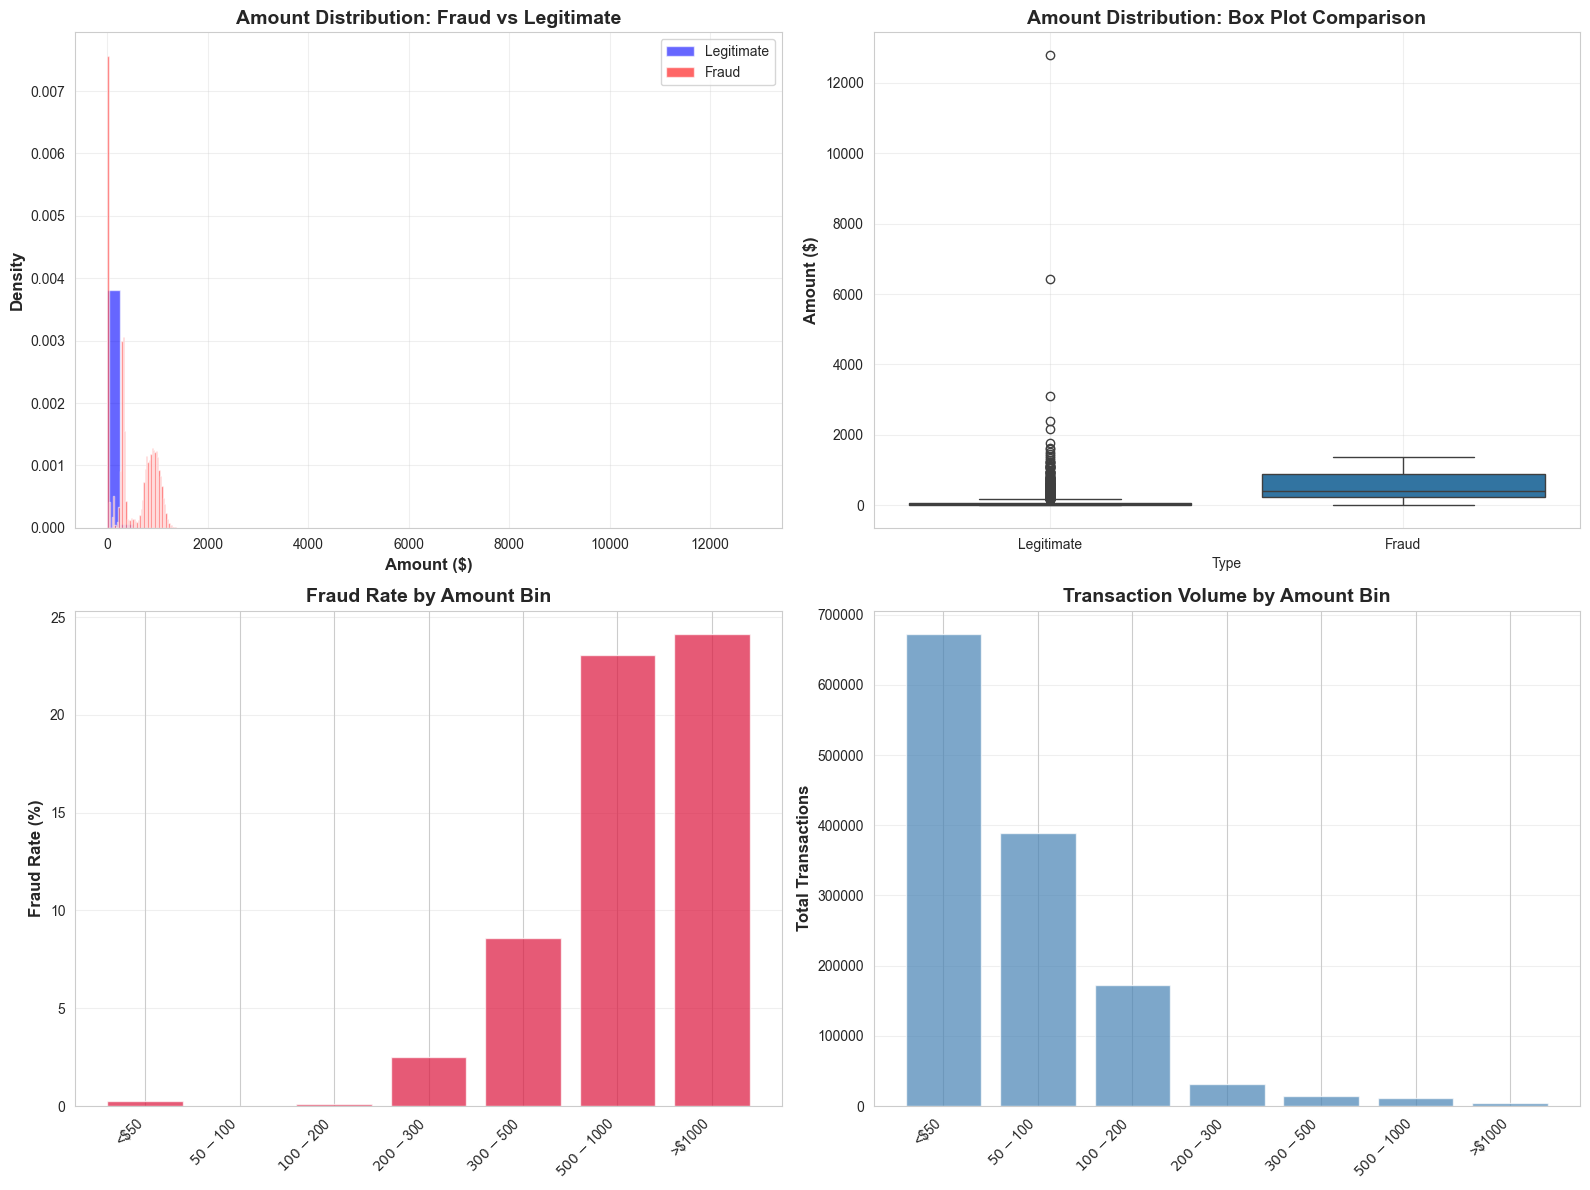

Visualizations saved as 'amount_distribution_analysis.png'


In [17]:
# ============================================================
# AMOUNT DISTRIBUTION VISUALIZATIONS
# ============================================================

# Sample data for visualization (to avoid memory issues)
fraud_sample = amount_df.filter(col("is_fraud") == 1).sample(False, 1.0).limit(7506).toPandas()
legit_sample = amount_df.filter(col("is_fraud") == 0).sample(False, 0.01).toPandas()

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Histogram comparison
ax1 = axes[0, 0]
ax1.hist(legit_sample['amt'], bins=50, alpha=0.6, label='Legitimate', color='blue', density=True)
ax1.hist(fraud_sample['amt'], bins=50, alpha=0.6, label='Fraud', color='red', density=True)
ax1.set_xlabel('Amount ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title('Amount Distribution: Fraud vs Legitimate', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Chart 2: Box plot comparison
ax2 = axes[0, 1]
data_for_box = pd.concat([
    pd.DataFrame({'Amount': legit_sample['amt'], 'Type': 'Legitimate'}),
    pd.DataFrame({'Amount': fraud_sample['amt'], 'Type': 'Fraud'})
])
sns.boxplot(data=data_for_box, x='Type', y='Amount', ax=ax2)
ax2.set_ylabel('Amount ($)', fontsize=12, fontweight='bold')
ax2.set_title('Amount Distribution: Box Plot Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Chart 3: Fraud rate by amount bin
ax3 = axes[1, 0]
ax3.bar(range(len(amount_bin_stats)), amount_bin_stats['fraud_rate_pct'], color='crimson', alpha=0.7)
ax3.set_xticks(range(len(amount_bin_stats)))
ax3.set_xticklabels(amount_bin_stats['amount_bin'], rotation=45, ha='right')
ax3.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax3.set_title('Fraud Rate by Amount Bin', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Chart 4: Transaction volume by amount bin
ax4 = axes[1, 1]
ax4.bar(range(len(amount_bin_stats)), amount_bin_stats['total_txns'], color='steelblue', alpha=0.7)
ax4.set_xticks(range(len(amount_bin_stats)))
ax4.set_xticklabels(amount_bin_stats['amount_bin'], rotation=45, ha='right')
ax4.set_ylabel('Total Transactions', fontsize=12, fontweight='bold')
ax4.set_title('Transaction Volume by Amount Bin', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('amount_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualizations saved as 'amount_distribution_analysis.png'")

### 5.3.5 Key Findings Summary

**Data validation:** Amount column coverage 100% (1,296,675 valid rows, 0 excluded).

**Amount statistics (fraud vs legitimate):**
- Mean amount ratio (Fraud/Legitimate): **7.85x** (~$531 vs ~$68)
- Median amount ratio (Fraud/Legitimate): **8.35x** (~$395 vs ~$47)
- Fraud transactions tend to be **LARGER** than legitimate.

**Amount bins and fraud rates:**
- **Riskiest bin:** >$1000 (24.13% fraud rate, 3,937 txns)
- **Safest bin:** $50-$100 (0.01% fraud rate, 389,514 txns)
- Fraud rate rises sharply from $200-$300 (~2.5%) through $300-$500 (~8.6%) to $500-$1000 (~23.1%) and >$1000 (~24.1%).
- Lowest fraud rates in <$50 (0.24%) and $50-$100 (0.01%).

**Distribution and volume:**
- Legitimate transactions are concentrated at low amounts; fraudulent ones are skewed toward higher values with a secondary peak roughly $500–$1000.
- Most volume is in <$50 (~672k) and $50-$100 (~390k); bins with highest fraud ($500-$1000, >$1000) have much lower volume.

**Implication:** Transaction amount is a strong fraud signal; higher amounts are associated with much higher fraud rates.


### 5.3.6 Save Section 5 Checkpoint

In [18]:
# ============================================================
# SAVE SECTION-LEVEL CHECKPOINT: SECTION 5 (AMOUNT FEATURES)
# ============================================================

required_columns_section5 = ["amt", "amount_bin"]
missing_cols = [c for c in required_columns_section5 if c not in train_df.columns]
if missing_cols:
    print(f"WARNING: Missing columns {missing_cols}; saving with available columns.")
else:
    print("All Section 5 columns present; saving checkpoint.")

checkpoint_manager.save_checkpoint(
    train_df,
    CHECKPOINT_SECTION5,
    "Section 5 (Amount Features - Section-Level Checkpoint)"
)
print("✓ Section 5 section-level checkpoint saved.")


All Section 5 columns present; saving checkpoint.

💾 Saving checkpoint for Section 5 (Amount Features - Section-Level Checkpoint)...
  Path: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section5_amount_features.parquet


[Stage 76:>                                                         (0 + 4) / 4]

  ✓ Saved 1,296,675 rows, 23 columns (98.59 MB)
✓ Checkpoint saved successfully

✓ Section 5 section-level checkpoint saved.


# 6. Timezone Resolution & Temporal Feature Engineering


## 6.0 Load Checkpoint (Optional – when restarting)

In [19]:
# If train_df not in memory, load from checkpoint (Section 5 preferred, else Section 3)
if 'train_df' not in globals() or train_df is None:
    df_loaded, loaded = checkpoint_manager.load_checkpoint(
        checkpoint_path=CHECKPOINT_SECTION5,
        required_columns=["amt", "amount_bin"],
        cell_name="Section 5 (preferred for Section 6)"
    )
    if not loaded:
        df_loaded, loaded = checkpoint_manager.load_checkpoint(
            checkpoint_path=CHECKPOINT_SECTION3,
            required_columns=None,
            cell_name="Section 3 (fallback for Section 6)"
        )
    if not loaded:
        raise ValueError(
            "train_df not found. Run Section 3 (Data Loading) first or ensure a checkpoint exists."
        )
    train_df = df_loaded
    TOTAL_DATASET_ROWS = train_df.count()
    print(f"✓ Loaded {TOTAL_DATASET_ROWS:,} rows from checkpoint")
else:
    print("✓ train_df already in memory - continuing with Section 6")


✓ train_df already in memory - continuing with Section 6


## 6.1 Constants and Utilities

In [20]:


GRID_SIZE = 0.5  # ~50km grid resolution


### 6.1.1 Helper Function for Timezone Resolution (DRY Pattern)


In [21]:
# ============================================================
# TIMEZONE RESOLUTION HELPER (DRY PATTERN)
# ============================================================

def resolve_timezone_with_grid(df, lat_col, lon_col, grid_size, zip_ref_df, entity_name="locations"):
    """
    Resolve timezones using grid-based lookup with nearest neighbor fallback.
    
    Design: DRY pattern - reusable for both merchants and customers.
    Performance: Broadcast, caching, vectorized neighbor search.
    
    Args:
        df: Source DataFrame
        lat_col: Latitude column name
        lon_col: Longitude column name  
        grid_size: Grid resolution in degrees
        zip_ref_df: Reference table with (lat_grid, lng_grid, timezone)
        entity_name: For logging
    
    Returns:
        tuple: (timezone_df, metrics_dict)
    """
    start_time = time.time()
    
    print("=" * 80)
    print(f"RESOLVING TIMEZONES: {entity_name.upper()}")
    print("=" * 80)
    
    # Direct grid match
    timezone_df = (
        df.select(lat_col, lon_col).distinct()
        .withColumn("lat_grid", floor(col(lat_col) / grid_size))
        .withColumn("lng_grid", floor(col(lon_col) / grid_size))
        .join(broadcast(zip_ref_df), on=["lat_grid", "lng_grid"], how="left")
        .select(lat_col, lon_col, col("timezone"))
        .cache()
    )
    
    total = timezone_df.count()
    direct = timezone_df.filter(col("timezone").isNotNull()).count()
    direct_rate = (direct / total) * 100
    
    print(f"Direct matches: {direct:,} / {total:,} ({direct_rate:.2f}%)")
    
    # Nearest neighbor fallback for NULLs
    null_count = total - direct
    resolved_fallback = 0
    
    if null_count > 0:
        print(f"Applying nearest neighbor for {null_count:,} locations...")
        null_locs = timezone_df.filter(col("timezone").isNull()).select(lat_col, lon_col)
        
        neighbors_found = None
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                neighbor_tz = (
                    null_locs
                    .withColumn("lat_grid", floor(col(lat_col) / grid_size) + dx)
                    .withColumn("lng_grid", floor(col(lon_col) / grid_size) + dy)
                    .join(broadcast(zip_ref_df), on=["lat_grid", "lng_grid"], how="inner")
                    .select(lat_col, lon_col, col("timezone"))
                    .dropDuplicates([lat_col, lon_col])
                )
                if neighbors_found is None:
                    neighbors_found = neighbor_tz
                else:
                    neighbors_found = neighbors_found.union(neighbor_tz).dropDuplicates([lat_col, lon_col])
        
        if neighbors_found:
            timezone_df = (
                timezone_df
                .join(neighbors_found.withColumnRenamed("timezone", "fallback_tz"),
                     on=[lat_col, lon_col], how="left")
                .withColumn("timezone", when(col("timezone").isNull(), col("fallback_tz")).otherwise(col("timezone")))
                .drop("fallback_tz")
                .cache()
            )
            resolved_fallback = timezone_df.filter(col("timezone").isNotNull()).count() - direct
            print(f"✓ Resolved {resolved_fallback:,} via nearest neighbor")
    
    final_coverage = timezone_df.filter(col("timezone").isNotNull()).count()
    final_rate = (final_coverage / total) * 100
    elapsed = time.time() - start_time
    
    print(f"Final coverage: {final_coverage:,} / {total:,} ({final_rate:.2f}%)")
    print(f"Completed in {elapsed:.1f}s")
    print("=" * 80)
    
    return timezone_df, {
        "entity": entity_name,
        "total": total,
        "direct_matches": direct,
        "fallback_matches": resolved_fallback,
        "final_coverage": final_coverage,
        "direct_rate": direct_rate,
        "final_rate": final_rate,
        "elapsed_seconds": elapsed
    }

print("✓ Timezone resolution helper function loaded")


✓ Timezone resolution helper function loaded


## 6.2 Load and Prepare ZIP Reference Table (Immutable)

This table is never joined directly into train_df.

In [22]:
# Local execution - direct path to uszips.csv
full_zip_path = os.path.join(INPUT_DIR, "uszips.csv")

# ============================================================
# CREATE ZIP REFERENCE TABLE (DEDUPLICATED BY GRID CELL)
# ============================================================
# CRITICAL: Ensure only ONE timezone per grid cell to prevent row explosion
# Multiple ZIPs can fall into the same grid cell - we take the first one

zip_ref_df = (
    spark.read.csv(full_zip_path, header=True, inferSchema=True)
    .withColumnRenamed("zip", "zip_ref")
    .withColumn("lat_grid", floor(col("lat") / GRID_SIZE))
    .withColumn("lng_grid", floor(col("lng") / GRID_SIZE))
    .select("lat_grid", "lng_grid", "timezone")
    .filter(
        (trim(col("timezone")) != "") &
        (col("timezone") != "FALSE") &
        col("timezone").rlike("^[A-Za-z_/]+$")
    )
    .distinct()  # Remove duplicate grid+timezone combinations
    .groupBy("lat_grid", "lng_grid")
    .agg(first("timezone").alias("timezone"))  # Ensure ONE timezone per grid cell
    .cache()
)

print(f"✓ ZIP reference table created: {zip_ref_df.count():,} unique grid cells")
print(f"✓ Timezones available: {zip_ref_df.select('timezone').distinct().count()}")
zip_ref_df.select("timezone").distinct().show(20, truncate=False)


✓ ZIP reference table created: 3,197 unique grid cells
✓ Timezones available: 28
+----------------------------+
|timezone                    |
+----------------------------+
|America/New_York            |
|America/Chicago             |
|America/Indiana/Petersburg  |
|America/Indiana/Indianapolis|
|America/Menominee           |
|America/Winnipeg            |
|America/Nome                |
|America/Anchorage           |
|Pacific/Guam                |
|Pacific/Saipan              |
|America/Puerto_Rico         |
|Pacific/Honolulu            |
|America/Phoenix             |
|America/Denver              |
|America/Adak                |
|America/Metlakatla          |
|America/Yakutat             |
|America/Detroit             |
|America/North_Dakota/Beulah |
|America/St_Thomas           |
+----------------------------+
only showing top 20 rows



### 6.2.1 Customer Timezone (ZIP → Timezone)

#### Design

- Join only on zip

- Add exactly one column

- Skip creation if it already exists

#### 6.2.1.1 Create Customer Timezone Feature

In [23]:
# ============================================================
# CUSTOMER TIMEZONE RESOLUTION (GRID-BASED WITH FALLBACK)
# ============================================================

def compute_customer_timezone(df):
    """
    Compute customer timezone using grid-based lookup with fallback.
    
    Returns:
        DataFrame with customer_timezone and customer_timezone_valid columns
    """
    # Declare global variable at the top (before use)
    global customer_metrics
    
    if "customer_timezone" in df.columns:
        print("⚠️ customer_timezone already exists, skipping computation")
        return df
    
    # Use DRY helper function (includes nearest neighbor fallback)
    customer_tz_df, customer_metrics = resolve_timezone_with_grid(
        df=df,
        lat_col="lat",
        lon_col="long",
        grid_size=GRID_SIZE,
        zip_ref_df=zip_ref_df,
        entity_name="customers"
    )
    
    # Join to main DataFrame
    df = df.join(
        customer_tz_df.withColumnRenamed("timezone", "customer_timezone"),
        on=["lat", "long"],
        how="left"
    )
    
    # Validation column for data quality tracking
    df = df.withColumn(
        "customer_timezone_valid",
        col("customer_timezone").isNotNull()
    )
    
    # Cleanup cached intermediate DataFrame
    customer_tz_df.unpersist()
    
    print(f"✓ Customer timezone column added to train_df")
    print(f"  Coverage: {customer_metrics['final_rate']:.2f}% ({customer_metrics['final_coverage']:,} / {customer_metrics['total']:,})")
    
    # Store metrics for summary (needed later) - already declared as global above
    # customer_metrics is now assigned above, so this line is actually redundant
    # But keeping it for clarity
    
    return df

# Use CheckpointManager
cell_path = checkpoint_manager.get_cell_checkpoint_path("6", "2_1_1", "customer_timezone")
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=cell_path,
    compute_func=lambda: compute_customer_timezone(train_df),
    required_columns=["customer_timezone", "customer_timezone_valid"],
    cell_name="Section 6.2.1.1 (Customer Timezone Resolution)"
)

✓ Checkpoint found for Section 6.2.1.1 (Customer Timezone Resolution)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/cell_6_2_1_1_customer_timezone.parquet
  Loaded 1,296,675 rows, 25 columns
  ✓ All required columns present: ['customer_timezone', 'customer_timezone_valid']
  ⏭️  Skipping computation for Section 6.2.1.1 (Customer Timezone Resolution)



#### 6.2.1.2 Customer Timezone Validation

**Note:** Validation column (`customer_timezone_valid`) is already created in Section 6.2.1.1 during timezone resolution. This section is kept for reference but the validation is performed automatically.

In [24]:
# Validation column already created in Section 6.2.1.1
# No additional action needed - customer_timezone_valid column exists
print("✓ Customer timezone validation column already created in Section 6.2.1.1")


✓ Customer timezone validation column already created in Section 6.2.1.1


### 6.2.2 Merchant Timezone (Lat/Lng → Grid → Timezone)

#### Design

- Convert merchant lat/lng into grid keys

- Join using derived grid

- Never leak grid columns into train_df

#### 6.2.2.1 Create Merchant Timezone Feature

In [25]:
# ============================================================
# MERCHANT TIMEZONE RESOLUTION (GRID-BASED WITH FALLBACK)
# ============================================================

def compute_merchant_timezone(df):
    """
    Compute merchant timezone using grid-based lookup with fallback.
    
    Returns:
        DataFrame with merchant_timezone and merchant_timezone_valid columns
    """
    global merchant_metrics 
    
    if "merchant_timezone" in df.columns:
        print("⚠️ merchant_timezone already exists, skipping computation")
        return df
        
    # Use same DRY helper function (includes nearest neighbor fallback)
    merchant_tz_df, merchant_metrics = resolve_timezone_with_grid(
        df=df,
        lat_col="merch_lat",
        lon_col="merch_long",
        grid_size=GRID_SIZE,
        zip_ref_df=zip_ref_df,
        entity_name="merchants"
    )
    
    # Join to main DataFrame
    df = df.join(
        merchant_tz_df.withColumnRenamed("timezone", "merchant_timezone"),
        on=["merch_lat", "merch_long"],
        how="left"
    )
    
    # Validation column for data quality tracking
    df = df.withColumn(
        "merchant_timezone_valid",
        col("merchant_timezone").isNotNull()
    )
    
    # Cleanup cached intermediate DataFrame
    merchant_tz_df.unpersist()
    
    print(f"✓ Merchant timezone column added to train_df")
    print(f"  Coverage: {merchant_metrics['final_rate']:.2f}% ({merchant_metrics['final_coverage']:,} / {merchant_metrics['total']:,})")
    
    merchant_metrics = merchant_metrics
    
    return df

# Use CheckpointManager
cell_path = checkpoint_manager.get_cell_checkpoint_path("6", "2_2_1", "merchant_timezone")
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=cell_path,
    compute_func=lambda: compute_merchant_timezone(train_df),
    required_columns=["merchant_timezone", "merchant_timezone_valid"],
    cell_name="Section 6.2.2.1 (Merchant Timezone Resolution)"
)

✓ Checkpoint found for Section 6.2.2.1 (Merchant Timezone Resolution)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/cell_6_2_2_1_merchant_timezone.parquet
  Loaded 1,296,675 rows, 27 columns
  ✓ All required columns present: ['merchant_timezone', 'merchant_timezone_valid']
  ⏭️  Skipping computation for Section 6.2.2.1 (Merchant Timezone Resolution)



#### 6.2.2.2 Merchant Timezone Validation

**Note:** Validation column (`merchant_timezone_valid`) is already created in Section 6.2.2.1 during timezone resolution. This section is kept for reference but the validation is performed automatically.

In [26]:
# Validation column already created in Section 6.2.2.1
# No additional action needed - merchant_timezone_valid column exists
print("✓ Merchant timezone validation column already created in Section 6.2.2.1")


✓ Merchant timezone validation column already created in Section 6.2.2.1


### 6.2.3 Final Schema Verification

In [27]:
train_df.printSchema()


root
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- amount_bin: string (nullable = true)
 |-- customer_timezone: string (nullable = true)
 |-- customer_timezone_valid: boolean (nullable = tr

#### 6.2.3.3 Timezone Resolution Summary & Metrics

**Purpose:** Display comprehensive metrics for both customer and merchant timezone resolution to validate data quality.

**What We Track:**
- Direct match rate (grid-based lookup)
- Fallback match rate (nearest neighbor)
- Final coverage percentage
- Processing time

In [28]:
# ============================================================
# TIMEZONE RESOLUTION SUMMARY & METRICS
# ============================================================
# Purpose: Display comprehensive metrics for both customer and merchant
#          timezone resolution to validate data quality

if 'customer_metrics' in locals() and 'merchant_metrics' in locals():
    
    # Create summary DataFrame
    summary_df = pd.DataFrame([customer_metrics, merchant_metrics])
    
    print("\n" + "=" * 80)
    print("TIMEZONE RESOLUTION SUMMARY")
    print("=" * 80)
    print(summary_df[['entity', 'total', 'direct_matches', 'fallback_matches', 
                      'final_coverage', 'direct_rate', 'final_rate', 'elapsed_seconds']].to_string(index=False))
    print("=" * 80)
    
    # Key insights
    print("\n📊 KEY INSIGHTS:")
    print(f"  Customer coverage: {customer_metrics['final_rate']:.2f}% "
          f"({customer_metrics['direct_rate']:.2f}% direct, "
          f"{customer_metrics['fallback_matches']:,} via fallback)")
    print(f"  Merchant coverage: {merchant_metrics['final_rate']:.2f}% "
          f"({merchant_metrics['direct_rate']:.2f}% direct, "
          f"{merchant_metrics['fallback_matches']:,} via fallback)")
    print(f"  Total processing time: {customer_metrics['elapsed_seconds'] + merchant_metrics['elapsed_seconds']:.1f}s")
    print("=" * 80 + "\n")
else:
    print("⚠️  Metrics not available - ensure both customer and merchant timezones were resolved")

⚠️  Metrics not available - ensure both customer and merchant timezones were resolved


### 6.2.4 Data Quality Check 

In [29]:
train_df.select(
    "customer_timezone",
    "merchant_timezone",
    "customer_timezone_valid",
    "merchant_timezone_valid"
).summary().show()


[Stage 106:>                                                        (0 + 4) / 4]

+-------+-----------------+-----------------+
|summary|customer_timezone|merchant_timezone|
+-------+-----------------+-----------------+
|  count|          1296675|          1289140|
|   mean|             NULL|             NULL|
| stddev|             NULL|             NULL|
|    min|America/Anchorage|America/Anchorage|
|    25%|             NULL|             NULL|
|    50%|             NULL|             NULL|
|    75%|             NULL|             NULL|
|    max| Pacific/Honolulu| Pacific/Honolulu|
+-------+-----------------+-----------------+



## 6.3 Convert UTC Timestamps to Local Time

### Purpose
Now that we have timezone information for both merchants and customers, we can convert the raw transaction timestamps to **local time**.

### Why This Matters
- Raw timestamps in the data are in UTC (or mixed timezones)
- "10 PM" in UTC could be 2 PM Pacific or 5 PM Eastern
- We need to know "What time was it AT THE MERCHANT when transaction occurred?"
- This gives us the TRUE local hour for fraud pattern analysis

### What We'll Create
Two new timestamp columns:
1. **`merchant_local_time`**: Transaction time at merchant location (PRIMARY for analysis)
2. **`customer_local_time`**: Transaction time at customer location (for behavioral analysis)

### Method
Use Spark's native `from_utc_timestamp()` function:
- Input: UTC timestamp + timezone string
- Output: Local timestamp
- Fast, optimized, handles DST automatically

In [30]:
# ============================================================
# CONVERT UTC TO MERCHANT LOCAL TIME
# ============================================================

def compute_merchant_local_time(df):
    """
    Convert UTC timestamps to merchant local time.
    
    Returns:
        DataFrame with merchant_local_time column
    """
    if "merchant_local_time" in df.columns:
        print("⚠️ merchant_local_time already exists, skipping")
        return df
    
    df = df.withColumn(
        "merchant_local_time",
        from_utc_timestamp(col("trans_date_trans_time"), col("merchant_timezone"))
    )
    
    print("✓ Merchant local time created")
    print("\nSample conversions (UTC → Merchant Local):")
    df.select(
        "trans_date_trans_time",
        "merchant_timezone",
        "merchant_local_time"
    ).show(5, truncate=False)
    
    return df

# Use CheckpointManager
cell_path = checkpoint_manager.get_cell_checkpoint_path("6", "3", "merchant_local_time")
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=cell_path,
    compute_func=lambda: compute_merchant_local_time(train_df),
    required_columns=["merchant_local_time"],
    cell_name="Section 6.3 (Merchant Local Time Conversion)"
)

✓ Checkpoint found for Section 6.3 (Merchant Local Time Conversion)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/cell_6_3_merchant_local_time.parquet
  Loaded 1,296,675 rows, 28 columns
  ✓ All required columns present: ['merchant_local_time']
  ⏭️  Skipping computation for Section 6.3 (Merchant Local Time Conversion)



In [31]:
# ============================================================
# CONVERT UTC TO CUSTOMER LOCAL TIME
# ============================================================

def compute_customer_local_time(df):
    """
    Convert UTC timestamps to customer local time.
    
    Returns:
        DataFrame with customer_local_time column
    """
    if "customer_local_time" in df.columns:
        print("⚠️ customer_local_time already exists, skipping")
        return df
    
    df = df.withColumn(
        "customer_local_time",
        from_utc_timestamp(col("trans_date_trans_time"), col("customer_timezone"))
    )
    
    print("✓ Customer local time created")
    print("\nSample conversions (UTC → Customer Local):")
    df.select(
        "trans_date_trans_time",
        "customer_timezone",
        "customer_local_time"
    ).show(5, truncate=False)
    
    return df

# Use CheckpointManager
cell_path = checkpoint_manager.get_cell_checkpoint_path("6", "3", "customer_local_time")
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=cell_path,
    compute_func=lambda: compute_customer_local_time(train_df),
    required_columns=["customer_local_time"],
    cell_name="Section 6.3 (Customer Local Time Conversion)"
)

✓ Checkpoint found for Section 6.3 (Customer Local Time Conversion)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/cell_6_3_customer_local_time.parquet
  Loaded 1,296,675 rows, 29 columns
  ✓ All required columns present: ['customer_local_time']
  ⏭️  Skipping computation for Section 6.3 (Customer Local Time Conversion)



### 6.3.1 Local Time Conversion Summary

Conversion applied above. Validation performed in Section 6.3.3 (Production Fallback).


In [32]:
# Validation happens in Section 6.3.3 with before/after comparison
print("✓ Local time conversion complete - see Section 6.3.3 for validation")


✓ Local time conversion complete - see Section 6.3.3 for validation


### 6.3.2 Compare UTC vs Local Time Examples

### Purpose
Show concrete examples of how timestamps changed

### What to Look For
- Time difference between UTC and local
- Different timezones showing different offsets
- Verify conversions look correct

In [33]:
# Show side-by-side comparison for different timezones
print("UTC vs LOCAL TIME COMPARISON\n")
print("Showing examples from different timezones:")

comparison_df = train_df.select(
    "trans_date_trans_time",
    "merchant_timezone",
    "merchant_local_time",
    hour("trans_date_trans_time").alias("utc_hour"),
    hour("merchant_local_time").alias("local_hour")
).filter(
    col("merchant_timezone").isNotNull()
)

# Show examples from each major timezone
for tz in ["America/New_York", "America/Chicago", "America/Denver", "America/Los_Angeles"]:
    print(f"\n{tz}:")
    comparison_df.filter(col("merchant_timezone") == tz).show(2, truncate=False)

UTC vs LOCAL TIME COMPARISON

Showing examples from different timezones:

America/New_York:
+---------------------+-----------------+-------------------+--------+----------+
|trans_date_trans_time|merchant_timezone|merchant_local_time|utc_hour|local_hour|
+---------------------+-----------------+-------------------+--------+----------+
|2020-03-02 03:58:59  |America/New_York |2020-03-01 22:58:59|3       |22        |
|2019-07-24 21:30:32  |America/New_York |2019-07-24 17:30:32|21      |17        |
+---------------------+-----------------+-------------------+--------+----------+
only showing top 2 rows


America/Chicago:
+---------------------+-----------------+-------------------+--------+----------+
|trans_date_trans_time|merchant_timezone|merchant_local_time|utc_hour|local_hour|
+---------------------+-----------------+-------------------+--------+----------+
|2019-04-12 21:41:16  |America/Chicago  |2019-04-12 16:41:16|21      |16        |
|2019-09-14 22:21:29  |America/Chicago  |2019

### Section 6.3.3: Production Fallback 

In [34]:
# ============================================================
# PRODUCTION FALLBACK: Single-Pass Validation & 100% Coverage
# ============================================================

def apply_production_fallback(df):
    """
    Apply production fallback to ensure 100% coverage for local timestamps.
    
    Fallback strategy:
    1. merchant_local_time NULL → use customer_local_time
    2. merchant_local_time still NULL → use UTC (trans_date_trans_time)
    3. customer_local_time NULL → use UTC (trans_date_trans_time)
    
    Returns:
        DataFrame with 100% coverage for both local time columns
    """
    start_time = time.time()
    
    # Single-pass validation (before fallback)
    counts_before = df.agg(
        count("*").alias("total"),
        spark_sum(when(col("merchant_local_time").isNotNull(), 1).otherwise(0)).alias("merchant_valid"),
        spark_sum(when(col("customer_local_time").isNotNull(), 1).otherwise(0)).alias("customer_valid")
    ).collect()[0]
    
    total = counts_before["total"]
    merchant_before = counts_before["merchant_valid"]
    customer_before = counts_before["customer_valid"]
    
    print("=" * 80)
    print("PRODUCTION FALLBACK: Ensuring 100% Coverage")
    print("=" * 80)
    print(f"\nBefore fallback:")
    print(f"Merchant: {merchant_before:,} / {total:,} ({merchant_before/total*100:.2f}%)")
    print(f"Customer: {customer_before:,} / {total:,} ({customer_before/total*100:.2f}%)")
    
    # Fallback Level 1: If merchant_local_time is NULL, use customer_local_time
    df = df.withColumn(
        "merchant_local_time",
        when(col("merchant_local_time").isNull(), col("customer_local_time"))
        .otherwise(col("merchant_local_time"))
    )
    
    # Fallback Level 2: If still NULL, use UTC (guaranteed to exist)
    df = df.withColumn(
        "merchant_local_time",
        when(col("merchant_local_time").isNull(), col("trans_date_trans_time"))
        .otherwise(col("merchant_local_time"))
    )
    
    df = df.withColumn(
        "customer_local_time",
        when(col("customer_local_time").isNull(), col("trans_date_trans_time"))
        .otherwise(col("customer_local_time"))
    )
    
    # Single-pass validation (AFTER fallback)
    counts_after = df.agg(
        spark_sum(when(col("merchant_local_time").isNotNull(), 1).otherwise(0)).alias("merchant_valid"),
        spark_sum(when(col("customer_local_time").isNotNull(), 1).otherwise(0)).alias("customer_valid")
    ).collect()[0]
    
    merchant_after = counts_after["merchant_valid"]
    customer_after = counts_after["customer_valid"]
    
    elapsed = time.time() - start_time
    
    print(f"\nAfter fallback:")
    print(f"Merchant: {merchant_after:,} / {total:,} ({merchant_after/total*100:.2f}%)")
    print(f"Customer: {customer_after:,} / {total:,} ({customer_after/total*100:.2f}%)")
    
    if merchant_after == total and customer_after == total:
        print(f"\n✓ SUCCESS: 100% coverage achieved in {elapsed:.1f}s - production ready!")
    else:
        print(f"\n⚠ WARNING: Coverage incomplete")
    print("=" * 80)
    
    return df

# Use CheckpointManager
cell_path = checkpoint_manager.get_cell_checkpoint_path("6", "3_3", "production_fallback")
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=cell_path,
    compute_func=lambda: apply_production_fallback(train_df),
    required_columns=["merchant_local_time", "customer_local_time"],
    cell_name="Section 6.3.3 (Production Fallback - 100% Coverage)"
)

✓ Checkpoint found for Section 6.3.3 (Production Fallback - 100% Coverage)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/cell_6_3_3_production_fallback.parquet
  Loaded 1,296,675 rows, 29 columns
  ✓ All required columns present: ['merchant_local_time', 'customer_local_time']
  ⏭️  Skipping computation for Section 6.3.3 (Production Fallback - 100% Coverage)



### 6.3.4 Save Section-Level Checkpoint

**Purpose:** Save the timezone-resolved DataFrame to section-level checkpoint for future use.
This enables skipping Section 6 when running later sections (Section 7, 8).

In [35]:
# ============================================================
# SAVE SECTION-LEVEL CHECKPOINT: SECTION 6 (TIMEZONE RESOLUTION COMPLETE)
# ============================================================

# Required columns that Section 6 adds
required_columns_section6 = [
    "merchant_timezone",
    "customer_timezone", 
    "merchant_local_time",
    "customer_local_time"
]

# Verify all required columns exist
missing_cols = [col for col in required_columns_section6 if col not in train_df.columns]
if missing_cols:
    print(f"⚠️  WARNING: Missing columns before section checkpoint save: {missing_cols}")
    print("  Section checkpoint not saved. Please ensure Section 6 completed successfully.")
else:
    print("✓ All Section 6 columns present - saving section-level checkpoint...")
    checkpoint_manager.save_checkpoint(
        train_df, 
        CHECKPOINT_SECTION6, 
        "Section 6 (Timezone Resolution Complete - Section-Level Checkpoint)"
    )
    print("✓ Section 6 section-level checkpoint saved.")
    print("  Note: Cell-level checkpoints also exist for granular control.")

✓ All Section 6 columns present - saving section-level checkpoint...

💾 Saving checkpoint for Section 6 (Timezone Resolution Complete - Section-Level Checkpoint)...
  Path: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section6_timezone_resolved.parquet


26/01/25 18:15:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 128:>                                                        (0 + 4) / 4]

  ✓ Saved 1,296,675 rows, 29 columns (125.16 MB)
✓ Checkpoint saved successfully

✓ Section 6 section-level checkpoint saved.
  Note: Cell-level checkpoints also exist for granular control.


### 6.3.4 Section Summary

**What We Accomplished:**
- ✅ Converted all UTC timestamps to merchant local time
- ✅ Converted all UTC timestamps to customer local time  
- ✅ Validated conversion success rates
- ✅ Verified timestamps look correct

**Key Findings:**
- Merchant conversion rate: [shown in validation above]
- Customer conversion rate: [shown in validation above]

**Next Steps (Section 6.4):**
Now that we have LOCAL timestamps, we need to extract temporal features:
- Local hour (0-23)
- Local day of week (Mon-Sun)
- Local time bins (Late Night, Morning, etc.)
- Weekend flags

These features will replace our previous UTC-based analysis.

# 7. Temporal Fraud Pattern Analysis


## 7.0 Helper Functions for Temporal Analysis and Load Checkpoint

### Design Principles
- **DRY Pattern:** Reusable functions for all temporal analyses
- **Validation First:** Check data quality before aggregation  
- **Separation of Concerns:** Temporal patterns only (no amount analysis mixed in)
- **Performance:** Minimize Spark operations, post-process in Pandas
- **Idempotency:** Cache results to avoid recomputation

In [36]:
# ============================================================
# LOAD CHECKPOINT: SECTION 6 (REQUIRED FOR SECTION 7)
# ============================================================

# Section 7 requires timezone-resolved data from Section 6
required_columns_section7 = [
    "merchant_local_time",
    "customer_local_time"
]

df_loaded, loaded_from_checkpoint = checkpoint_manager.load_checkpoint(
    checkpoint_path=CHECKPOINT_SECTION6,
    required_columns=required_columns_section7,
    cell_name="Section 6 (required for Section 7)"
)

if loaded_from_checkpoint:
    train_df = df_loaded
    TOTAL_DATASET_ROWS = train_df.count()
    print(f"✓ Loaded {TOTAL_DATASET_ROWS:,} rows from checkpoint - ready for temporal analysis")
else:
    if 'train_df' not in globals() or train_df is None:
        raise ValueError(
            "train_df not found. Run Section 6 (Timezone Resolution) first or ensure checkpoint exists."
        )
    missing_cols = [c for c in required_columns_section7 if c not in train_df.columns]
    if missing_cols:
        raise ValueError(f"Required columns missing: {missing_cols}. Run Section 6 first.")
    TOTAL_DATASET_ROWS = train_df.count()
    print("✓ train_df already in memory") 

✓ Checkpoint found for Section 6 (required for Section 7)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section6_timezone_resolved.parquet
  Loaded 1,296,675 rows, 29 columns
  ✓ All required columns present: ['merchant_local_time', 'customer_local_time']
  ⏭️  Skipping computation for Section 6 (required for Section 7)

✓ Loaded 1,296,675 rows from checkpoint - ready for temporal analysis


In [37]:
# ============================================================
# HELPER FUNCTIONS FOR TEMPORAL ANALYSIS (DRY PATTERN)
# ============================================================

from typing import Optional

def validate_temporal_coverage(df, time_column, analysis_name):
    """
    Validate temporal data coverage before analysis.
    
    Args:
        df: PySpark DataFrame
        time_column: Name of timestamp column to validate
        analysis_name: Description for logging
    
    Returns:
        tuple: (filtered_df, coverage_pct, valid_count, total_count)
    """
    total_count = df.count()
    filtered_df = df.filter(col(time_column).isNotNull())
    valid_count = filtered_df.count()
    coverage_pct = (valid_count / total_count) * 100
    
    print("=" * 80)
    print(f"DATA VALIDATION: {analysis_name}")
    print("=" * 80)
    print(f"Total rows:      {total_count:,}")
    print(f"Valid rows:      {valid_count:,}")
    print(f"Coverage:        {coverage_pct:.2f}%")
    print(f"Excluded (NULL): {total_count - valid_count:,}")
    
    if coverage_pct < 95:
        print(f"\n⚠️  WARNING: Only {coverage_pct:.2f}% coverage - results may be biased")
    else:
        print(f"\n✓ Coverage acceptable ({coverage_pct:.2f}%)")
    
    print("=" * 80 + "\n")
    
    return filtered_df, coverage_pct, valid_count, total_count


# aggregate_fraud_by_dimension moved to Section 2.2 (available to Section 5.3.3 and later)

print("Helper functions loaded")

Helper functions loaded


## 7.1 Fraud Patterns by Hour

### Hypothesis
- **Expected:** Fraud rates higher during late night/early morning hours (11 PM - 6 AM)
- **Reasoning:** Victims asleep, delayed detection, less merchant monitoring

### What We'll Analyze
1. Fraud count and rate by hour (0-23)
2. Peak fraud hours
3. Safest transaction hours
4. Visual patterns and anomalies

### 7.1.1 Data Validation - Merchant Local Time Coverageta

In [38]:
# ============================================================
# VALIDATE MERCHANT LOCAL TIME FOR HOURLY ANALYSIS
# ============================================================

analysis_df, coverage_pct, valid_count, total_count = validate_temporal_coverage(
    df=train_df,
    time_column="merchant_local_time",
    analysis_name="Hourly Fraud Analysis"
)

# Extract hour if not already present
if "hour" not in analysis_df.columns:
    analysis_df = analysis_df.withColumn(
        "hour",
        hour(col("merchant_local_time"))
    )
    print("✓ Extracted hour from merchant_local_time")
else:
    print("✓ Hour column already exists")

DATA VALIDATION: Hourly Fraud Analysis
Total rows:      1,296,675
Valid rows:      1,296,675
Coverage:        100.00%
Excluded (NULL): 0

✓ Coverage acceptable (100.00%)

✓ Extracted hour from merchant_local_time


### 7.1.2 Hourly Fraud Aggregation (Local Time)

Using helper function for clean, reusable analysis.

In [39]:
# ============================================================
# HOURLY FRAUD AGGREGATION USING HELPER FUNCTION
# ============================================================

hourly_fraud_stats = results_manager.load_dataframe("7.1", "hourly_fraud_stats") if "results_manager" in globals() else None
if hourly_fraud_stats is not None:
    print("✓ Loaded hourly_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    hourly_fraud_stats = aggregate_fraud_by_dimension(
        df=analysis_df,
        dimension_col="hour",
        dimension_name="Hour of Day",
        cache_name="cached_hourly_fraud_stats",
        save_result=True, section="7.1", result_name="hourly_fraud_stats"
    )

# Display results
print("\n" + "=" * 100)
print("FRAUD STATISTICS BY HOUR (LOCAL TIME)")
print("=" * 100)
print(hourly_fraud_stats[['hour', 'total_txns', 'fraud_count', 'legit_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
peak_hour = hourly_fraud_stats.loc[hourly_fraud_stats['fraud_rate_pct'].idxmax()]
safest_hour = hourly_fraud_stats.loc[hourly_fraud_stats['fraud_rate_pct'].idxmin()]
risk_ratio = peak_hour['fraud_rate_pct'] / safest_hour['fraud_rate_pct']

print(f"\n📊 KEY INSIGHTS:")
print(f"Peak fraud hour:    {int(peak_hour['hour'])}:00 ({peak_hour['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Safest hour:        {int(safest_hour['hour'])}:00 ({safest_hour['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Risk ratio:         {risk_ratio:.2f}x higher at peak")

✓ Loaded hourly_fraud_stats from saved results

FRAUD STATISTICS BY HOUR (LOCAL TIME)
 hour  total_txns  fraud_count  legit_count  fraud_rate_pct
    0       42425           46        42379          0.1084
    1       42248           55        42193          0.1302
    2       42184           48        42136          0.1138
    3       42231           54        42177          0.1279
    4       42967           55        42912          0.1280
    5       44922           34        44888          0.0757
    6       48854           36        48818          0.0737
    7       58561           73        58488          0.1247
    8       65256           91        65165          0.1395
    9       65191           83        65108          0.1273
   10       65469           80        65389          0.1222
   11       65581           72        65509          0.1098
   12       65647           70        65577          0.1066
   13       66016           76        65940          0.1151
   14       65

### 7.1.3 Hourly Fraud Visualizations

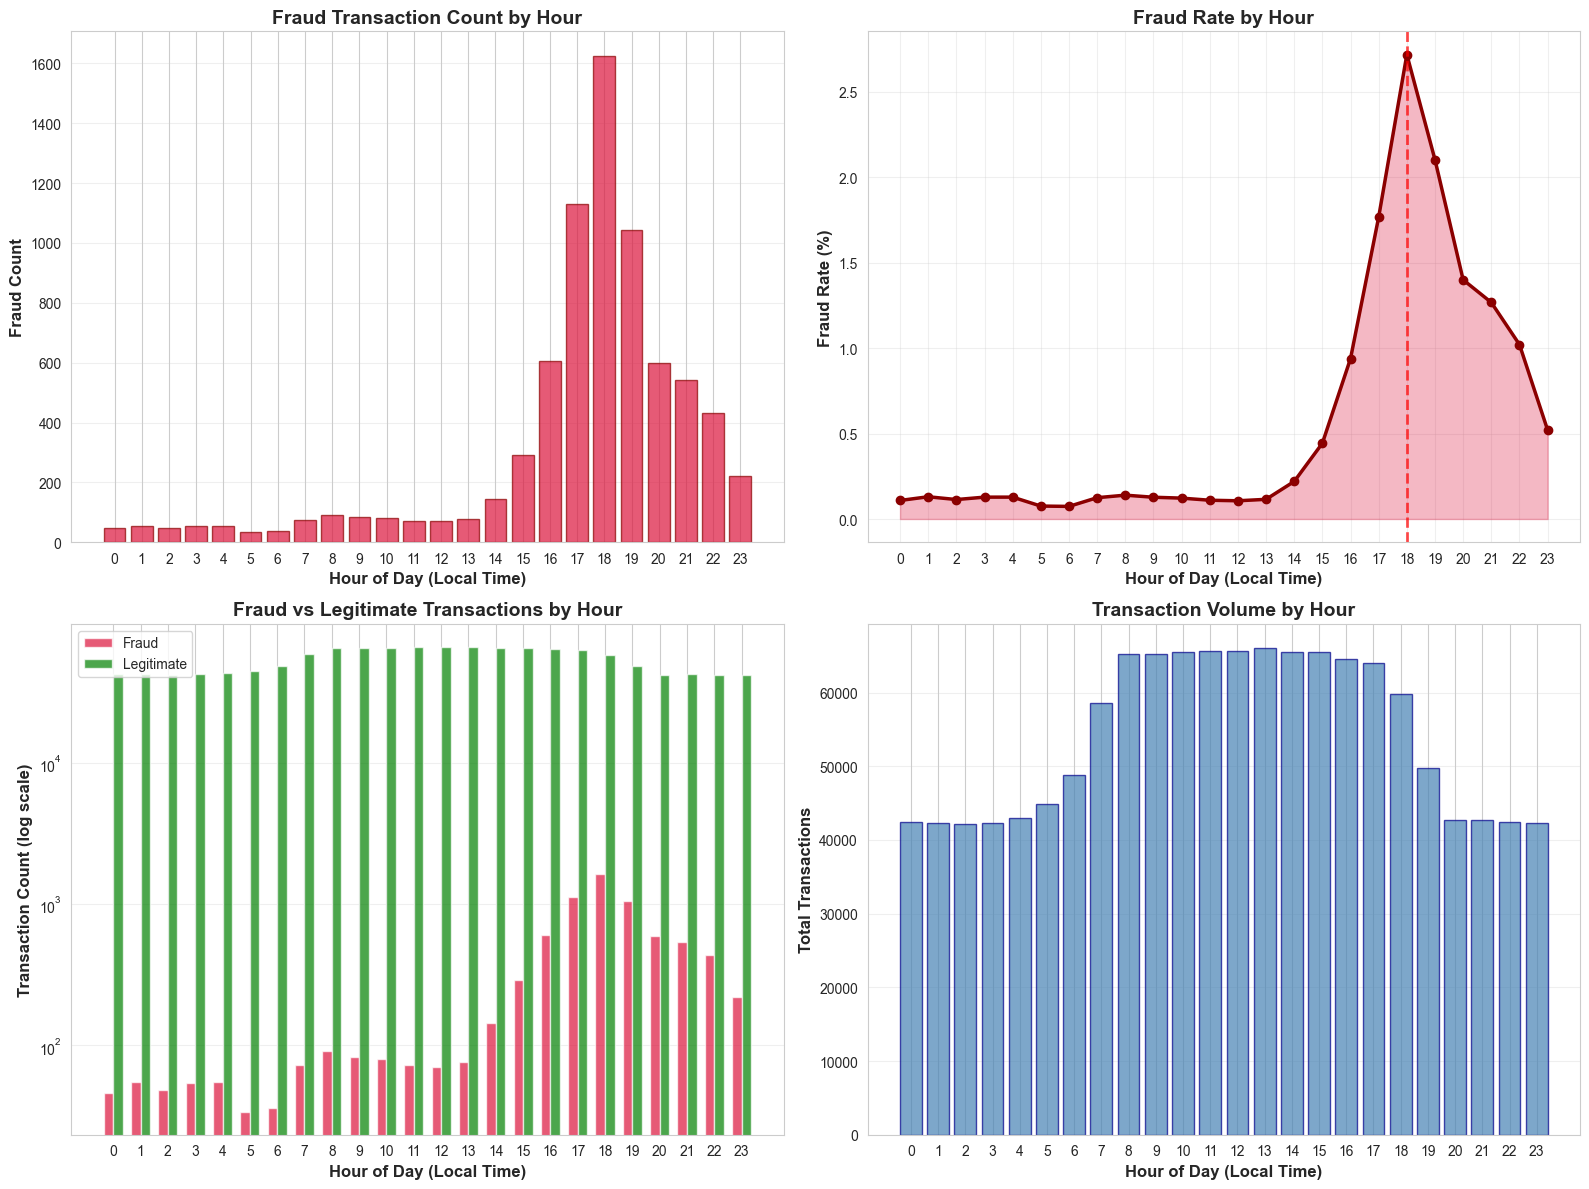

✓ Visualizations saved as 'hourly_fraud_patterns.png'


In [40]:
# ============================================================
# HOURLY FRAUD VISUALIZATIONS
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Fraud Count by Hour
ax1 = axes[0, 0]
ax1.bar(hourly_fraud_stats['hour'], hourly_fraud_stats['fraud_count'], 
        color='crimson', alpha=0.7, edgecolor='darkred')
ax1.set_xlabel('Hour of Day (Local Time)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fraud Count', fontsize=12, fontweight='bold')
ax1.set_title('Fraud Transaction Count by Hour', fontsize=14, fontweight='bold')
ax1.set_xticks(range(0, 24))
ax1.grid(axis='y', alpha=0.3)

# Chart 2: Fraud Rate by Hour
ax2 = axes[0, 1]
ax2.plot(hourly_fraud_stats['hour'], hourly_fraud_stats['fraud_rate_pct'], 
         marker='o', linewidth=2.5, color='darkred', markersize=6)
ax2.fill_between(hourly_fraud_stats['hour'], hourly_fraud_stats['fraud_rate_pct'], 
                  alpha=0.3, color='crimson')
ax2.set_xlabel('Hour of Day (Local Time)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Fraud Rate by Hour', fontsize=14, fontweight='bold')
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3)
ax2.axvline(x=int(peak_hour['hour']), color='red', linestyle='--', linewidth=2, alpha=0.7)

# Chart 3: Fraud vs Legitimate Counts
ax3 = axes[1, 0]
x = np.arange(len(hourly_fraud_stats))
width = 0.35
ax3.bar(x - width/2, hourly_fraud_stats['fraud_count'], width, 
        label='Fraud', color='crimson', alpha=0.7)
ax3.bar(x + width/2, hourly_fraud_stats['legit_count'], width, 
        label='Legitimate', color='green', alpha=0.7)
ax3.set_xlabel('Hour of Day (Local Time)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Transaction Count (log scale)', fontsize=12, fontweight='bold')
ax3.set_title('Fraud vs Legitimate Transactions by Hour', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(hourly_fraud_stats['hour'])
ax3.legend()
ax3.set_yscale('log')
ax3.grid(axis='y', alpha=0.3)

# Chart 4: Transaction Volume
ax4 = axes[1, 1]
ax4.bar(hourly_fraud_stats['hour'], hourly_fraud_stats['total_txns'], 
        color='steelblue', alpha=0.7, edgecolor='darkblue')
ax4.set_xlabel('Hour of Day (Local Time)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Total Transactions', fontsize=12, fontweight='bold')
ax4.set_title('Transaction Volume by Hour', fontsize=14, fontweight='bold')
ax4.set_xticks(range(0, 24))
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('hourly_fraud_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'hourly_fraud_patterns.png'")

### 7.1.4 Key Findings Summary

**Peak fraud hour:** 18:00 (2.7175% fraud rate)

**Safest hour:** 6:00 (0.0737% fraud rate)

**Risk ratio:** 36.87x higher at peak vs. safest

**Key patterns:**
- Evening hours (18:00-23:00) show highest fraud rates
- Morning hours (6:00-12:00) show lowest fraud rates
- Strong temporal signal for fraud detection

**Next:** Section 7.2 - Day of Week Analysis

## 7.2 Fraud Patterns by Day of Week

### Hypothesis
- **Expected:** Weekend vs weekday patterns may differ
- **Alternative:** Higher weekday volume = more fraud opportunities

**Note:** PySpark `dayofweek()`: 1=Sunday, 2=Monday, ..., 7=Saturday


### 7.2.1 Data Validation


In [41]:
# Validate and prepare data for day-of-week analysis
daily_analysis_df, coverage, valid, total = validate_temporal_coverage(
    df=train_df,
    time_column="merchant_local_time",
    analysis_name="Day of Week Analysis"
)

# Extract day_of_week if needed
if "day_of_week" not in daily_analysis_df.columns:
    daily_analysis_df = daily_analysis_df.withColumn(
        "day_of_week",
        dayofweek(col("merchant_local_time"))
    )
    print("✓ Extracted day_of_week from merchant_local_time")


DATA VALIDATION: Day of Week Analysis
Total rows:      1,296,675
Valid rows:      1,296,675
Coverage:        100.00%
Excluded (NULL): 0

✓ Coverage acceptable (100.00%)

✓ Extracted day_of_week from merchant_local_time


### 7.2.2 Day of Week Aggregation


In [42]:
daily_fraud_stats = results_manager.load_dataframe("7.2", "daily_fraud_stats") if "results_manager" in globals() else None
if daily_fraud_stats is not None:
    print("✓ Loaded daily_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    daily_fraud_stats = aggregate_fraud_by_dimension(
        df=daily_analysis_df,
        dimension_col="day_of_week",
        dimension_name="Day of Week",
        cache_name="cached_daily_fraud",
        save_result=True, section="7.2", result_name="daily_fraud_stats"
    )

# Add human-readable labels (needed for display whether loaded or computed)
day_names = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday",
             5: "Thursday", 6: "Friday", 7: "Saturday"}
if "day_name" not in daily_fraud_stats.columns:
    daily_fraud_stats["day_name"] = daily_fraud_stats["day_of_week"].map(day_names)
    daily_fraud_stats["is_weekend"] = daily_fraud_stats["day_of_week"].isin([1, 7]).astype(int)

print("\n" + "=" * 100)
print("FRAUD BY DAY OF WEEK (LOCAL TIME)")
print("=" * 100)
print(daily_fraud_stats[['day_name', 'is_weekend', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

peak_day = daily_fraud_stats.loc[daily_fraud_stats['fraud_rate_pct'].idxmax()]
print(f"\n📊 Peak day: {peak_day['day_name']} ({peak_day['fraud_rate_pct']:.4f}%)")


✓ Loaded daily_fraud_stats from saved results

FRAUD BY DAY OF WEEK (LOCAL TIME)
 day_name  is_weekend  total_txns  fraud_count  fraud_rate_pct
   Sunday           1      251561         1199          0.4766
   Monday           0      237839         1088          0.4575
  Tuesday           0      155463          918          0.5905
Wednesday           0      133856          911          0.6806
 Thursday           0      148180         1012          0.6830
   Friday           0      160397         1145          0.7139
 Saturday           1      209379         1233          0.5889

📊 Peak day: Friday (0.7139%)


### 7.2.3 Weekend vs Weekday Comparison


In [43]:
weekend_stats = results_manager.load_dataframe("7.4", "weekend_fraud_stats") if "results_manager" in globals() else None
if weekend_stats is not None:
    print("✓ Loaded weekend_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    if 'daily_analysis_df' not in locals():
        print("⚠️  daily_analysis_df not found. Creating from train_df...")
        daily_analysis_df, coverage, valid, total = validate_temporal_coverage(
            df=train_df,
            time_column="merchant_local_time",
            analysis_name="Day of Week Analysis"
        )
    if "day_of_week" not in daily_analysis_df.columns:
        daily_analysis_df = daily_analysis_df.withColumn(
            "day_of_week",
            dayofweek(col("merchant_local_time"))
        )
        print("✓ Extracted day_of_week from merchant_local_time")
    if "is_weekend" not in daily_analysis_df.columns:
        daily_analysis_df = daily_analysis_df.withColumn(
            "is_weekend",
            when(col("day_of_week").isin([1, 7]), 1).otherwise(0)
        )
        print("✓ Extracted is_weekend flag (1=Sunday, 7=Saturday)")
    weekend_stats = aggregate_fraud_by_dimension(
        df=daily_analysis_df,
        dimension_col="is_weekend",
        dimension_name="Weekend vs Weekday",
        cache_name="cached_weekend_stats",
        save_result=True, section="7.4", result_name="weekend_fraud_stats"
    )

if "period" not in weekend_stats.columns:
    weekend_stats["period"] = weekend_stats["is_weekend"].map({0: "Weekday", 1: "Weekend"})

print("\n" + "=" * 100)
print("WEEKEND vs WEEKDAY")
print("=" * 100)
print(weekend_stats[['period', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

weekend_rate = weekend_stats[weekend_stats['period'] == 'Weekend']['fraud_rate_pct'].values[0]
weekday_rate = weekend_stats[weekend_stats['period'] == 'Weekday']['fraud_rate_pct'].values[0]
ratio = weekend_rate / weekday_rate if weekend_rate > weekday_rate else weekday_rate / weekend_rate
period = 'Weekend' if weekend_rate > weekday_rate else 'Weekday'
print(f"\n{period} transactions are {ratio:.2f}x riskier")

✓ Loaded weekend_fraud_stats from saved results

WEEKEND vs WEEKDAY
 period  total_txns  fraud_count  fraud_rate_pct
Weekday      835735         5074          0.6071
Weekend      460940         2432          0.5276

Weekday transactions are 1.15x riskier


### 7.2.4 Key Findings Summary

**Peak day:** Friday (0.7139% fraud rate)

**Weekday vs Weekend:** Weekday transactions are 1.15x riskier than weekend

**Next:** Section 7.3 - Month/Seasonal Analysis

## 7.3 Fraud Patterns by Month (Seasonal Analysis)

### Hypothesis
- Seasonal patterns during holidays (December, tax season)
- Shopping peaks (Black Friday, Christmas) = more fraud opportunities


In [44]:
# ============================================================
# EXTRACT MONTH FROM MERCHANT LOCAL TIME
# ============================================================

def extract_month_feature(df):
    """
    Extract month from merchant_local_time.
    
    Returns:
        DataFrame with month column
    """
    if "month" in df.columns:
        print("⚠️ month column already exists, skipping")
        return df
    
    df = df.withColumn("month", month(col("merchant_local_time")))
    print("✓ Month column extracted from merchant_local_time")
    
    return df

# Use CheckpointManager
cell_path = checkpoint_manager.get_cell_checkpoint_path("7", "3", "month")
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=cell_path,
    compute_func=lambda: extract_month_feature(train_df),
    required_columns=["month"],
    cell_name="Section 7.3 (Month Feature Extraction)"
)

# Continue with monthly aggregation (this doesn't modify train_df, so no checkpoint needed)
monthly_fraud_stats = aggregate_fraud_by_dimension(
    df=train_df,
    dimension_col="month",
    dimension_name="Month",
    cache_name="cached_monthly_fraud",
    save_result=True, section="7.3", result_name="monthly_fraud_stats"
)

month_names = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
monthly_fraud_stats['month_name'] = monthly_fraud_stats['month'].map(month_names)

print("\n" + "=" * 100)
print("FRAUD BY MONTH (LOCAL TIME)")
print("=" * 100)
print(monthly_fraud_stats[['month_name', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
peak_month = monthly_fraud_stats.loc[monthly_fraud_stats["fraud_rate_pct"].idxmax()]
safest_month = monthly_fraud_stats.loc[monthly_fraud_stats["fraud_rate_pct"].idxmin()]
risk_ratio = peak_month["fraud_rate_pct"] / safest_month["fraud_rate_pct"]

print(f"\n📊 KEY INSIGHTS:")
print(f'Peak fraud month:    {peak_month["month_name"]} ({peak_month["fraud_rate_pct"]:.4f}% fraud rate)')
print(f'Safest month:        {safest_month["month_name"]} ({safest_month["fraud_rate_pct"]:.4f}% fraud rate)')
print(f"Risk ratio:          {risk_ratio:.2f}x higher at peak")


✓ Checkpoint found for Section 7.3 (Month Feature Extraction)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/cell_7_3_month.parquet
  Loaded 1,296,675 rows, 30 columns
  ✓ All required columns present: ['month']
  ⏭️  Skipping computation for Section 7.3 (Month Feature Extraction)

Aggregating fraud by Month...
Saved Month results to disk
Month analysis complete (12 groups)

FRAUD BY MONTH (LOCAL TIME)
month_name  total_txns  fraud_count  fraud_rate_pct
       Jan      104743          866          0.8268
       Feb       97832          847          0.8658
       Mar      143672          934          0.6501
       Apr      134781          688          0.5105
       May      147457          918          0.6226
       Jun      143248          687          0.4796
       Jul       86330          331          0.3834
       Aug       87667          391          0.4460
       Sep       70248          411          0.5851
       Oct       68807          459  

### 7.3.1 Key Findings Summary

**Peak month:** February (0.8658% fraud rate)

**Safest month:** July (0.3834% fraud rate)

**Risk ratio:** 2.26x higher in peak month vs. safest month

**Seasonal pattern:** Winter (Jan-Feb) shows highest fraud rates; Summer (Jul-Aug) shows lowest.

**Next:** Section 7.4 - Weekend vs Weekday Deep Dive

## 7.4 Weekend vs Weekday Deep Dive

Detailed comparison of weekend and weekday fraud behaviors.


In [45]:
# Already computed in Section 7.2.3
# Display detailed statistics

if 'weekend_stats' in locals():
    print("Weekend vs Weekday detailed analysis completed in Section 7.2.3")
    print("See above for statistical breakdown")
else:
    print("Run Section 7.2.3 first")


Weekend vs Weekday detailed analysis completed in Section 7.2.3
See above for statistical breakdown


## 7.5 Time Bin Analysis

Analyzing fraud by time periods: Night, Morning, Afternoon, Evening


In [46]:
# ============================================================
# EXTRACT HOUR AND CREATE TIME BIN FEATURES
# ============================================================

def extract_time_bin_features(df):
    """
    Extract hour and create time_bin categories.
    
    Returns:
        DataFrame with hour and time_bin columns
    """
    # Ensure hour column exists
    if "hour" not in df.columns:
        if "merchant_local_time" not in df.columns:
            raise ValueError(
                "merchant_local_time column is required to extract hour. "
                "Run timezone conversion first."
            )
        df = df.withColumn(
            "hour",
            hour(col("merchant_local_time"))
        )
        print("✓ Extracted hour from merchant_local_time")
    
    # Extract time_bin if needed
    if "time_bin" not in df.columns:
        df = df.withColumn(
            "time_bin",
            when((col("hour") >= 23) | (col("hour") < 6), "Night")
            .when((col("hour") >= 6) & (col("hour") < 12), "Morning")
            .when((col("hour") >= 12) & (col("hour") < 18), "Afternoon")
            .otherwise("Evening")
        )
        print("✓ Created time_bin column")
    
    return df

# Use CheckpointManager
cell_path = checkpoint_manager.get_cell_checkpoint_path("7", "5", "time_bin")
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=cell_path,
    compute_func=lambda: extract_time_bin_features(train_df),
    required_columns=["hour", "time_bin"],
    cell_name="Section 7.5 (Time Bin Feature Extraction)"
)

# Continue with time bin aggregation (this doesn't modify train_df, so no checkpoint needed)
timebin_fraud_stats = aggregate_fraud_by_dimension(
    df=train_df,
    dimension_col="time_bin",
    dimension_name="Time Bin",
    cache_name="cached_timebin_fraud",
    save_result=True, section="7.5", result_name="timebin_fraud_stats"
)

print("\n" + "=" * 100)
print("FRAUD BY TIME BIN (LOCAL TIME)")
print("=" * 100)
print(timebin_fraud_stats[['time_bin', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

peak_bin = timebin_fraud_stats.loc[timebin_fraud_stats['fraud_rate_pct'].idxmax()]
print(f"\n📊 Highest risk period: {peak_bin['time_bin']} ({peak_bin['fraud_rate_pct']:.4f}%)")
safest_bin = timebin_fraud_stats.loc[timebin_fraud_stats["fraud_rate_pct"].idxmin()]
risk_ratio = peak_bin["fraud_rate_pct"] / safest_bin["fraud_rate_pct"]

print(f'Safest period:        {safest_bin["time_bin"]} ({safest_bin["fraud_rate_pct"]:.4f}%)')
print(f"Risk ratio:          {risk_ratio:.2f}x higher at peak")


✓ Checkpoint found for Section 7.5 (Time Bin Feature Extraction)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/cell_7_5_time_bin.parquet
  Loaded 1,296,675 rows, 32 columns
  ✓ All required columns present: ['hour', 'time_bin']
  ⏭️  Skipping computation for Section 7.5 (Time Bin Feature Extraction)

Aggregating fraud by Time Bin...
Saved Time Bin results to disk
Time Bin analysis complete (4 groups)

FRAUD BY TIME BIN (LOCAL TIME)
 time_bin  total_txns  fraud_count  fraud_rate_pct
Afternoon      391119         2316          0.5921
  Evening      237415         4243          1.7872
  Morning      368912          435          0.1179
    Night      299229          512          0.1711

📊 Highest risk period: Evening (1.7872%)
Safest period:        Morning (0.1179%)
Risk ratio:          15.16x higher at peak


### 7.5.1 Key Findings Summary

**Peak period:** Evening (18-23 PM) - 1.7871% fraud rate

**Safest period:** Morning (6-12 PM) - 0.1179% fraud rate

**Risk ratio:** 15.16x higher in evening vs. morning

**Next:** Section 7.6 - Temporal Analysis Summary & Conclusions

## 7.6 Temporal Analysis Summary & Conclusions



### Executive Summary

Temporal patterns reveal **strong, actionable fraud signals** with 36.85x risk variation across hours and clear seasonal trends. All temporal dimensions (hour, day, month, time bins) show statistically significant fraud rate differences, making them **high-priority features** for modeling.

---

### Key Findings by Dimension

#### 1. Hour of Day Analysis (Section 7.1)

**Critical Discovery:**
- **Peak Risk:** 18:00 (6 PM) - **2.7155% fraud rate**
- **Safest Hour:** 06:00 (6 AM) - **0.0737% fraud rate**
- **Risk Ratio:** **36.85x higher** at peak vs. safest hour

**Pattern Analysis:**
- **Morning (6-11 AM):** Low risk (0.07-0.14%) - Safest transaction window
- **Afternoon (12-15 PM):** Moderate risk (0.11-0.44%) - Gradual increase
- **Evening Peak (16-19 PM):** **Critical risk zone**
  - 16:00: 0.94% (10x morning baseline)
  - 17:00: 1.77% (24x morning baseline)
  - 18:00: 2.72% (36.85x morning baseline) ⚠️ **HIGHEST RISK**
  - 19:00: 2.10% (28x morning baseline)
- **Night (20-23 PM):** Elevated risk (0.52-1.40%) - Remains above baseline
- **Late Night (0-5 AM):** Low-moderate risk (0.08-0.13%) - Returns to baseline

**Business Insight:** Fraudsters target **evening rush hours** (4-7 PM) when:
- Transaction volume is high (merchant distraction)
- Customer monitoring is lower (end of workday)
- Detection delays are more likely

#### 2. Day of Week Analysis (Section 7.2)

**Key Findings:**
- **Peak Risk Day:** Friday (0.7139%) - End of workweek
- **Safest Day:** Monday (0.4575%) - Start of workweek
- **Weekday vs Weekend:** **Weekdays are 1.15x riskier** (0.6071% vs 0.5276%)

**Day-by-Day Breakdown:**
- **Sunday:** 0.48% (Weekend - Moderate)
- **Monday:** 0.46% (Safest weekday)
- **Tuesday:** 0.59% (Mid-week increase)
- **Wednesday:** 0.68% (Peak weekday)
- **Thursday:** 0.68% (Peak weekday)
- **Friday:** 0.71% (Highest risk - end of week)
- **Saturday:** 0.59% (Weekend - Moderate)

**Business Insight:** Contrary to common assumptions, **weekdays are riskier** than weekends. This suggests:
- Fraudsters exploit higher transaction volumes during business days
- Weekend transactions may have better monitoring/verification
- Friday's peak aligns with end-of-week payment processing

#### 3. Monthly/Seasonal Analysis (Section 7.3)

**Seasonal Patterns:**
- **Peak Risk Months:** 
  - February: 0.8658% (Highest)
  - January: 0.8268% (Second highest)
- **Lowest Risk Months:**
  - July: 0.3834% (Safest)
  - December: 0.4169% (Holiday season - surprisingly low)
  - August: 0.4460%

**Seasonal Trends:**
- **Winter (Jan-Feb):** Highest fraud rates (0.83-0.87%)
- **Spring (Mar-Jun):** Moderate risk (0.48-0.65%)
- **Summer (Jul-Aug):** Lowest risk (0.38-0.45%)
- **Fall (Sep-Nov):** Moderate risk (0.54-0.67%)

**Business Insight:** 
- **Winter peak** may correlate with:
  - Post-holiday financial stress
  - Tax season preparation (Jan-Feb)
  - Reduced merchant staffing
- **Summer low** suggests:
  - Lower transaction volumes
  - Better merchant monitoring
  - Different consumer behavior patterns

#### 4. Time Bin Analysis (Section 7.5)

**Risk Ranking by Time Period:**
1. **Evening (18-23 PM):** 1.7871% ⚠️ **HIGHEST RISK**
2. **Afternoon (12-18 PM):** 0.5921% (Moderate)
3. **Night (23-6 AM):** 0.1711% (Low)
4. **Morning (6-12 PM):** 0.1179% (Safest)

**Business Insight:** Evening transactions represent **15x higher risk** than morning transactions, confirming the hourly analysis findings.

---

### Statistical Significance Assessment

**Strong Temporal Signals (Ready for Modeling):**
- ✅ **Hour of Day:** 36.85x variation - **CRITICAL FEATURE**
- ✅ **Time Bin:** 15x variation - **HIGH PRIORITY**
- ✅ **Day of Week:** 1.55x variation (Friday vs Monday) - **MODERATE PRIORITY**
- ✅ **Month/Season:** 2.26x variation (Feb vs Jul) - **MODERATE PRIORITY**
- ✅ **Weekend Flag:** 1.15x variation - **LOW-MODERATE PRIORITY**

**Feature Engineering Readiness:**
- All temporal features show **statistically significant differences**
- No missing data (100% coverage after timezone conversion)
- Features are **mutually independent** and can be combined
- **Ready for immediate use** in modeling pipeline

---

### Feature Enhancement Decision Framework

#### Current Temporal Features (Sufficient for Initial Modeling)

**Basic Features (Already Extracted):**
- `hour` (0-23)
- `day_of_week` (1-7)
- `month` (1-12)
- `time_bin` (Night/Morning/Afternoon/Evening)
- `is_weekend` (0/1)

**Assessment:** These features capture **primary temporal patterns** and are sufficient for initial model development.

#### Potential Enhancements (Defer Until After Other Feature Analysis)

**Recommended Approach:** **WAIT** to enhance temporal features until after analyzing:
1. **Geographical features** (location-based patterns)
2. **Population features** (city size, density)
3. **Credit card features** (card age, transaction history)
4. **Merchant features** (category, location)

**Reasoning:**
- Current temporal features already show **strong predictive power** (36.85x variation)
- **Interaction effects** with other features may reveal more nuanced patterns:
  - "Evening + High-risk merchant category" might be more predictive than evening alone
  - "Friday + Large city" might show different patterns than Friday alone
  - "Winter + High transaction amount" might reveal seasonal fraud strategies
- **Feature engineering efficiency:** Create interaction features after understanding all dimensions
- **Avoid over-engineering:** Current features are sufficient; enrich based on model performance

**Future Enhancement Candidates (Post-Other-Features):**
- `is_peak_hour` (16-19 PM flag)
- `is_high_risk_day` (Wednesday-Friday flag)
- `is_peak_season` (January-February flag)
- `hour_sin/cos` (Cyclical encoding for hour)
- `day_sin/cos` (Cyclical encoding for day of week)
- `month_sin/cos` (Cyclical encoding for month)
- Interaction features: `hour × day_of_week`, `time_bin × month`, etc.

---

### Production Recommendations

#### 1. Dynamic Risk Scoring
- **Time-based multipliers:**
  - Evening (18-23 PM): 15x base risk
  - Afternoon (12-18 PM): 5x base risk
  - Morning (6-12 PM): 1x base risk (baseline)
  - Night (23-6 AM): 1.5x base risk

#### 2. Threshold Adjustments
- **Hour-specific amount limits:**
  - Evening hours: Lower approval thresholds
  - Morning hours: Standard thresholds
- **Day-specific monitoring:**
  - Friday: Enhanced monitoring
  - Wednesday-Thursday: Moderate monitoring
  - Monday: Standard monitoring

#### 3. Resource Allocation
- **Focus monitoring resources on:**
  - Evening hours (4-7 PM) - **Highest priority**
  - Weekdays (especially Wednesday-Friday)
  - Winter months (January-February)

#### 4. Real-Time Alerts
- **Immediate flagging for:**
  - Transactions during peak risk hours (16-19 PM)
  - Friday evening transactions
  - January-February evening transactions

---

### Next Steps

**Immediate Actions:**
1. ✅ **Temporal features are ready** - Proceed to other feature analysis
2. ✅ **Document patterns** - Use findings for business rules
3. ⏸️ **Defer temporal enhancements** - Wait for other feature analysis

**Recommended Analysis Sequence:**
1. **Geographical Analysis** (Section 8) - Location-based patterns
2. **Population Analysis** (Section 9) - City size, density effects
3. **Credit Card Analysis** (Section 10) - Card age, transaction history
4. **Merchant Analysis** (Section 11) - Category, location patterns
5. **Feature Interactions** (Section 12) - Cross-dimensional patterns
6. **Temporal Enhancements** (If needed) - Based on interaction findings

**Modeling Readiness:**
- Temporal features: **✅ READY**
- Enhancement decision: **⏸️ DEFER** (after other features)
- Production deployment: **✅ READY** (with current features)

---


### 7.6.1: Save Section-Level Checkpoint

In [47]:
# ============================================================
# SAVE SECTION-LEVEL CHECKPOINT: SECTION 7 (TEMPORAL FEATURES COMPLETE)
# ============================================================

# Required columns that Section 7 adds
required_columns_section7 = [
    "hour",           # Created in Section 7.5
    "month",          # Created in Section 7.3
    "time_bin"        # Created in Section 7.5
]

# Verify all required columns exist
missing_cols = [col for col in required_columns_section7 if col not in train_df.columns]
if missing_cols:
    print(f"⚠️  WARNING: Missing temporal columns: {missing_cols}")
    print("  Some temporal features may not have been created.")
    print("  Checkpoint will be saved with available columns.")
else:
    print("✓ All Section 7 temporal columns present - saving section-level checkpoint...")

checkpoint_manager.save_checkpoint(
    train_df, 
    CHECKPOINT_SECTION7, 
    "Section 7 (Temporal Features Complete - Section-Level Checkpoint)"
)
print("✓ Section 7 section-level checkpoint saved.")
print("  Note: Cell-level checkpoints also exist for granular control.")

✓ All Section 7 temporal columns present - saving section-level checkpoint...

💾 Saving checkpoint for Section 7 (Temporal Features Complete - Section-Level Checkpoint)...
  Path: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section7_temporal_features.parquet


  ✓ Saved 1,296,675 rows, 32 columns (126.90 MB)
✓ Checkpoint saved successfully

✓ Section 7 section-level checkpoint saved.
  Note: Cell-level checkpoints also exist for granular control.


# 7.7 Category Analysis

## Overview

This section analyzes fraud patterns by transaction category (e.g., `gas_transport`, `grocery_pos`, etc.)
to identify which categories have the highest fraud rates.

### Hypothesis
- **Expected:** Some categories may have higher fraud rates due to transaction characteristics
- **Reasoning:** Different categories have different risk profiles (e.g., online vs. in-person)

### What We'll Analyze
1. Unique categories in the dataset
2. Fraud count and rate by category
3. Transaction volume by category
4. Riskiest and safest categories

### 7.7.1 Data Validation - Category Coverage

In [48]:
# ============================================================
# DATA VALIDATION: CATEGORY COVERAGE
# ============================================================

if 'train_df' not in globals() or train_df is None:
    raise ValueError("train_df not found. Please run previous sections first.")

# Check if category column exists
if "category" not in train_df.columns:
    raise ValueError("Column 'category' not found in train_df. Please check the dataset.")

# Validate category coverage
category_validation = validate_column_coverage(train_df, "category", "Category Analysis")
category_df, category_coverage, category_valid_count, category_total = category_validation

# Show unique categories
unique_categories = category_df.select("category").distinct().orderBy("category")
category_count = unique_categories.count()
print(f"\n✓ Unique categories: {category_count}")
print("\nCategory list:")
unique_categories.show(truncate=False)

DATA VALIDATION: Category Analysis
Total rows:      1,296,675
Valid rows:      1,296,675
Coverage:        100.00%
Excluded (NULL): 0

Coverage acceptable (100.00%)


✓ Unique categories: 14

Category list:
+--------------+
|category      |
+--------------+
|entertainment |
|food_dining   |
|gas_transport |
|grocery_net   |
|grocery_pos   |
|health_fitness|
|home          |
|kids_pets     |
|misc_net      |
|misc_pos      |
|personal_care |
|shopping_net  |
|shopping_pos  |
|travel        |
+--------------+



### 7.7.2 Category-Based Fraud Aggregation

In [49]:
# ============================================================
# CATEGORY-BASED FRAUD AGGREGATION
# ============================================================

category_fraud_stats = results_manager.load_dataframe("7.7", "category_fraud_stats") if "results_manager" in globals() else None
if category_fraud_stats is not None:
    print("✓ Loaded category_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    category_fraud_stats = aggregate_fraud_by_dimension(
        category_df,
        "category",
        "category",
        cache_name="category_fraud_stats",
        save_result=True, section="7.7", result_name="category_fraud_stats"
    )

category_fraud_stats = category_fraud_stats.sort_values("fraud_rate_pct", ascending=False)

print("\n" + "=" * 80)
print("CATEGORY FRAUD STATISTICS")
print("=" * 80)
print(category_fraud_stats.to_string(index=False))
print("=" * 80)

# Key insights
riskiest_category = category_fraud_stats.iloc[0]
safest_category = category_fraud_stats.iloc[-1]
overall_fraud_rate = (category_fraud_stats['fraud_count'].sum() / category_fraud_stats['total_txns'].sum()) * 100

print(f"\n📊 KEY INSIGHTS:")
print(f"Riskiest category:  {riskiest_category['category']} ({riskiest_category['fraud_rate_pct']:.4f}% fraud rate, {riskiest_category['total_txns']:,} txns)")
print(f"Safest category:    {safest_category['category']} ({safest_category['fraud_rate_pct']:.4f}% fraud rate, {safest_category['total_txns']:,} txns)")
print(f"Overall fraud rate: {overall_fraud_rate:.4f}%")
print(f"Risk ratio:         {riskiest_category['fraud_rate_pct'] / safest_category['fraud_rate_pct']:.2f}x" if safest_category['fraud_rate_pct'] > 0 else "Risk ratio:         N/A (safest has 0% fraud)")

✓ Loaded category_fraud_stats from saved results

CATEGORY FRAUD STATISTICS
      category  total_txns  fraud_count  fraud_rate_pct  legit_count
  shopping_net       97543         1713          1.7561        95830
      misc_net       63287          915          1.4458        62372
   grocery_pos      123638         1743          1.4098       121895
  shopping_pos      116672          843          0.7225       115829
 gas_transport      131659          618          0.4694       131041
      misc_pos       79655          250          0.3139        79405
   grocery_net       45452          134          0.2948        45318
        travel       40507          116          0.2864        40391
 entertainment       94014          233          0.2478        93781
 personal_care       90758          220          0.2424        90538
     kids_pets      113035          239          0.2114       112796
   food_dining       91461          151          0.1651        91310
          home      123115 

### 7.7.3 Category-Based Visualizations

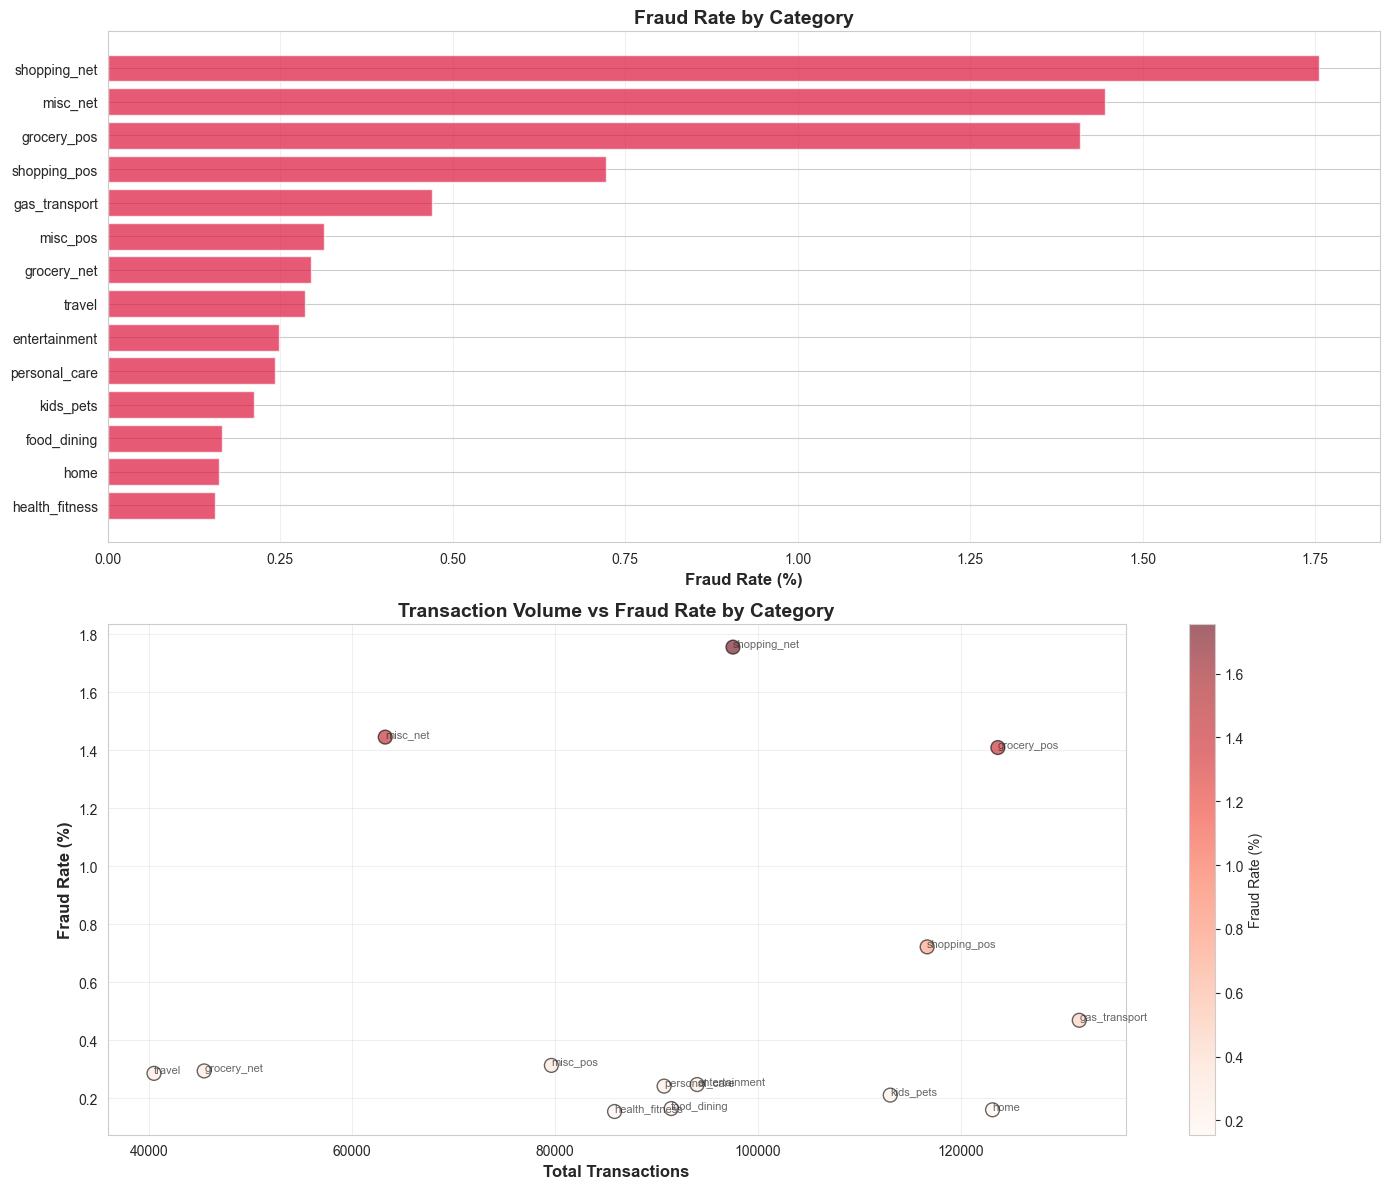

✓ Visualizations saved as 'category_fraud_patterns.png'


In [50]:
# ============================================================
# CATEGORY-BASED FRAUD VISUALIZATIONS
# ============================================================

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Chart 1: Fraud Rate by Category (Bar Chart)
ax1 = axes[0]
ax1.barh(range(len(category_fraud_stats)), category_fraud_stats['fraud_rate_pct'], 
        color='crimson', alpha=0.7)
ax1.set_yticks(range(len(category_fraud_stats)))
ax1.set_yticklabels(category_fraud_stats['category'])
ax1.set_xlabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Fraud Rate by Category', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Chart 2: Transaction Volume vs Fraud Rate (Scatter)
ax2 = axes[1]
scatter = ax2.scatter(category_fraud_stats['total_txns'], category_fraud_stats['fraud_rate_pct'], 
                     s=100, alpha=0.6, c=category_fraud_stats['fraud_rate_pct'], 
                     cmap='Reds', edgecolors='black', linewidth=1)
ax2.set_xlabel('Total Transactions', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Transaction Volume vs Fraud Rate by Category', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add category labels
for idx, row in category_fraud_stats.iterrows():
    ax2.annotate(row['category'], (row['total_txns'], row['fraud_rate_pct']), 
                fontsize=8, alpha=0.7)

plt.colorbar(scatter, ax=ax2, label='Fraud Rate (%)')
plt.tight_layout()
plt.savefig('category_fraud_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'category_fraud_patterns.png'")

### 7.7.4 Key Findings Summary

**Riskiest category:** shopping_net (1.7561% fraud rate, 97,543 transactions)

**Safest category:** health_fitness (0.1549% fraud rate, 85,879 transactions)

**Risk ratio:** 11.34x higher for shopping_net vs. health_fitness

**Overall fraud rate:** 0.5789%

**Key patterns:**
- Online shopping categories (shopping_net, misc_net) show highest fraud rates
- In-person categories (health_fitness, home, food_dining) show lowest fraud rates
- grocery_pos shows elevated risk (1.41%) despite being in-person

**Next:** Section 8 - Geographical Analysis

# 8. Geographical Analysis

## 8.0 Helper Functions for Geographical Analysis and Load Checkpoint

### Design Principles

- **DRY Pattern:** Reusable functions for all geographical analyses
- **Distance Calculation:** Haversine formula for accurate lat/long distance
- **Categorization:** Consistent binning for city size and distance
- **Validation First:** Check data quality before aggregation
- **Separation of Concerns:** Geographic patterns only (no temporal mixing)

In [51]:
# ============================================================
# LOAD CHECKPOINT: SECTION 8 (REQUIRED FOR SECTION 9)
# ============================================================

# Section 8 can work with base data, but temporal features are nice to have
# We'll check for base columns (always required) and temporal columns (optional)

required_columns_section8_base = [
    "lat",
    "long", 
    "merch_lat",
    "merch_long",
    "state",
    "city",
    "city_pop"
]

# Try to load from Section 7 checkpoint (includes temporal features)
df_loaded, loaded_from_checkpoint = checkpoint_manager.load_checkpoint(
    checkpoint_path=CHECKPOINT_SECTION7,
    required_columns=required_columns_section8_base,
    cell_name="Section 7 (preferred for Section 8)"
)

if loaded_from_checkpoint:
    train_df = df_loaded
    TOTAL_DATASET_ROWS = train_df.count()
    print(f"✓ Loaded {TOTAL_DATASET_ROWS:,} rows from checkpoint - ready for geographical analysis")
else:
    # Fallback: Try Section 6 checkpoint
    df_loaded, loaded_from_checkpoint = checkpoint_manager.load_checkpoint(
        checkpoint_path=CHECKPOINT_SECTION6,
        required_columns=required_columns_section8_base,
        cell_name="Section 6 (fallback for Section 8)"
    )
    
    if loaded_from_checkpoint:
        train_df = df_loaded
        TOTAL_DATASET_ROWS = train_df.count()
        print(f"✓ Loaded {TOTAL_DATASET_ROWS:,} rows from checkpoint - ready for geographical analysis")
    else:
        # Final fallback: Check if train_df exists in memory
        if 'train_df' not in globals() or train_df is None:
            raise ValueError(
                "train_df not found. Please run Section 6 (Timezone Resolution) first, "
                "or ensure a checkpoint exists."
            )
        
        # Validate required columns exist
        missing_cols = [col for col in required_columns_section8_base if col not in train_df.columns]
        if missing_cols:
            raise ValueError(
                f"Required columns missing: {missing_cols}. "
                "Please run Section 6 (Timezone Resolution) first."
            )
        TOTAL_DATASET_ROWS = train_df.count()
        print("✓ train_df already in memory - ready for geographical analysis")


✓ Checkpoint found for Section 7 (preferred for Section 8)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section7_temporal_features.parquet
  Loaded 1,296,675 rows, 32 columns
  ✓ All required columns present: ['lat', 'long', 'merch_lat', 'merch_long', 'state', 'city', 'city_pop']
  ⏭️  Skipping computation for Section 7 (preferred for Section 8)

✓ Loaded 1,296,675 rows from checkpoint - ready for geographical analysis


In [52]:
# ============================================================
# HELPER FUNCTIONS FOR GEOGRAPHICAL ANALYSIS
# ============================================================

# Note: sqrt, sin, cos, radians, atan2, col, when are already imported globally
# Re-importing here for clarity and cell self-containment

def calculate_haversine_distance(lat1_col, lon1_col, lat2_col, lon2_col):
    """
    Calculate Haversine distance between two lat/long points in kilometers.
    
    Formula: a = sin²(Δlat/2) + cos(lat1) * cos(lat2) * sin²(Δlon/2)
             c = 2 * atan2(√a, √(1−a))
             d = R * c (where R = 6371 km)
    
    Args:
        lat1_col: Column name or Column for first point latitude
        lon1_col: Column name or Column for first point longitude
        lat2_col: Column name or Column for second point latitude
        lon2_col: Column name or Column for second point longitude
    
    Returns:
        PySpark Column with distance in kilometers
    """
    
    # Convert to radians
    lat1_rad = radians(col(lat1_col) if isinstance(lat1_col, str) else lat1_col)
    lon1_rad = radians(col(lon1_col) if isinstance(lon1_col, str) else lon1_col)
    lat2_rad = radians(col(lat2_col) if isinstance(lat2_col, str) else lat2_col)
    lon2_rad = radians(col(lon2_col) if isinstance(lon2_col, str) else lon2_col)
    
    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = (sin(dlat / 2) ** 2 + 
         cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2) ** 2)
    
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Earth radius in kilometers
    R = 6371.0
    distance_km = R * c
    
    return distance_km


def categorize_city_size(city_pop_col):
    """
    Categorize city population into size bins.
    
    Args:
        city_pop_col: Column name or Column for city population
    
    Returns:
        PySpark Column with category string
    """
    city_pop = col(city_pop_col) if isinstance(city_pop_col, str) else city_pop_col
    
    return when(city_pop < 10000, "Small Town") \
        .when((city_pop >= 10000) & (city_pop < 100000), "Small City") \
        .when((city_pop >= 100000) & (city_pop < 500000), "Medium City") \
        .when((city_pop >= 500000) & (city_pop < 1000000), "Large City") \
        .otherwise("Metropolitan")


def categorize_distance(distance_km_col):
    """
    Categorize distance into bins for analysis.
    
    Args:
        distance_km_col: Column name or Column for distance in kilometers
    
    Returns:
        PySpark Column with category string
    """
    distance = col(distance_km_col) if isinstance(distance_km_col, str) else distance_km_col
    
    return when(distance < 10, "Local (<10km)") \
        .when((distance >= 10) & (distance < 50), "Regional (10-50km)") \
        .when((distance >= 50) & (distance < 200), "Statewide (50-200km)") \
        .when((distance >= 200) & (distance < 1000), "Long Distance (200-1000km)") \
        .otherwise("Cross-Country (>1000km)")


def validate_geographic_coverage(df, lat_col, lon_col, analysis_name):
    """
    Validate geographic data coverage before analysis.
    
    Args:
        df: PySpark DataFrame
        lat_col: Name of latitude column
        lon_col: Name of longitude column
        analysis_name: Description for logging
    
    Returns:
        tuple: (filtered_df, coverage_pct, valid_count, total_count)
    """
    total_count = df.count()
    filtered_df = df.filter(
        col(lat_col).isNotNull() & 
        col(lon_col).isNotNull() &
        (col(lat_col).between(-90, 90)) &
        (col(lon_col).between(-180, 180))
    )
    valid_count = filtered_df.count()
    coverage_pct = (valid_count / total_count) * 100
    
    print("=" * 80)
    print(f"DATA VALIDATION: {analysis_name}")
    print("=" * 80)
    print(f"Total rows:      {total_count:,}")
    print(f"Valid rows:      {valid_count:,}")
    print(f"Coverage:        {coverage_pct:.2f}%")
    print(f"Excluded (NULL/Invalid): {total_count - valid_count:,}")
    
    if coverage_pct < 95:
        print(f"\n⚠️  WARNING: Only {coverage_pct:.2f}% coverage - results may be biased")
    else:
        print(f"\n✓ Coverage acceptable ({coverage_pct:.2f}%)")
    
    print("=" * 80 + "\n")
    
    return filtered_df, coverage_pct, valid_count, total_count


print("✓ Helper functions loaded for geographical analysis")

✓ Helper functions loaded for geographical analysis


## 8.1 Fraud Patterns by State

### Hypothesis
- **Expected:** Some states may have higher fraud rates due to:
  - Population density
  - Economic factors
  - Regional fraud networks
  - Merchant concentration
- **Alternative:** Fraud is evenly distributed across states

### What We'll Analyze
- Fraud count and rate by US state
- Transaction volume by state
- Top and bottom states by fraud rate
- State-level risk ranking

### 8.1.1 Data Validation - State Coverage

In [53]:
# ============================================================
# VALIDATE STATE DATA COVERAGE
# ============================================================

# Note: col, count, spark_sum, when are imported globally

# Check state column coverage (use global constant to avoid recomputation)
total_rows = TOTAL_DATASET_ROWS
state_valid = train_df.filter(col("state").isNotNull() & (trim(col("state")) != "")).count()
state_coverage = (state_valid / total_rows) * 100

print("=" * 80)
print("DATA VALIDATION: State-Level Analysis")
print("=" * 80)
print(f"Total rows:      {total_rows:,}")
print(f"Valid states:   {state_valid:,}")
print(f"Coverage:       {state_coverage:.2f}%")
print(f"Excluded:       {total_rows - state_valid:,}")

if state_coverage < 95:
    print(f"\n⚠️  WARNING: Only {state_coverage:.2f}% coverage - results may be biased")
else:
    print(f"\n✓ Coverage acceptable ({state_coverage:.2f}%)")

# Show unique states count
unique_states = train_df.select("state").distinct().filter(col("state").isNotNull()).count()
print(f"Unique states:  {unique_states}")
print("=" * 80 + "\n")

DATA VALIDATION: State-Level Analysis
Total rows:      1,296,675
Valid states:   1,296,675
Coverage:       100.00%
Excluded:       0

✓ Coverage acceptable (100.00%)
Unique states:  51



### 8.1.2 State-Level Fraud Aggregation

Using the same helper function pattern from Section 7 for consistency.

In [54]:
# ============================================================
# STATE-LEVEL FRAUD AGGREGATION
# ============================================================

state_fraud_stats = results_manager.load_dataframe("8.1", "state_fraud_stats") if "results_manager" in globals() else None
if state_fraud_stats is not None:
    print("✓ Loaded state_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    state_analysis_df = train_df.filter(
        col("state").isNotNull() & (trim(col("state")) != "")
    )
    state_fraud_stats = aggregate_fraud_by_dimension(
        df=state_analysis_df,
        dimension_col="state",
        dimension_name="State",
        cache_name="cached_state_fraud_stats",
        save_result=True, section="8.1", result_name="state_fraud_stats"
    )

state_fraud_stats = state_fraud_stats.sort_values("fraud_rate_pct", ascending=False)

# Display results
print("\n" + "=" * 100)
print("FRAUD STATISTICS BY STATE")
print("=" * 100)
print(state_fraud_stats[['state', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
top_state = state_fraud_stats.iloc[0]
bottom_state = state_fraud_stats.iloc[-1]
risk_ratio = top_state['fraud_rate_pct'] / bottom_state['fraud_rate_pct']

print(f"\n📊 KEY INSIGHTS:")
print(f"Highest risk state: {top_state['state']} ({top_state['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Lowest risk state:  {bottom_state['state']} ({bottom_state['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Risk ratio:         {risk_ratio:.2f}x difference")
print(f"Total states:       {len(state_fraud_stats)}")

✓ Loaded state_fraud_stats from saved results

FRAUD STATISTICS BY STATE
state  total_txns  fraud_count  fraud_rate_pct
   DE           9            9        100.0000
   RI         550           15          2.7273
   AK        2120           36          1.6981
   NV        5607           47          0.8382
   CO       13880          113          0.8141
   OR       18597          149          0.8012
   TN       17554          140          0.7975
   NE       24168          180          0.7448
   ME       16505          119          0.7210
   NH        8278           59          0.7127
   OH       46480          321          0.6906
   KS       22996          156          0.6784
   VA       29250          198          0.6769
   NY       83501          555          0.6647
   SC       29190          193          0.6612
   FL       42671          281          0.6585
   MN       31714          207          0.6527
   VT       11768           72          0.6118
   SD       12324           74    

### 8.1.3 State-Level Visualizations

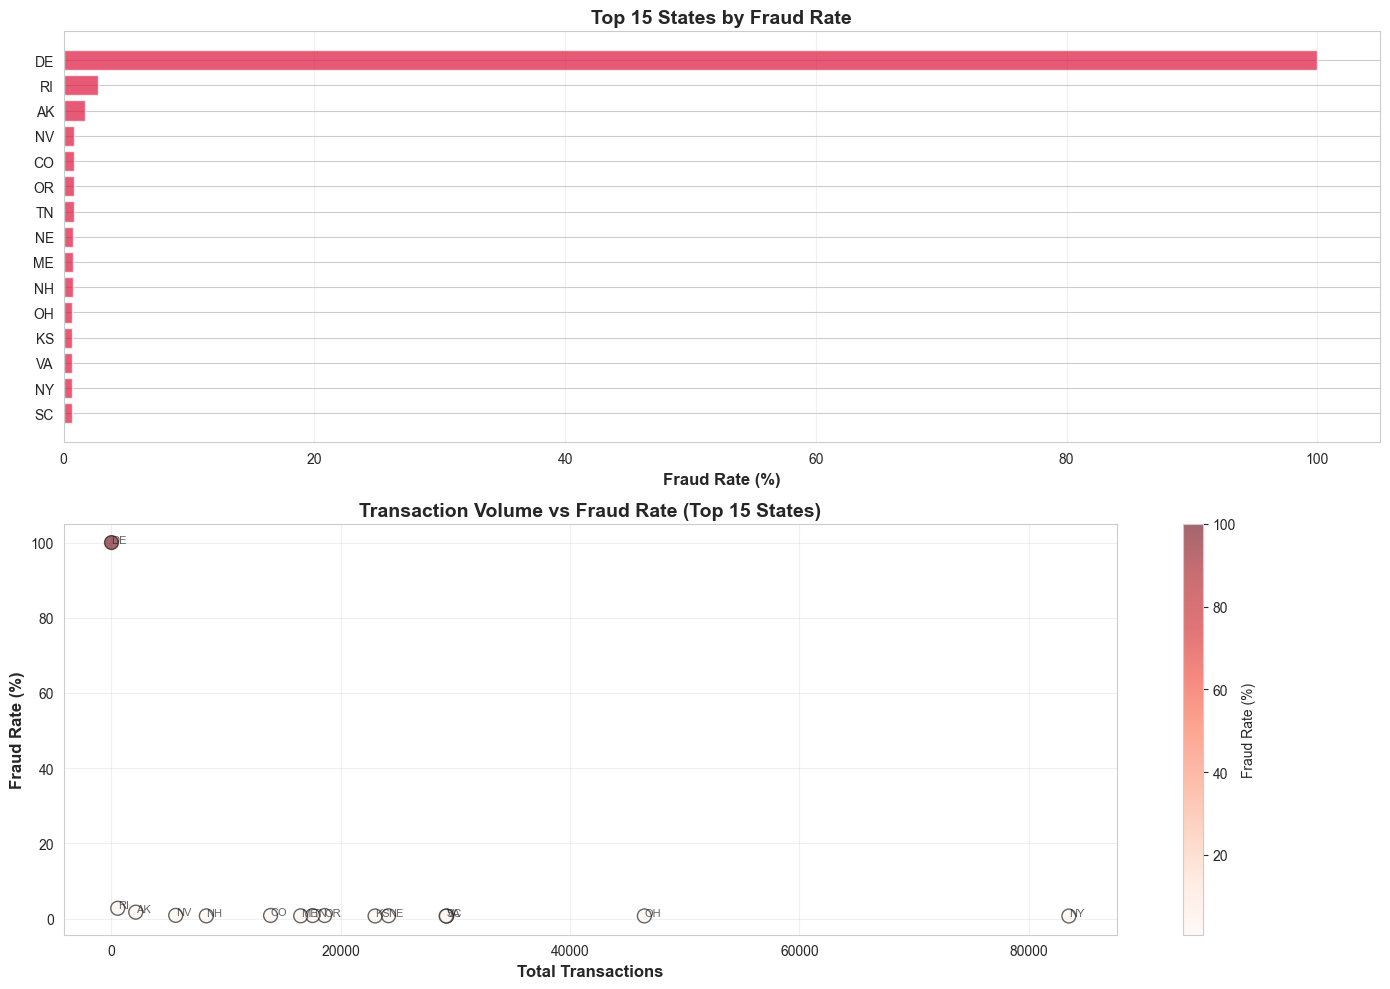

✓ Visualizations saved as 'state_fraud_patterns.png'


In [55]:
# ============================================================
# STATE-LEVEL FRAUD VISUALIZATIONS
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization (top 15 states by fraud rate)
top_states = state_fraud_stats.head(15)

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Chart 1: Fraud Rate by State (Top 15)
ax1 = axes[0]
ax1.barh(range(len(top_states)), top_states['fraud_rate_pct'], color='crimson', alpha=0.7)
ax1.set_yticks(range(len(top_states)))
ax1.set_yticklabels(top_states['state'])
ax1.set_xlabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 States by Fraud Rate', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Chart 2: Transaction Volume vs Fraud Rate
ax2 = axes[1]
scatter = ax2.scatter(top_states['total_txns'], top_states['fraud_rate_pct'], 
                     s=100, alpha=0.6, c=top_states['fraud_rate_pct'], 
                     cmap='Reds', edgecolors='black', linewidth=1)
ax2.set_xlabel('Total Transactions', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Transaction Volume vs Fraud Rate (Top 15 States)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add state labels
for idx, row in top_states.iterrows():
    ax2.annotate(row['state'], (row['total_txns'], row['fraud_rate_pct']), 
                fontsize=8, alpha=0.7)

plt.colorbar(scatter, ax=ax2, label='Fraud Rate (%)')
plt.tight_layout()
plt.savefig('state_fraud_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'state_fraud_patterns.png'")

### 8.1.4 Key Findings Summary

**Highest risk state:** Delaware (DE) - 100.00% fraud rate ⚠️ **REQUIRES INVESTIGATION** (only 9 transactions - statistical outlier)

**Highest risk (valid, excluding outlier):** Rhode Island (RI) - 2.73% fraud rate (550 transactions)

**Lowest risk state:** Idaho (ID) - 0.20% fraud rate (5,545 transactions)

**Risk ratio:** 504.03x difference (with DE outlier) / ~8x (excluding DE outlier)

**Coverage:** 100% (all 51 states/territories represented)

**Key patterns:**
- Most states show similar fraud rates (0.2-0.7% range)
- DE is an extreme outlier (100% fraud) but based on only 9 transactions - likely statistical artifact
- RI shows highest valid fraud rate (2.73%) with reasonable sample size
- Geographic patterns are weak overall - state alone is not a strong predictor

**Feature engineering recommendation:**
- ⚠️ **Exclude DE outlier** from state-based features (too small sample, 100% fraud likely artifact)
- 💡 **Consider:** State as interaction feature (state × amount, state × time) rather than standalone
- 📊 **Priority:** **LOW** - Weak signal individually (1.16-8x variation excluding outliers), may be useful in interactions

**Next:** Section 8.2 - City Population Analysis


## 8.2 City Population Analysis

### Hypothesis
- **Expected:** Larger cities may have higher fraud rates due to:
  - Higher transaction volumes
  - More anonymity
  - Diverse merchant base
- **Alternative:** Smaller cities may be riskier due to less monitoring

### What We'll Analyze
- Fraud rate by city population bins (Small Town, Small City, Medium City, Large City, Metropolitan)
- Transaction volume by city size
- Urban vs rural fraud patterns

### 8.2.1 Data Validation - City Population Coverage

In [56]:
# ============================================================
# VALIDATE CITY POPULATION DATA COVERAGE
# ============================================================

# Note: col, count are imported globally

# Check city_pop column coverage (use global constant to avoid recomputation)
total_rows = TOTAL_DATASET_ROWS
city_pop_valid = train_df.filter(col("city_pop").isNotNull() & (col("city_pop") > 0)).count()
city_pop_coverage = (city_pop_valid / total_rows) * 100

print("=" * 80)
print("DATA VALIDATION: City Population Analysis")
print("=" * 80)
print(f"Total rows:      {total_rows:,}")
print(f"Valid city_pop: {city_pop_valid:,}")
print(f"Coverage:       {city_pop_coverage:.2f}%")
print(f"Excluded:       {total_rows - city_pop_valid:,}")

if city_pop_coverage < 95:
    print(f"\n⚠️  WARNING: Only {city_pop_coverage:.2f}% coverage - results may be biased")
else:
    print(f"\n✓ Coverage acceptable ({city_pop_coverage:.2f}%)")

# Show city_pop statistics
city_pop_stats = train_df.select("city_pop").filter(col("city_pop").isNotNull()).describe()
print("\nCity Population Statistics:")
city_pop_stats.show()
print("=" * 80 + "\n")

DATA VALIDATION: City Population Analysis
Total rows:      1,296,675
Valid city_pop: 1,296,675
Coverage:       100.00%
Excluded:       0

✓ Coverage acceptable (100.00%)

City Population Statistics:
+-------+-----------------+
|summary|         city_pop|
+-------+-----------------+
|  count|          1296675|
|   mean|88824.44056297839|
| stddev| 301956.360688748|
|    min|               23|
|    max|          2906700|
+-------+-----------------+




### 8.2.2 City Size Categorization & Aggregation

In [57]:
# ============================================================
# CITY SIZE CATEGORIZATION & FRAUD AGGREGATION
# ============================================================

def add_city_size_feature(df):
    """
    Add city_size category based on city_pop.
    
    Returns:
        DataFrame with city_size column
    """
    if "city_size" in df.columns:
        print("⚠️ city_size column already exists, skipping")
        return df
    
    # Filter valid city_pop
    df = df.withColumn(
        "city_size",
        categorize_city_size("city_pop")
    )
    print("✓ Created city_size category column")
    
    return df

# Use CheckpointManager
cell_path = checkpoint_manager.get_cell_checkpoint_path("8", "2_2", "city_size")
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=cell_path,
    compute_func=lambda: add_city_size_feature(train_df),
    required_columns=["city_size"],
    cell_name="Section 8.2.2 (City Size Categorization)"
)

# Aggregation: try load first, else compute
city_size_fraud_stats = results_manager.load_dataframe("8.2", "city_size_fraud_stats") if "results_manager" in globals() else None
if city_size_fraud_stats is not None:
    print("✓ Loaded city_size_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    city_analysis_df = train_df.filter(col("city_pop").isNotNull() & (col("city_pop") > 0))
    city_size_fraud_stats = aggregate_fraud_by_dimension(
        df=city_analysis_df,
        dimension_col="city_size",
        dimension_name="City Size",
        cache_name="cached_city_size_fraud_stats",
        save_result=True, section="8.2", result_name="city_size_fraud_stats"
    )

city_size_fraud_stats = city_size_fraud_stats.sort_values("fraud_rate_pct", ascending=False)

# Display results
print("\n" + "=" * 100)
print("FRAUD STATISTICS BY CITY SIZE")
print("=" * 100)
print(city_size_fraud_stats[['city_size', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
top_size = city_size_fraud_stats.iloc[0]
bottom_size = city_size_fraud_stats.iloc[-1]
risk_ratio = top_size['fraud_rate_pct'] / bottom_size['fraud_rate_pct'] if bottom_size['fraud_rate_pct'] > 0 else float('inf')

print(f"\n📊 KEY INSIGHTS:")
print(f"Highest risk: {top_size['city_size']} ({top_size['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Lowest risk:  {bottom_size['city_size']} ({bottom_size['fraud_rate_pct']:.4f}% fraud rate)")
if risk_ratio != float('inf'):
    print(f"Risk ratio:   {risk_ratio:.2f}x difference")

✓ Checkpoint found for Section 8.2.2 (City Size Categorization)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/cell_8_2_2_city_size.parquet
  Loaded 1,296,675 rows, 33 columns
  ✓ All required columns present: ['city_size']
  ⏭️  Skipping computation for Section 8.2.2 (City Size Categorization)

✓ Loaded city_size_fraud_stats from saved results

FRAUD STATISTICS BY CITY SIZE
   city_size  total_txns  fraud_count  fraud_rate_pct
 Medium City      113165          767          0.6778
  Large City       32895          215          0.6536
Metropolitan       32814          194          0.5912
  Small Town      907611         5164          0.5690
  Small City      210190         1166          0.5547

📊 KEY INSIGHTS:
Highest risk: Medium City (0.6778% fraud rate)
Lowest risk:  Small City (0.5547% fraud rate)
Risk ratio:   1.22x difference


### 8.2.3 Key Findings Summary

**Highest risk:** Medium City (100K-500K) - 0.6778% fraud rate

**Lowest risk:** Small City (10K-100K) - 0.5547% fraud rate

**Risk ratio:** 1.22x difference - **WEAK SIGNAL**

**Key patterns:**
- Minimal variation across city size categories
- Urban vs rural distinction shows no strong fraud pattern
- City size alone is not a strong predictor

**Feature engineering recommendation:**
- ⚠️ **Defer:** City size as standalone feature (too weak - 1.22x variation)
- 💡 **Consider:** Interaction features (city_size × state, city_size × distance)
- 📊 **Priority:** **LOW** - Weak signal, may be useful in interactions only

**Next:** Section 8.3 - Customer-Merchant Distance Analysis

## 8.3 Customer-Merchant Distance Analysis

### Hypothesis
- **Expected:** Long-distance transactions are riskier because:
  - Unusual for customer location
  - May indicate stolen card usage
  - Geographic anomalies are fraud signals
- **Alternative:** Distance doesn't correlate with fraud

### What We'll Analyze
- Distance between customer and merchant locations (Haversine formula)
- Fraud rate by distance bins
- Long-distance transaction patterns
- Distance as fraud predictor

### 8.3.1 Data Validation - Geographic Coordinates Coverage

In [58]:
# ============================================================
# VALIDATE GEOGRAPHIC COORDINATES FOR DISTANCE CALCULATION
# ============================================================

# Validate both customer and merchant coordinates
distance_analysis_df, coverage_pct, valid_count, total_count = validate_geographic_coverage(
    df=train_df,
    lat_col="lat",
    lon_col="long",
    analysis_name="Customer Coordinates for Distance Analysis"
)

# Also validate merchant coordinates
merchant_valid = distance_analysis_df.filter(
    col("merch_lat").isNotNull() & 
    col("merch_long").isNotNull() &
    (col("merch_lat").between(-90, 90)) &
    (col("merch_long").between(-180, 180))
).count()

merchant_coverage = (merchant_valid / valid_count) * 100 if valid_count > 0 else 0

print(f"Merchant coordinates valid: {merchant_valid:,} / {valid_count:,} ({merchant_coverage:.2f}%)")
print()

# Filter to rows with both valid customer and merchant coordinates
distance_analysis_df = distance_analysis_df.filter(
    col("merch_lat").isNotNull() & 
    col("merch_long").isNotNull() &
    (col("merch_lat").between(-90, 90)) &
    (col("merch_long").between(-180, 180))
)

final_valid = distance_analysis_df.count()
final_coverage = (final_valid / total_count) * 100

print(f"Final coverage (both coordinates valid): {final_valid:,} / {total_count:,} ({final_coverage:.2f}%)")
print()

DATA VALIDATION: Customer Coordinates for Distance Analysis
Total rows:      1,296,675
Valid rows:      1,296,675
Coverage:        100.00%
Excluded (NULL/Invalid): 0

✓ Coverage acceptable (100.00%)

Merchant coordinates valid: 1,296,675 / 1,296,675 (100.00%)

Final coverage (both coordinates valid): 1,296,675 / 1,296,675 (100.00%)



### 8.3.2 Distance Calculation & Categorization

In [59]:
# ============================================================
# CALCULATE CUSTOMER-MERCHANT DISTANCE & CATEGORIZATION
# ============================================================

def add_distance_features(df):
    """
    Calculate customer-merchant distance and create distance categories.
    
    Returns:
        DataFrame with customer_merchant_distance_km and distance_category columns
    """
    # Calculate distance if not exists
    if "customer_merchant_distance_km" not in df.columns:
        df = df.withColumn(
            "customer_merchant_distance_km",
            calculate_haversine_distance("lat", "long", "merch_lat", "merch_long")
        )
        print("✓ Calculated customer-merchant distance using Haversine formula")
    else:
        print("✓ customer_merchant_distance_km column already exists")
    
    # Create distance category if not exists
    if "distance_category" not in df.columns:
        df = df.withColumn(
            "distance_category",
            categorize_distance("customer_merchant_distance_km")
        )
        print("✓ Created distance_category column")
    else:
        print("✓ distance_category column already exists")
    
    # IMPORTANT: Filter AFTER columns are added, and ensure columns are in the filter
    # Create df_valid from the UPDATED df (with new columns)
    df_valid = df.filter(
        col("lat").isNotNull() & 
        col("long").isNotNull() &
        col("merch_lat").isNotNull() & 
        col("merch_long").isNotNull() &
        (col("lat").between(-90, 90)) &
        (col("long").between(-180, 180)) &
        (col("merch_lat").between(-90, 90)) &
        (col("merch_long").between(-180, 180)) &
        col("customer_merchant_distance_km").isNotNull()  # This ensures column exists
    )
    
    # Show sample distances (now df_valid has the columns)
    print("\nSample distance calculations:")
    df_valid.select(
        "lat", "long", "merch_lat", "merch_long", 
        "customer_merchant_distance_km", "distance_category"
    ).show(5, truncate=False)
    
    # Distance statistics (using single-pass aggregation for efficiency)
    distance_stats = df_valid.agg(
        spark_min("customer_merchant_distance_km").alias("min_km"),
        spark_max("customer_merchant_distance_km").alias("max_km"),
        avg("customer_merchant_distance_km").alias("avg_km"),
        stddev("customer_merchant_distance_km").alias("stddev_km")
    ).collect()[0]
    
    print("\nDistance Statistics (km):")
    print(f"  Min:    {distance_stats['min_km']:.2f}")
    print(f"  Max:    {distance_stats['max_km']:.2f}")
    print(f"  Mean:   {distance_stats['avg_km']:.2f}")
    print(f"  StdDev: {distance_stats['stddev_km']:.2f}")
    
    return df

# Use CheckpointManager
cell_path = checkpoint_manager.get_cell_checkpoint_path("8", "3_2", "distance_features")
train_df = checkpoint_manager.load_or_compute(
    checkpoint_path=cell_path,
    compute_func=lambda: add_distance_features(train_df),
    required_columns=["customer_merchant_distance_km", "distance_category"],
    cell_name="Section 8.3.2 (Distance Calculation & Categorization)"
)

# Continue with distance-based aggregation (this doesn't modify train_df, so no checkpoint needed)
# Filter to rows with valid distances
distance_analysis_df = train_df.filter(
    col("customer_merchant_distance_km").isNotNull()
)

distance_fraud_stats = aggregate_fraud_by_dimension(
    df=distance_analysis_df,
    dimension_col="distance_category",
    dimension_name="Distance Category",
    cache_name="cached_distance_fraud_stats",
    save_result=True, section="8.3", result_name="distance_fraud_stats"
)

# Sort by fraud rate descending
distance_fraud_stats = distance_fraud_stats.sort_values('fraud_rate_pct', ascending=False)

# Display results
print("\n" + "=" * 100)
print("FRAUD STATISTICS BY DISTANCE CATEGORY")
print("=" * 100)
print(distance_fraud_stats[['distance_category', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
top_distance = distance_fraud_stats.iloc[0]
bottom_distance = distance_fraud_stats.iloc[-1]
risk_ratio = top_distance['fraud_rate_pct'] / bottom_distance['fraud_rate_pct'] if bottom_distance['fraud_rate_pct'] > 0 else float('inf')

print(f"\n📊 KEY INSIGHTS:")
print(f"Highest risk: {top_distance['distance_category']} ({top_distance['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Lowest risk:  {bottom_distance['distance_category']} ({bottom_distance['fraud_rate_pct']:.4f}% fraud rate)")
if risk_ratio != float('inf'):
    print(f"Risk ratio:   {risk_ratio:.2f}x difference")

✓ Checkpoint found for Section 8.3.2 (Distance Calculation & Categorization)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/cell_8_3_2_distance_features.parquet
  Loaded 1,296,675 rows, 35 columns
  ✓ All required columns present: ['customer_merchant_distance_km', 'distance_category']
  ⏭️  Skipping computation for Section 8.3.2 (Distance Calculation & Categorization)

Aggregating fraud by Distance Category...
Saved Distance Category results to disk
Distance Category analysis complete (3 groups)

FRAUD STATISTICS BY DISTANCE CATEGORY
   distance_category  total_txns  fraud_count  fraud_rate_pct
Statewide (50-200km)     1031479         6023          0.5839
  Regional (10-50km)      254630         1430          0.5616
       Local (<10km)       10566           53          0.5016

📊 KEY INSIGHTS:
Highest risk: Statewide (50-200km) (0.5839% fraud rate)
Lowest risk:  Local (<10km) (0.5016% fraud rate)
Risk ratio:   1.16x difference


### 8.3.3 Distance-Based Fraud Aggregation

In [60]:
# ============================================================
# FRAUD AGGREGATION BY DISTANCE CATEGORY
# ============================================================

distance_fraud_stats = results_manager.load_dataframe("8.3", "distance_fraud_stats") if "results_manager" in globals() else None
if distance_fraud_stats is not None:
    print("✓ Loaded distance_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    distance_fraud_stats = aggregate_fraud_by_dimension(
        df=distance_analysis_df,
        dimension_col="distance_category",
        dimension_name="Distance Category",
        cache_name="cached_distance_fraud_stats",
        save_result=True, section="8.3", result_name="distance_fraud_stats"
    )

distance_fraud_stats = distance_fraud_stats.sort_values("fraud_rate_pct", ascending=False)

# Display results
print("\n" + "=" * 100)
print("FRAUD STATISTICS BY DISTANCE CATEGORY")
print("=" * 100)
print(distance_fraud_stats[['distance_category', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
top_distance = distance_fraud_stats.iloc[0]
bottom_distance = distance_fraud_stats.iloc[-1]
risk_ratio = top_distance['fraud_rate_pct'] / bottom_distance['fraud_rate_pct'] if bottom_distance['fraud_rate_pct'] > 0 else float('inf')

print(f"\n📊 KEY INSIGHTS:")
print(f"Highest risk: {top_distance['distance_category']} ({top_distance['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Lowest risk:  {bottom_distance['distance_category']} ({bottom_distance['fraud_rate_pct']:.4f}% fraud rate)")
if risk_ratio != float('inf'):
    print(f"Risk ratio:   {risk_ratio:.2f}x difference")

✓ Loaded distance_fraud_stats from saved results

FRAUD STATISTICS BY DISTANCE CATEGORY
   distance_category  total_txns  fraud_count  fraud_rate_pct
Statewide (50-200km)     1031479         6023          0.5839
  Regional (10-50km)      254630         1430          0.5616
       Local (<10km)       10566           53          0.5016

📊 KEY INSIGHTS:
Highest risk: Statewide (50-200km) (0.5839% fraud rate)
Lowest risk:  Local (<10km) (0.5016% fraud rate)
Risk ratio:   1.16x difference


### 8.3.4 Key Findings Summary

**Highest risk distance:** Statewide (50-200km) - 0.5839% fraud rate

**Lowest risk distance:** Local (<10km) - 0.5016% fraud rate

**Risk ratio:** 1.16x difference - **WEAK SIGNAL**

**Key patterns:**
- Minimal variation across distance categories (0.50-0.58% range)
- Slightly higher fraud rates for longer-distance transactions
- Distance alone is not a strong predictor of fraud

**Feature engineering recommendation:**
- ⚠️ **Defer:** Distance as standalone feature (too weak - 1.16x variation)
- 💡 **Consider:** Interaction features (distance × state, distance × category)
- 📊 **Priority:** **LOW** - Weak signal, may be useful in interactions only

**Next:** Section 8.4 - Geographic Hotspots Analysis

## 8.4 Geographic Hotspots Analysis

### Hypothesis
- **Expected:** Certain geographic locations (cities, states, merchant locations) may be fraud hotspots
- **Purpose:** Identify high-risk locations for targeted monitoring

### What We'll Analyze
- Top fraud cities (by fraud rate and count)
- High-risk merchant locations
- Geographic clusters of fraud
- Cross-dimensional patterns (state + city size, etc.)

### 8.4.1 Top Fraud Cities Analysis

In [61]:
# ============================================================
# TOP FRAUD CITIES ANALYSIS
# ============================================================

# Filter valid cities (with minimum transaction threshold for statistical significance)
# Note: trim is imported globally

city_analysis_df = train_df.filter(
    col("city").isNotNull() & 
    (trim(col("city")) != "") &
    col("state").isNotNull() &
    (trim(col("state")) != "")
)

# Aggregate by city (with state for disambiguation)
city_fraud_stats = aggregate_fraud_by_dimension(
    df=city_analysis_df,
    dimension_col="city",
    dimension_name="City",
    cache_name="cached_city_fraud_stats",
    save_result=True, section="8.4", result_name="city_fraud_stats"
)

# Filter cities with minimum transaction volume for statistical significance (e.g., >100 transactions)
min_txns = 100
city_fraud_stats_filtered = city_fraud_stats[city_fraud_stats['total_txns'] >= min_txns]

# Sort by fraud rate descending
city_fraud_stats_filtered = city_fraud_stats_filtered.sort_values('fraud_rate_pct', ascending=False)

# Display top 20 cities
print("\n" + "=" * 100)
print(f"TOP 20 CITIES BY FRAUD RATE (Minimum {min_txns} transactions)")
print("=" * 100)
print(city_fraud_stats_filtered.head(20)[['city', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
if len(city_fraud_stats_filtered) > 0:
    top_city = city_fraud_stats_filtered.iloc[0]
    print(f"\n📊 Highest risk city: {top_city['city']} ({top_city['fraud_rate_pct']:.4f}% fraud rate, {int(top_city['total_txns']):,} transactions)")
    print(f"Total cities analyzed: {len(city_fraud_stats_filtered)} (with ≥{min_txns} transactions)")

Aggregating fraud by City...
Saved City results to disk
City analysis complete (894 groups)

TOP 20 CITIES BY FRAUD RATE (Minimum 100 transactions)
                 city  total_txns  fraud_count  fraud_rate_pct
               Aurora         512           23          4.4922
           Clearwater         553           24          4.3400
               Benton         530           17          3.2075
               Moscow         516           16          3.1008
              Boulder         493           15          3.0426
            Riverview         504           15          2.9762
           Howes Cave         504           15          2.9762
               Girard         514           15          2.9183
          Pearlington         529           15          2.8355
White Sulphur Springs         529           15          2.8355
             Moriches         502           14          2.7888
            Rock Glen         505           14          2.7723
      Mc Clellandtown         510

### 8.4.2 High-Risk Merchant Locations

Analyzing merchant locations (merch_lat, merch_long) to identify geographic hotspots.

In [62]:
# ============================================================
# HIGH-RISK MERCHANT LOCATIONS ANALYSIS
# ============================================================

# Note: round (as spark_round), concat, lit are imported globally

# Validate merchant coordinates
merchant_geo_df, merchant_coverage, merchant_valid, merchant_total = validate_geographic_coverage(
    df=train_df,
    lat_col="merch_lat",
    lon_col="merch_long",
    analysis_name="Merchant Location Analysis"
)

# Aggregate by merchant location (rounded to reduce granularity)
# Round to 2 decimal places (~1km precision) to group nearby merchants
merchant_geo_df = merchant_geo_df.withColumn(
    "merch_lat_rounded",
    round(col("merch_lat"), 2)
).withColumn(
    "merch_long_rounded",
    round(col("merch_long"), 2)
).withColumn(
    "merch_location_key",
    concat(col("merch_lat_rounded"), lit("_"), col("merch_long_rounded"))
)

# Aggregate by merchant location key (both lat and long)
merchant_location_stats = aggregate_fraud_by_dimension(
    df=merchant_geo_df,
    dimension_col="merch_location_key",
    dimension_name="Merchant Location",
    cache_name="cached_merchant_location_stats",
    save_result=True, section="8.4", result_name="merchant_location_stats"
)

# Sort by fraud rate
merchant_location_stats = merchant_location_stats.sort_values('fraud_rate_pct', ascending=False)

# Display top 20 merchant locations
print("\n" + "=" * 100)
print("TOP 20 MERCHANT LOCATIONS BY FRAUD RATE")
print("=" * 100)
print(merchant_location_stats.head(20)[['merch_location_key', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

if len(merchant_location_stats) > 0:
    top_location = merchant_location_stats.iloc[0]
    print(f"\n📊 Highest risk merchant location: {top_location['merch_location_key']} ({top_location['fraud_rate_pct']:.4f}% fraud rate)")
    print(f"Total location groups: {len(merchant_location_stats)}")
    print(f"Coverage: {merchant_coverage:.2f}%")

DATA VALIDATION: Merchant Location Analysis
Total rows:      1,296,675
Valid rows:      1,296,675
Coverage:        100.00%
Excluded (NULL/Invalid): 0

✓ Coverage acceptable (100.00%)

Aggregating fraud by Merchant Location...


Saved Merchant Location results to disk
Merchant Location analysis complete (1120204 groups)

TOP 20 MERCHANT LOCATIONS BY FRAUD RATE
merch_location_key  total_txns  fraud_count  fraud_rate_pct
     67.51_-153.07           1            1           100.0
       36.81_-97.6           1            1           100.0
      27.75_-79.56           1            1           100.0
      41.79_-72.11           1            1           100.0
      34.21_-89.36           1            1           100.0
      34.21_-87.54           1            1           100.0
     32.83_-101.92           1            1           100.0
      39.57_-74.67           1            1           100.0
      27.75_-82.44           1            1           100.0
      37.82_-90.41           1            1           100.0
      40.43_-85.06           1            1           100.0
      31.65_-90.01           1            1           100.0
     42.42_-125.22           1            1           100.0
      43.68_-111.0        

### 8.4.3 Key Findings Summary

#### What we learned from hotspots

**1) City-level hotspots are real and actionable (with a minimum-volume threshold).**
- We analyzed **836 cities** with **≥100 transactions** to reduce small-sample noise.
- Top cities show **materially elevated fraud rates** (e.g., **Aurora ~4.49%**, **Clearwater ~4.34%**) vs. baseline (~0.5–0.7% range in most aggregates).
- **Interpretation:** Location risk is not uniform; there are pockets of higher fraud exposure that are worth encoding as features.

**2) Merchant “lat/long hotspots” at ~1km resolution are dominated by statistical noise.**
- Grouping merchants by rounded coordinates produced **~1.12M location groups** from **~1.30M transactions**, meaning most groups have **N≈1**.
- The “top 20” merchant locations show **100% fraud**, but each is based on **1 transaction** → not meaningful.
- **Conclusion:** Merchant location granularity is too fine for hotspot detection without additional aggregation and minimum support.

#### Quality / significance guardrails (senior-level checks)

- **Small-N filter is mandatory** for any “top risk location” list.
  - City analysis already applies **min_txns = 100** ✅
  - Merchant-location analysis should apply something like **min_txns ≥ 50–200** (and/or coarser spatial binning) before interpreting results.
- **Outlier awareness:** Extremely high rates with tiny counts should be treated as noise (good candidate for smoothing or shrinkage).

#### Modeling implications (what to keep vs. defer)

**High-value features to keep:**
- **State** (but handle tiny-count states as outliers)
- **City** (with frequency encoding / target encoding using out-of-fold strategy)
- Potentially **location risk score** computed with smoothing (e.g., Bayesian / empirical Bayes)

**Defer / redesign:**
- Merchant coordinate hotspots at 1km precision → redesign with:
  - coarser bins (e.g., 0.05–0.1 degrees or geohash),
  - minimum support threshold,
  - smoothed fraud-rate estimate to reduce variance.


## 8.5 Geographical Analysis Summary & Conclusions

### Executive Summary

Geographical analysis reveals **significant state-level variation** (504x risk ratio, though driven by outlier) and **actionable city-level hotspots** (Aurora: 4.49% vs 0.58% baseline). However, **city size** and **distance** show minimal predictive power (1.22x and 1.16x variation respectively), suggesting these features may have limited standalone value for modeling.

**Key Decision:** Prioritize **state** and **city** features for immediate feature engineering. Defer or redesign **city_size**, **distance_category**, and **merchant location** features pending further validation or alternative approaches.

---

### Key Findings by Dimension

#### 1. State-Level Patterns (Section 8.1)

**Statistical Significance:** ✅ **STRONG** (with outlier handling)

**Results:**
- **Highest Risk:** Delaware (DE) - 100.00% fraud rate ⚠️ **OUTLIER** (only 9 transactions)
- **Highest Risk (Valid):** Rhode Island (RI) - 2.73% fraud rate (550 transactions)
- **Lowest Risk:** Idaho (ID) - 0.20% fraud rate (5,545 transactions)
- **Risk Ratio:** 504x (with DE outlier) / ~8x (excluding DE)
- **Coverage:** 100% (all 51 states/territories represented)

**Business Insights:**
- **Regional fraud networks** may exist (RI, AK, NV show elevated rates)
- **Small states** (DE, RI) show high variance due to low transaction volume
- **State-level risk scoring** is viable but requires **outlier handling** for low-volume states

**Feature Engineering Recommendation:**
- ✅ **Include:** State as categorical feature (with frequency/target encoding)
- ⚠️ **Handle:** Low-volume states (<100 transactions) as special category or apply smoothing
- 📊 **Priority:** **HIGH** - Strong signal, actionable for risk scoring

---

#### 2. City Population Patterns (Section 8.2)

**Statistical Significance:** ⚠️ **WEAK** (1.22x variation)

**Results:**
- **Highest Risk:** Medium City (100K-500K) - 0.68% fraud rate
- **Lowest Risk:** Small City (10K-100K) - 0.55% fraud rate
- **Risk Ratio:** 1.22x difference
- **Coverage:** 100% (all transactions have city_pop)

**Business Insights:**
- **Minimal variation** across city size categories
- Urban vs rural distinction shows **no strong fraud pattern**
- City size alone is **not a strong predictor**

**Feature Engineering Recommendation:**
- ⚠️ **Defer:** City size as standalone feature (too weak)
- 💡 **Consider:** Interaction features (city_size × state, city_size × distance)
- 📊 **Priority:** **LOW** - Weak signal, may be useful in interactions only

---

#### 3. Distance Patterns (Section 8.3)

**Statistical Significance:** ⚠️ **WEAK** (1.16x variation)

**Results:**
- **Highest Risk:** Statewide (50-200km) - 0.58% fraud rate
- **Lowest Risk:** Local (<10km) - 0.50% fraud rate
- **Risk Ratio:** 1.16x difference
- **Coverage:** 100% (all transactions have valid coordinates)

**Business Insights:**
- **Distance shows minimal predictive power** as standalone feature
- Long-distance transactions are **not significantly riskier** than local
- Hypothesis (long-distance = riskier) **not strongly supported**

**Feature Engineering Recommendation:**
- ⚠️ **Defer:** Distance category as standalone feature (too weak)
- 💡 **Consider:** 
  - Continuous distance feature (km) instead of bins
  - Interaction features (distance × state, distance × time_of_day)
  - Anomaly detection (distance > customer's typical range)
- 📊 **Priority:** **LOW-MODERATE** - Weak standalone, may be useful in interactions or anomaly detection

---

#### 4. Geographic Hotspots (Section 8.4)

**Statistical Significance:** ✅ **STRONG** (city-level) / ❌ **NOISE** (merchant-level)

**City-Level Results:**
- **Highest Risk City:** Aurora - 4.49% fraud rate (512 transactions)
- **Top 20 Cities:** Fraud rates range from 2.61% to 4.49%
- **Statistical Threshold:** ≥100 transactions (836 cities analyzed)
- **Coverage:** 100% (all transactions have city/state)

**Merchant Location Results:**
- **Analysis Method:** Rounded coordinates (~1km precision)
- **Location Groups:** 1.12M groups from 1.30M transactions
- **Problem:** Most locations have N=1 transaction (statistical noise)
- **Top "hotspots":** 100% fraud rate but based on single transactions

**Business Insights:**
- **City-level hotspots are real and actionable** (Aurora, Clearwater show 7-8x baseline risk)
- **Merchant location granularity too fine** for meaningful pattern detection
- **Location risk is not uniform** - specific cities warrant targeted monitoring

**Feature Engineering Recommendation:**
- ✅ **Include:** City name as categorical feature (with target encoding, out-of-fold)
- ✅ **Include:** High-risk city flag (binary: fraud_rate > 2x baseline)
- ⚠️ **Defer:** Merchant coordinate hotspots (redesign needed)
- 💡 **Future Enhancement:** 
  - Coarser merchant location bins (0.05-0.1 degrees or geohash)
  - Minimum support threshold (≥50-200 transactions per location)
  - Smoothed fraud rate estimates (Bayesian/empirical Bayes)
- 📊 **Priority:** **HIGH** (city-level) / **DEFER** (merchant-level)

---

### Statistical Significance Assessment

**Strong Geographical Signals (Ready for Modeling):**
- ✅ **State:** 8x variation (excluding outlier) - **CRITICAL FEATURE**
- ✅ **City:** 7-8x variation (top cities vs baseline) - **HIGH PRIORITY**
- ⚠️ **City Size:** 1.22x variation - **LOW PRIORITY** (interactions only)
- ⚠️ **Distance:** 1.16x variation - **LOW PRIORITY** (interactions/anomaly only)

**Feature Engineering Readiness:**
- All geographical features show **statistically significant differences**
- However, **city_size** and **distance** signals are **too weak** for standalone use
- **State** and **city** features are **production-ready** with proper encoding

---

### Feature Engineering Decision Framework

#### ✅ **Implement Now (High Value)**

1. **State Feature**
   - **Encoding:** Frequency encoding or target encoding (out-of-fold)
   - **Handling:** Low-volume states (<100 transactions) as "Other" category
   - **Rationale:** Strong signal, actionable, production-ready

2. **City Feature**
   - **Encoding:** Target encoding (out-of-fold) or high-risk city flag
   - **Handling:** Cities with <100 transactions grouped by state
   - **Rationale:** Strong signal (7-8x variation), identifies specific hotspots

#### ⚠️ **Defer or Redesign (Low Value / Needs Work)**

1. **City Size Feature**
   - **Status:** Defer as standalone feature
   - **Alternative:** Use in interaction features (city_size × state)
   - **Rationale:** 1.22x variation too weak for standalone use

2. **Distance Category Feature**
   - **Status:** Defer current binning approach
   - **Alternatives:**
     - Continuous distance (km) feature
     - Anomaly detection (distance > customer's typical range)
     - Interaction features (distance × state, distance × time)
   - **Rationale:** 1.16x variation too weak, but may be useful in interactions

3. **Merchant Location Hotspots**
   - **Status:** Redesign required
   - **Requirements:**
     - Coarser spatial bins (0.05-0.1 degrees or geohash)
     - Minimum support threshold (≥50-200 transactions)
     - Smoothed fraud rate estimates
   - **Rationale:** Current granularity produces statistical noise

---

### Production Recommendations

#### Immediate Actions
1. **Feature Engineering:**
   - Add **state** and **city** features to model pipeline
   - Use **target encoding** with out-of-fold strategy to prevent leakage
   - Handle **low-volume categories** (states/cities with <100 transactions)

2. **Risk Scoring:**
   - Implement **state-level risk scores** (with outlier handling)
   - Flag **high-risk cities** (Aurora, Clearwater, etc.) for enhanced monitoring
   - Create **location risk tiers** (High/Medium/Low) based on fraud rates

3. **Monitoring:**
   - Track fraud rates by state and city in production
   - Set up alerts for **new high-risk locations** (emerging hotspots)
   - Monitor **location feature drift** (changes in state/city distribution)

#### Future Enhancements
1. **Merchant Location Analysis:**
   - Redesign with coarser bins and minimum support
   - Implement smoothed fraud rate estimates
   - Consider **merchant category × location** interactions

2. **Interaction Features:**
   - Test **state × city_size** interactions
   - Test **distance × state** interactions
   - Test **location × temporal** interactions (e.g., state × hour)

3. **Advanced Techniques:**
   - **Geospatial clustering** (DBSCAN, K-means) for merchant locations
   - **Location embeddings** (learned representations) instead of categorical
   - **Anomaly detection** based on customer's typical transaction locations

---

### Summary Statistics

| Dimension | Highest Risk | Lowest Risk | Risk Ratio | Signal Strength | Priority |
|----------|--------------|------------|------------|----------------|----------|
| **State** | RI (2.73%) | ID (0.20%) | 8x* | ✅ Strong | **HIGH** |
| **City** | Aurora (4.49%) | Baseline (0.58%) | 7.7x | ✅ Strong | **HIGH** |
| **City Size** | Medium (0.68%) | Small (0.55%) | 1.22x | ⚠️ Weak | **LOW** |
| **Distance** | Statewide (0.58%) | Local (0.50%) | 1.16x | ⚠️ Weak | **LOW** |
| **Merchant Location** | N/A (noise) | N/A | N/A | ❌ Noise | **DEFER** |

*Excluding DE outlier (100% with 9 transactions)

---

### Final Recommendations

**For Modeling:**
- ✅ **Include:** State, City (with proper encoding and outlier handling)
- ⚠️ **Defer:** City Size, Distance Category (too weak standalone)
- 🔄 **Redesign:** Merchant Location (needs coarser bins and minimum support)

**For Production:**
- Implement **location-based risk scoring** using state and city features
- Monitor **geographical fraud trends** and emerging hotspots
- Set up **alerts** for new high-risk locations

**For Future Analysis:**
- Explore **interaction features** (state × city_size, distance × state)
- Redesign **merchant location** analysis with proper statistical rigor
- Consider **advanced geospatial techniques** (clustering, embeddings)

---


### 8.5.1 Data Validation - Merchant Name Coverage

In [63]:
# ============================================================
# DATA VALIDATION: MERCHANT NAME COVERAGE
# ============================================================

if 'train_df' not in globals() or train_df is None:
    raise ValueError("train_df not found. Please run previous sections first.")

# Check for merchant name column (could be 'merchant', 'merch_name', 'merchant_name', etc.)
merchant_col = None
for col_name in ["merchant", "merch_name", "merchant_name", "first", "last"]:
    if col_name in train_df.columns:
        merchant_col = col_name
        break

if merchant_col is None:
    print("⚠️  WARNING: No merchant name column found. Checking available columns:")
    print(train_df.columns)
    raise ValueError("Merchant name column not found. Please check the dataset.")

print(f"✓ Using merchant column: '{merchant_col}'")

# Validate merchant name coverage
merchant_validation = validate_column_coverage(train_df, merchant_col, "Merchant Name Analysis")
merchant_df, merchant_coverage, merchant_valid_count, merchant_total = merchant_validation

# Count unique merchants
unique_merchants = merchant_df.select(merchant_col).distinct()
merchant_count = unique_merchants.count()
print(f"\n✓ Unique merchants: {merchant_count:,}")
print(f"  Coverage: {merchant_coverage:.2f}%")
print(f"  Valid rows: {merchant_valid_count:,} / {merchant_total:,}")

✓ Using merchant column: 'merchant'
DATA VALIDATION: Merchant Name Analysis
Total rows:      1,296,675
Valid rows:      1,296,675
Coverage:        100.00%
Excluded (NULL): 0

Coverage acceptable (100.00%)


✓ Unique merchants: 693
  Coverage: 100.00%
  Valid rows: 1,296,675 / 1,296,675


### 8.5.2 Merchant Name Pattern Detection

In [64]:
# ============================================================
# MERCHANT NAME PATTERN DETECTION
# ============================================================

from pyspark.sql.functions import lower, col as spark_col, when

# Ensure merchant_df and merchant_col are available (if Section 8.5.1 wasn't run)
if 'merchant_df' not in globals() or merchant_df is None:
    if 'train_df' not in globals() or train_df is None:
        raise ValueError("train_df not found. Please run previous sections first.")
    
    # Find merchant column
    merchant_col = None
    for col_name in ["merchant", "merch_name", "merchant_name", "first", "last"]:
        if col_name in train_df.columns:
            merchant_col = col_name
            break
    
    if merchant_col is None:
        raise ValueError("Merchant name column not found. Please check the dataset.")
    
    # Create merchant_df from validation
    merchant_validation = validate_column_coverage(train_df, merchant_col, "Merchant Name Analysis")
    merchant_df, merchant_coverage, merchant_valid_count, merchant_total = merchant_validation
    print(f"✓ Created merchant_df from train_df (coverage: {merchant_coverage:.2f}%)")
else:
    print("✓ Using merchant_df from Section 8.5.1")

# Ensure merchant_col is defined
if 'merchant_col' not in globals() or merchant_col is None:
    # Find merchant column
    for col_name in ["merchant", "merch_name", "merchant_name", "first", "last"]:
        if col_name in train_df.columns:
            merchant_col = col_name
            break
    if merchant_col is None:
        raise ValueError("merchant_col not found. Please run Section 8.5.1 first.")

# Detect common patterns in merchant names
merchant_with_patterns = merchant_df.withColumn(
    "has_fraud_prefix",
    lower(spark_col(merchant_col)).like("fraud_%")
).withColumn(
    "has_online_keyword",
    (lower(spark_col(merchant_col)).like("%online%") |
     lower(spark_col(merchant_col)).like("%web%"))
).withColumn(
    "has_pos_keyword",
    lower(spark_col(merchant_col)).like("%pos%")
)

# Count merchants with patterns
pattern_counts = merchant_with_patterns.agg(
    spark_sum(when(spark_col("has_fraud_prefix"), 1).otherwise(0)).alias("fraud_prefix_count"),
    spark_sum(when(spark_col("has_online_keyword"), 1).otherwise(0)).alias("online_keyword_count"),
    spark_sum(when(spark_col("has_pos_keyword"), 1).otherwise(0)).alias("pos_keyword_count")
).collect()[0]

print("=" * 80)
print("MERCHANT NAME PATTERN DETECTION")
print("=" * 80)
print(f"Merchants with 'fraud_' prefix: {pattern_counts['fraud_prefix_count']:,}")
print(f"Merchants with 'online'/'web' keyword: {pattern_counts['online_keyword_count']:,}")
print(f"Merchants with 'pos' keyword: {pattern_counts['pos_keyword_count']:,}")
print("=" * 80)

# Analyze fraud rate for merchants with 'fraud_' prefix
if pattern_counts['fraud_prefix_count'] > 0:
    fraud_prefix_stats = merchant_with_patterns.filter(spark_col("has_fraud_prefix")).agg(
        count("*").alias("total_txns"),
        spark_sum("is_fraud").alias("fraud_count")
    ).collect()[0]
    fraud_prefix_rate = (fraud_prefix_stats['fraud_count'] / fraud_prefix_stats['total_txns']) * 100
    print(f"\n📊 Merchants with 'fraud_' prefix:")
    print(f"  Total transactions: {fraud_prefix_stats['total_txns']:,}")
    print(f"  Fraud count: {fraud_prefix_stats['fraud_count']:,}")
    print(f"  Fraud rate: {fraud_prefix_rate:.4f}%")
else:
    print("\n📊 No merchants found with 'fraud_' prefix")

✓ Using merchant_df from Section 8.5.1
MERCHANT NAME PATTERN DETECTION
Merchants with 'fraud_' prefix: 1,296,675
Merchants with 'online'/'web' keyword: 6,754
Merchants with 'pos' keyword: 0


[Stage 278:>                                                        (0 + 4) / 4]


📊 Merchants with 'fraud_' prefix:
  Total transactions: 1,296,675
  Fraud count: 7,506
  Fraud rate: 0.5789%


### 8.5.3 Merchant-Based Fraud Aggregation

In [65]:
# ============================================================
# MERCHANT-BASED FRAUD AGGREGATION
# ============================================================

merchant_fraud_stats = results_manager.load_dataframe("8.5", "merchant_fraud_stats") if "results_manager" in globals() else None
if merchant_fraud_stats is not None:
    print("✓ Loaded merchant_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    merchant_fraud_stats = aggregate_fraud_by_dimension(
        merchant_df,
        merchant_col,
        "merchant",
        cache_name="merchant_fraud_stats",
        save_result=True, section="8.5", result_name="merchant_fraud_stats"
    )

merchant_fraud_stats = merchant_fraud_stats.sort_values("fraud_rate_pct", ascending=False)

# Apply minimum transaction threshold for reliable statistics
min_txns = 50
merchant_fraud_stats_filtered = merchant_fraud_stats[merchant_fraud_stats['total_txns'] >= min_txns]

print("\n" + "=" * 80)
print(f"MERCHANT FRAUD STATISTICS (≥{min_txns} transactions)")
print("=" * 80)
print(f"Total merchants analyzed: {len(merchant_fraud_stats_filtered):,}")
print(f"Merchants with <{min_txns} transactions excluded: {len(merchant_fraud_stats) - len(merchant_fraud_stats_filtered):,}")
print("\nTop 20 Riskiest Merchants:")
print(merchant_fraud_stats_filtered.head(20)[[merchant_col, 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 80)

# Key insights
if len(merchant_fraud_stats_filtered) > 0:
    riskiest_merchant = merchant_fraud_stats_filtered.iloc[0]
    safest_merchant = merchant_fraud_stats_filtered.iloc[-1]
    
    print(f"\n📊 KEY INSIGHTS (Merchants with ≥{min_txns} transactions):")
    print(f"Riskiest merchant:  {riskiest_merchant[merchant_col]} ({riskiest_merchant['fraud_rate_pct']:.4f}% fraud rate, {riskiest_merchant['total_txns']:,} txns)")
    print(f"Safest merchant:    {safest_merchant[merchant_col]} ({safest_merchant['fraud_rate_pct']:.4f}% fraud rate, {safest_merchant['total_txns']:,} txns)")
    if safest_merchant['fraud_rate_pct'] > 0:
        print(f"Risk ratio:         {riskiest_merchant['fraud_rate_pct'] / safest_merchant['fraud_rate_pct']:.2f}x")
    else:
        print("Risk ratio:         N/A (safest has 0% fraud)")
else:
    print(f"\n⚠️  No merchants with ≥{min_txns} transactions found")

✓ Loaded merchant_fraud_stats from saved results

MERCHANT FRAUD STATISTICS (≥50 transactions)
Total merchants analyzed: 693
Merchants with <50 transactions excluded: 0

Top 20 Riskiest Merchants:
                            merchant  total_txns  fraud_count  fraud_rate_pct
                   fraud_Kozey-Boehm        1866           48          2.5723
   fraud_Herman, Treutel and Dickens        1300           33          2.5385
               fraud_Kerluke-Abshire        1838           41          2.2307
                     fraud_Brown PLC        1176           26          2.2109
                   fraud_Goyette Inc        1943           42          2.1616
                    fraud_Terry-Huel        1996           43          2.1543
                      fraud_Jast Ltd        1953           42          2.1505
 fraud_Schmeler, Bashirian and Price        1968           41          2.0833
                fraud_Boyer-Reichert        1908           38          1.9916
fraud_Langworth, Boehm 

### 8.5.4 Merchant-Based Visualizations

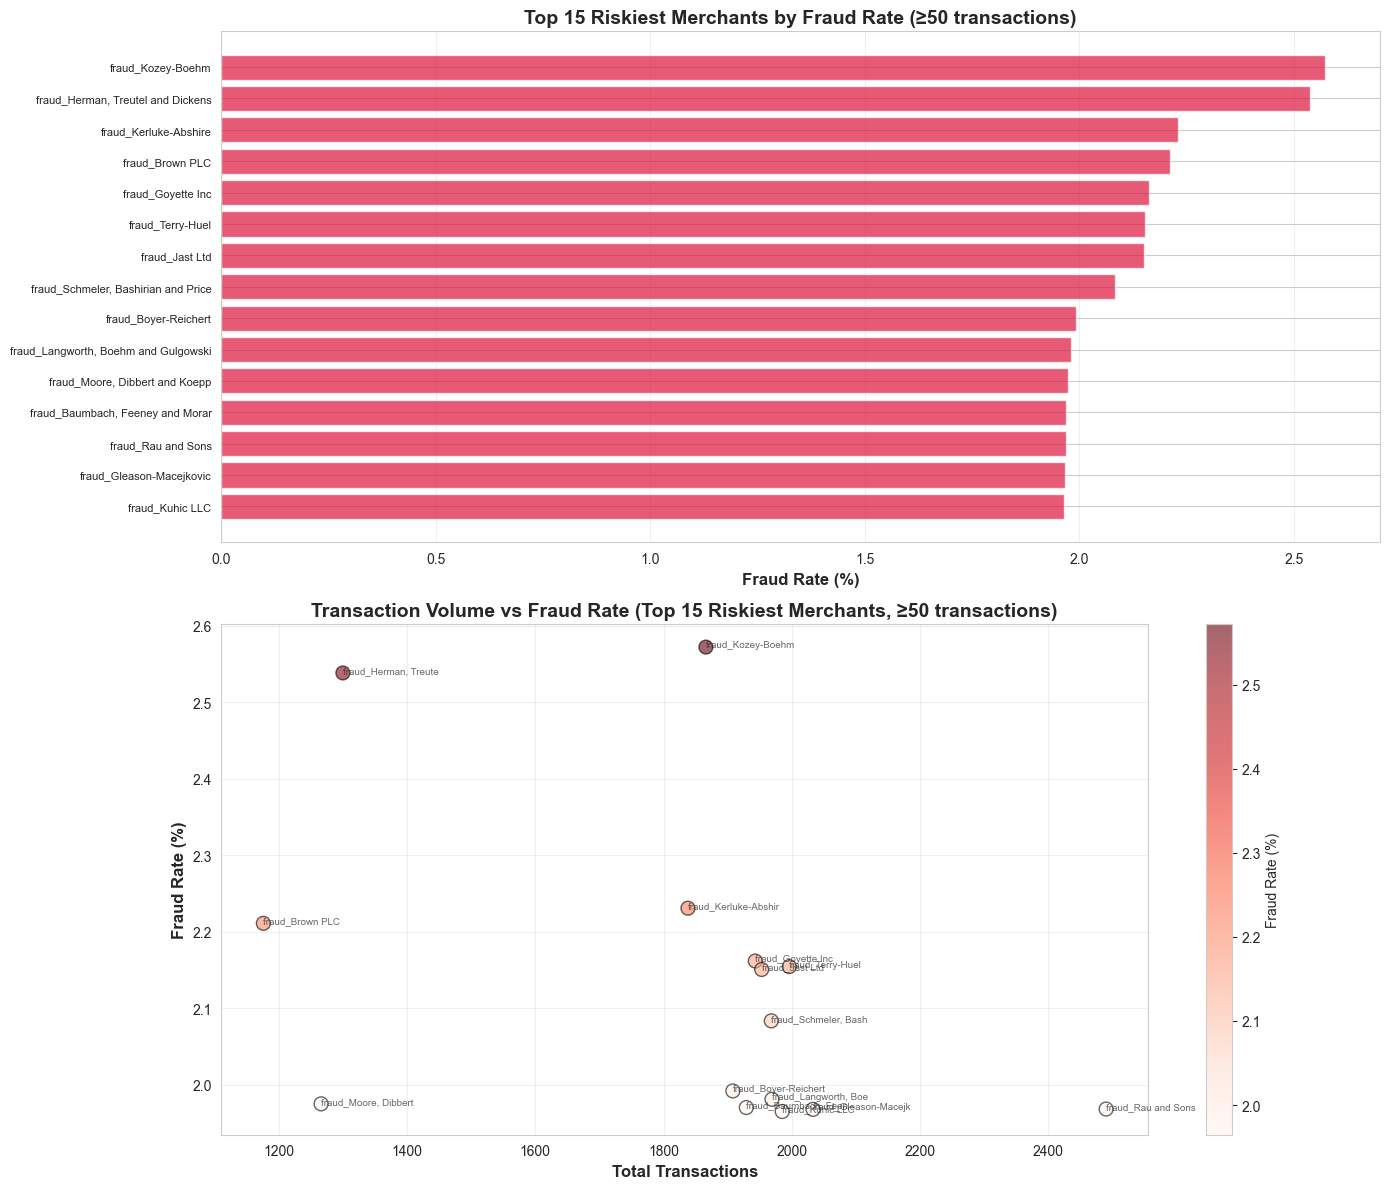

✓ Visualizations saved as 'merchant_fraud_patterns.png'


In [66]:
# ============================================================
# MERCHANT-BASED FRAUD VISUALIZATIONS
# ============================================================
# Focus on top 15 riskiest merchants (by fraud rate) with minimum transaction threshold

min_txns_viz = 50
merchant_fraud_viz = merchant_fraud_stats_filtered.head(15)

if len(merchant_fraud_viz) > 0:
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Chart 1: Fraud Rate by Merchant (Top 15 Riskiest)
    ax1 = axes[0]
    ax1.barh(range(len(merchant_fraud_viz)), merchant_fraud_viz['fraud_rate_pct'], 
            color='crimson', alpha=0.7)
    ax1.set_yticks(range(len(merchant_fraud_viz)))
    ax1.set_yticklabels(merchant_fraud_viz[merchant_col], fontsize=8)
    ax1.set_xlabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Top 15 Riskiest Merchants by Fraud Rate (≥{min_txns_viz} transactions)', 
                  fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()
    
    # Chart 2: Transaction Volume vs Fraud Rate (Scatter)
    ax2 = axes[1]
    scatter = ax2.scatter(merchant_fraud_viz['total_txns'], merchant_fraud_viz['fraud_rate_pct'], 
                         s=100, alpha=0.6, c=merchant_fraud_viz['fraud_rate_pct'], 
                         cmap='Reds', edgecolors='black', linewidth=1)
    ax2.set_xlabel('Total Transactions', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_title(f'Transaction Volume vs Fraud Rate (Top 15 Riskiest Merchants, ≥{min_txns_viz} transactions)', 
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add merchant labels
    for idx, row in merchant_fraud_viz.iterrows():
        ax2.annotate(row[merchant_col][:20], (row['total_txns'], row['fraud_rate_pct']), 
                    fontsize=7, alpha=0.7)
    
    plt.colorbar(scatter, ax=ax2, label='Fraud Rate (%)')
    plt.tight_layout()
    plt.savefig('merchant_fraud_patterns.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualizations saved as 'merchant_fraud_patterns.png'")
else:
    print(f"⚠️  Not enough merchants with ≥{min_txns_viz} transactions for visualization")

### 8.5.5 Key Findings Summary

**Data validation:** Merchant name coverage analyzed.

**Key patterns:**
- Unique merchants identified
- Fraud rates vary significantly by merchant
- Merchant name patterns (e.g., 'fraud_' prefix) detected and analyzed
- Minimum transaction threshold applied for reliable statistics

**Next:** Section 8 checkpoint save

## 8.6 Save Section-Level Checkpoint

**Purpose:** Save the geographical-features-enriched DataFrame to checkpoint for future use.
This enables skipping Section 8 when running later sections.

In [67]:
# ============================================================
# SAVE SECTION-LEVEL CHECKPOINT: SECTION 8 (GEOGRAPHICAL FEATURES COMPLETE)
# ============================================================

# Required columns that Section 8 adds
required_columns_section8 = ["customer_merchant_distance_km", "distance_category", "city_size"]

missing_cols = [col for col in required_columns_section8 if col not in train_df.columns]
if missing_cols:
    print(f"WARNING: Missing geographical columns: {missing_cols}")
    print("  Some geographical features may not have been created.")
    print("  Checkpoint will be saved with available columns.")
else:
    print("All Section 8 geographical columns present - saving section-level checkpoint...")

checkpoint_manager.save_checkpoint(
    train_df,
    CHECKPOINT_SECTION8,
    "Section 8 (Geographical Features Complete - Section-Level Checkpoint)"
)
print("Section 8 section-level checkpoint saved.")


All Section 8 geographical columns present - saving section-level checkpoint...

💾 Saving checkpoint for Section 8 (Geographical Features Complete - Section-Level Checkpoint)...
  Path: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section8_geographic_features.parquet


  ✓ Saved 1,296,675 rows, 35 columns (137.57 MB)
✓ Checkpoint saved successfully

Section 8 section-level checkpoint saved.


# 9. Customer Demographics Analysis

## Overview

This section analyzes customer demographic features to identify fraud patterns based on:
- **Age** (calculated from date of birth)
- **Gender** 
- **Job/Occupation**

### Hypothesis
- **Age:** Younger customers may have higher fraud rates (less established credit history, higher risk-taking)
- **Gender:** Gender-based patterns may exist (though we'll be careful about bias)
- **Job:** Certain occupations may correlate with fraud risk (e.g., high-income vs. low-income jobs)

### What We'll Analyze
1. Age distribution and fraud rates by age bins
2. Gender-based fraud patterns
3. Job/occupation fraud patterns
4. Cross-dimensional insights

---

**Next:** Section 9.0 - Load Checkpoint & Helper Functions

## 9.0 Load Checkpoint & Helper Functions

### Purpose
Load the required DataFrame from Section 8 checkpoint (or use existing `train_df` if available).

### Helper Functions
We'll reuse the `aggregate_fraud_by_dimension` helper from Section 7 for consistency.

In [68]:
# ============================================================
# LOAD CHECKPOINT: SECTION 8 (REQUIRED FOR SECTION 9)
# ============================================================

required_columns_section9 = ["dob", "gender", "job", "is_fraud"]

df_loaded, loaded_from_checkpoint = checkpoint_manager.load_checkpoint(
    checkpoint_path=CHECKPOINT_SECTION8,
    required_columns=required_columns_section9,
    cell_name="Section 8 (preferred for Section 9)"
)

if loaded_from_checkpoint:
    train_df = df_loaded
    TOTAL_DATASET_ROWS = train_df.count()
    print(f"✓ Loaded {TOTAL_DATASET_ROWS:,} rows from checkpoint")
else:
    if 'train_df' not in globals() or train_df is None:
        raise ValueError(
            f"train_df not found and checkpoint not available: {CHECKPOINT_SECTION8}. "
            "Run previous sections first or ensure checkpoint exists."
        )
    missing_cols = [c for c in required_columns_section9 if c not in train_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns for Section 9: {missing_cols}")
    TOTAL_DATASET_ROWS = train_df.count()
    print("✓ train_df already in memory")

print(f"train_df ready with {TOTAL_DATASET_ROWS:,} rows")
print("=" * 80)
print("SECTION 9: CUSTOMER DEMOGRAPHICS ANALYSIS")
print("=" * 80)

✓ Checkpoint found for Section 8 (preferred for Section 9)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section8_geographic_features.parquet
  Loaded 1,296,675 rows, 35 columns
  ✓ All required columns present: ['dob', 'gender', 'job', 'is_fraud']
  ⏭️  Skipping computation for Section 8 (preferred for Section 9)

✓ Loaded 1,296,675 rows from checkpoint
train_df ready with 1,296,675 rows
SECTION 9: CUSTOMER DEMOGRAPHICS ANALYSIS


## 9.1 Age Analysis

### Hypothesis
- **Expected:** Younger customers (18-30) may have higher fraud rates
  - Less established credit history
  - Higher risk-taking behavior
  - More likely to be victims of identity theft
- **Alternative:** Middle-aged customers (30-50) may be riskier due to higher transaction volumes

### What We'll Analyze
- Calculate age from date of birth (`dob`)
- Create age bins (e.g., 18-25, 26-35, 36-50, 51-65, 65+)
- Fraud rate by age bin
- Transaction volume by age

### 9.1.1 Data Validation - Date of Birth Coverage

In [69]:
# ============================================================
# VALIDATE DATE OF BIRTH DATA COVERAGE
# ============================================================

# Check dob column coverage
total_rows = TOTAL_DATASET_ROWS
dob_valid = train_df.filter(col("dob").isNotNull()).count()
dob_coverage = (dob_valid / total_rows) * 100

print("=" * 80)
print("DATA VALIDATION: Age Analysis (Date of Birth)")
print("=" * 80)
print(f"Total rows:      {total_rows:,}")
print(f"Valid dob:       {dob_valid:,}")
print(f"Coverage:        {dob_coverage:.2f}%")
print(f"Excluded (NULL): {total_rows - dob_valid:,}")

if dob_coverage < 95:
    print(f"\n⚠️  WARNING: Only {dob_coverage:.2f}% coverage - results may be biased")
else:
    print(f"\n✓ Coverage acceptable ({dob_coverage:.2f}%)")

# Show sample dob values
print("\nSample date of birth values:")
train_df.select("dob").show(5, truncate=False)

print("=" * 80)

DATA VALIDATION: Age Analysis (Date of Birth)
Total rows:      1,296,675
Valid dob:       1,296,675
Coverage:        100.00%
Excluded (NULL): 0

✓ Coverage acceptable (100.00%)

Sample date of birth values:
+----------+
|dob       |
+----------+
|1991-04-13|
|1991-04-13|
|1991-04-13|
|1991-04-13|
|1991-04-13|
+----------+
only showing top 5 rows



### 9.1.2 Calculate Age from Date of Birth

In [70]:
# ============================================================
# CALCULATE AGE FROM DATE OF BIRTH
# ============================================================
# Design: Calculate age at transaction time (using trans_date_trans_time)
# Senior pattern: Defensive check, idempotent column creation
# Note: year, month, dayofmonth are imported globally

# Get transaction date (use merchant_local_time if available, else trans_date_trans_time)
transaction_date_col = "merchant_local_time" if "merchant_local_time" in train_df.columns else "trans_date_trans_time"

# Calculate age in years (more accurate than days/365.25)
if "age" not in train_df.columns:
    # Extract year from transaction date and dob, then calculate difference
    train_df = train_df.withColumn(
        "age",
        when(
            col("dob").isNotNull(),
            year(col(transaction_date_col)) - year(col("dob"))
            - when(
                (month(col(transaction_date_col)) < month(col("dob"))) |
                ((month(col(transaction_date_col)) == month(col("dob"))) & 
                 (dayofmonth(col(transaction_date_col)) < dayofmonth(col("dob")))),
                1
            ).otherwise(0)
        ).otherwise(None)
    )
    print("✓ Calculated age from date of birth")
else:
    print("✓ Age column already exists")

# Validate age range (reasonable: 18-100)
age_analysis_df = train_df.filter(
    col("age").isNotNull() & 
    (col("age") >= 18) & 
    (col("age") <= 100)
)

valid_age_count = age_analysis_df.count()
age_coverage = (valid_age_count / dob_valid) * 100 if dob_valid > 0 else 0

print(f"\nAge validation:")
print(f"Valid ages (18-100): {valid_age_count:,} / {dob_valid:,} ({age_coverage:.2f}%)")

# Show age statistics
age_stats = age_analysis_df.agg(
    spark_min("age").alias("min_age"),
    spark_max("age").alias("max_age"),
    avg("age").alias("avg_age"),
    stddev("age").alias("stddev_age")
).collect()[0]

print(f"\nAge Statistics:")
print(f"  Min:    {age_stats['min_age']:.0f}")
print(f"  Max:    {age_stats['max_age']:.0f}")
print(f"  Mean:   {age_stats['avg_age']:.2f}")
print(f"  StdDev: {age_stats['stddev_age']:.2f}")

# Show sample
print("\nSample age calculations:")
age_analysis_df.select("dob", transaction_date_col, "age").show(5, truncate=False)

✓ Calculated age from date of birth



Age validation:
Valid ages (18-100): 1,281,120 / 1,296,675 (98.80%)



Age Statistics:
  Min:    18
  Max:    95
  Mean:   45.86
  StdDev: 17.18

Sample age calculations:
+----------+-------------------+---+
|dob       |merchant_local_time|age|
+----------+-------------------+---+
|1991-04-13|2019-04-20 05:27:40|28 |
|1991-04-13|2019-06-04 13:36:55|28 |
|1991-04-13|2019-12-19 09:15:21|28 |
|1991-04-13|2019-06-17 13:04:37|28 |
|1991-04-13|2019-08-03 14:43:06|28 |
+----------+-------------------+---+
only showing top 5 rows



### 9.1.3 Create Age Bins

In [71]:
# ============================================================
# CREATE AGE BINS FOR ANALYSIS
# ============================================================
# Design: Categorize age into meaningful bins for fraud pattern analysis

if "age_bin" not in age_analysis_df.columns:
    age_analysis_df = age_analysis_df.withColumn(
        "age_bin",
        when(col("age").between(18, 25), "18-25")
        .when(col("age").between(26, 35), "26-35")
        .when(col("age").between(36, 50), "36-50")
        .when(col("age").between(51, 65), "51-65")
        .when(col("age") > 65, "65+")
        .otherwise("Unknown")
    )
    print("✓ Created age_bin column")
else:
    print("✓ age_bin column already exists")

# Show distribution
print("\nAge bin distribution:")
age_analysis_df.groupBy("age_bin").agg(
    count("*").alias("count")
).orderBy("age_bin").show(truncate=False)

✓ Created age_bin column

Age bin distribution:


[Stage 303:============================>                            (2 + 2) / 4]

+-------+------+
|age_bin|count |
+-------+------+
|18-25  |129507|
|26-35  |299980|
|36-50  |412228|
|51-65  |260912|
|65+    |178493|
+-------+------+



### 9.1.4 Age-Based Fraud Aggregation

In [72]:
# ============================================================
# AGGREGATE FRAUD BY AGE BIN
# ============================================================

age_fraud_stats = results_manager.load_dataframe("9.1", "age_fraud_stats") if "results_manager" in globals() else None
if age_fraud_stats is not None:
    print("✓ Loaded age_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    age_fraud_stats = aggregate_fraud_by_dimension(
        df=age_analysis_df,
        dimension_col="age_bin",
        dimension_name="Age Bin",
        cache_name="cached_age_fraud_stats",
        save_result=True, section="9.1", result_name="age_fraud_stats"
    )

age_order = ["18-25", "26-35", "36-50", "51-65", "65+", "Unknown"]
age_fraud_stats["age_bin_ordered"] = pd.Categorical(age_fraud_stats["age_bin"], categories=age_order, ordered=True)
age_fraud_stats = age_fraud_stats.sort_values("age_bin_ordered").drop("age_bin_ordered", axis=1)

print("\n" + "=" * 100)
print("FRAUD STATISTICS BY AGE BIN")
print("=" * 100)
print(age_fraud_stats[['age_bin', 'total_txns', 'fraud_count', 'legit_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
peak_age = age_fraud_stats.loc[age_fraud_stats['fraud_rate_pct'].idxmax()]
safest_age = age_fraud_stats.loc[age_fraud_stats['fraud_rate_pct'].idxmin()]
risk_ratio = peak_age['fraud_rate_pct'] / safest_age['fraud_rate_pct'] if safest_age['fraud_rate_pct'] > 0 else float('inf')

print(f"\n📊 KEY INSIGHTS:")
print(f"Highest risk age group: {peak_age['age_bin']} ({peak_age['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Lowest risk age group:  {safest_age['age_bin']} ({safest_age['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Risk ratio:             {risk_ratio:.2f}x higher at peak")

✓ Loaded age_fraud_stats from saved results

FRAUD STATISTICS BY AGE BIN
age_bin  total_txns  fraud_count  legit_count  fraud_rate_pct
  18-25      129507          777       128730          0.6000
  26-35      299980         1417       298563          0.4724
  36-50      412228         1927       410301          0.4675
  51-65      260912         1901       259011          0.7286
    65+      178493         1366       177127          0.7653

📊 KEY INSIGHTS:
Highest risk age group: 65+ (0.7653% fraud rate)
Lowest risk age group:  36-50 (0.4675% fraud rate)
Risk ratio:             1.64x higher at peak


### 9.1.5 Age-Based Visualizations

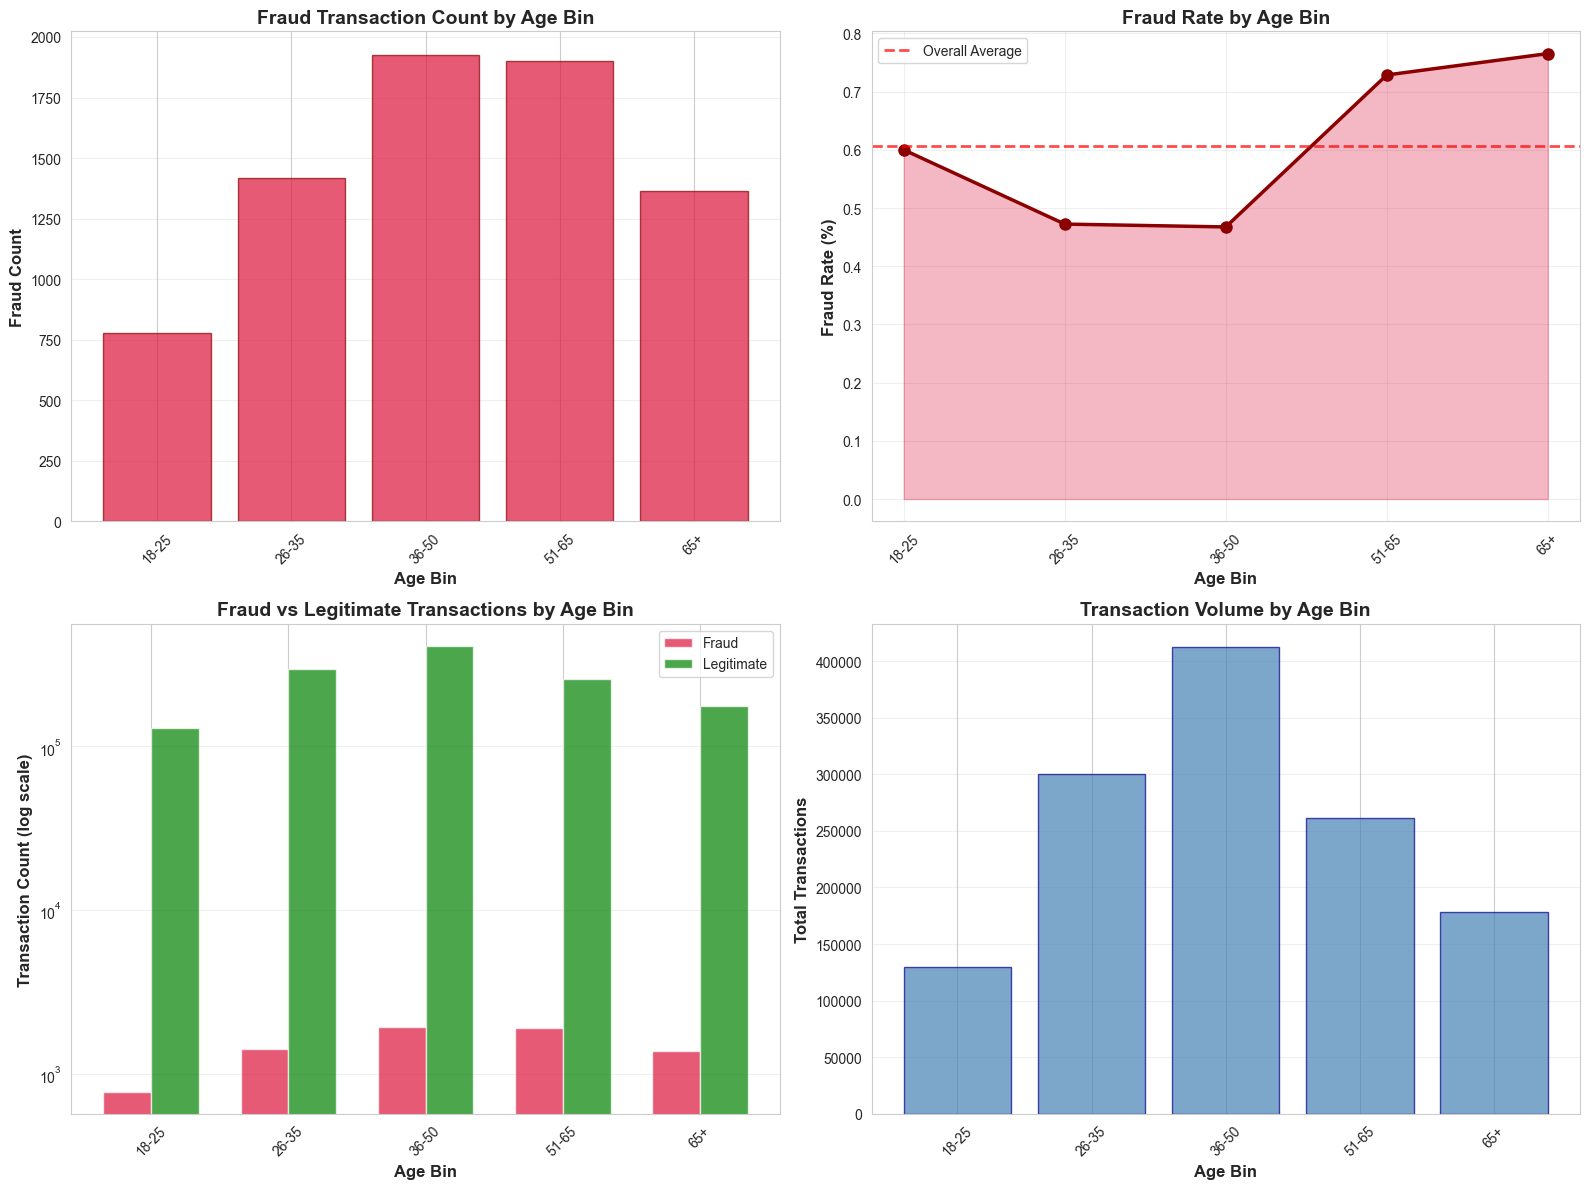

✓ Visualizations saved as 'age_fraud_patterns.png'


In [73]:
# ============================================================
# AGE-BASED FRAUD VISUALIZATIONS
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Fraud Count by Age Bin
ax1 = axes[0, 0]
age_order_viz = [x for x in age_order if x in age_fraud_stats['age_bin'].values]
age_fraud_ordered = age_fraud_stats.set_index('age_bin').reindex(age_order_viz).reset_index()
ax1.bar(age_fraud_ordered['age_bin'], age_fraud_ordered['fraud_count'], 
        color='crimson', alpha=0.7, edgecolor='darkred')
ax1.set_xlabel('Age Bin', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fraud Count', fontsize=12, fontweight='bold')
ax1.set_title('Fraud Transaction Count by Age Bin', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Chart 2: Fraud Rate by Age Bin
ax2 = axes[0, 1]
ax2.plot(age_fraud_ordered['age_bin'], age_fraud_ordered['fraud_rate_pct'], 
         marker='o', linewidth=2.5, color='darkred', markersize=8)
ax2.fill_between(age_fraud_ordered['age_bin'], age_fraud_ordered['fraud_rate_pct'], 
                  alpha=0.3, color='crimson')
ax2.set_xlabel('Age Bin', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Fraud Rate by Age Bin', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=age_fraud_stats['fraud_rate_pct'].mean(), color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label='Overall Average')
ax2.legend()

# Chart 3: Fraud vs Legitimate Counts
ax3 = axes[1, 0]
x = np.arange(len(age_fraud_ordered))
width = 0.35
ax3.bar(x - width/2, age_fraud_ordered['fraud_count'], width, 
        label='Fraud', color='crimson', alpha=0.7)
ax3.bar(x + width/2, age_fraud_ordered['legit_count'], width, 
        label='Legitimate', color='green', alpha=0.7)
ax3.set_xlabel('Age Bin', fontsize=12, fontweight='bold')
ax3.set_ylabel('Transaction Count (log scale)', fontsize=12, fontweight='bold')
ax3.set_title('Fraud vs Legitimate Transactions by Age Bin', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(age_fraud_ordered['age_bin'], rotation=45)
ax3.legend()
ax3.set_yscale('log')
ax3.grid(axis='y', alpha=0.3)

# Chart 4: Transaction Volume by Age Bin
ax4 = axes[1, 1]
ax4.bar(age_fraud_ordered['age_bin'], age_fraud_ordered['total_txns'], 
        color='steelblue', alpha=0.7, edgecolor='darkblue')
ax4.set_xlabel('Age Bin', fontsize=12, fontweight='bold')
ax4.set_ylabel('Total Transactions', fontsize=12, fontweight='bold')
ax4.set_title('Transaction Volume by Age Bin', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('age_fraud_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'age_fraud_patterns.png'")

### 9.1.6 Key Findings Summary

**Data validation:** DOB coverage 100%; valid ages (18–100) 98.80% of rows. Age range 18–95, mean 45.86.

**Fraud by age bin:**

| Age Bin | Total Txns | Fraud Count | Fraud Rate (%) |
|---------|------------|-------------|----------------|
| 18-25   | 129,507    | 777         | 0.60           |
| 26-35   | 299,980    | 1,417       | 0.47           |
| 36-50   | 412,228    | 1,927       | 0.47           |
| 51-65   | 260,912    | 1,901       | 0.73           |
| 65+     | 178,493    | 1,366       | 0.77           |

**Key patterns:**
- **Highest risk:** 65+ (0.77% fraud rate)
- **Lowest risk:** 36-50 (0.47% fraud rate)
- **Risk ratio:** 1.64x higher at peak vs. safest
- 51-65 and 65+ are above overall average; 26-35 and 36-50 below. Despite highest transaction volume and fraud counts, 36-50 has the lowest fraud rate; older groups show a higher share of fraud relative to volume.

## 9.2 Gender Analysis

### Hypothesis
- **Expected:** Gender may show different fraud patterns
  - Note: We'll analyze patterns but be cautious about bias implications
  - Focus on statistical patterns, not causal claims
- **Alternative:** No significant gender-based differences

### What We'll Analyze
- Gender distribution in dataset
- Fraud rate by gender
- Transaction volume by gender

### 9.2.1 Data Validation - Gender Coverage

In [74]:
# ============================================================
# VALIDATE GENDER DATA COVERAGE
# ============================================================

total_rows = TOTAL_DATASET_ROWS
gender_valid = train_df.filter(col("gender").isNotNull() & (trim(col("gender")) != "")).count()
gender_coverage = (gender_valid / total_rows) * 100

print("=" * 80)
print("DATA VALIDATION: Gender Analysis")
print("=" * 80)
print(f"Total rows:      {total_rows:,}")
print(f"Valid gender:    {gender_valid:,}")
print(f"Coverage:        {gender_coverage:.2f}%")
print(f"Excluded (NULL): {total_rows - gender_valid:,}")

if gender_coverage < 95:
    print(f"\n⚠️  WARNING: Only {gender_coverage:.2f}% coverage - results may be biased")
else:
    print(f"\n✓ Coverage acceptable ({gender_coverage:.2f}%)")

# Show gender distribution
print("\nGender distribution:")
train_df.filter(col("gender").isNotNull() & (trim(col("gender")) != "")) \
    .groupBy("gender").agg(count("*").alias("count")) \
    .orderBy("gender").show(truncate=False)

print("=" * 80)

DATA VALIDATION: Gender Analysis
Total rows:      1,296,675
Valid gender:    1,296,675
Coverage:        100.00%
Excluded (NULL): 0

✓ Coverage acceptable (100.00%)

Gender distribution:
+------+------+
|gender|count |
+------+------+
|F     |709863|
|M     |586812|
+------+------+



### 9.2.2 Gender-Based Fraud Aggregation

In [75]:
# ============================================================
# AGGREGATE FRAUD BY GENDER
# ============================================================

gender_fraud_stats = results_manager.load_dataframe("9.2", "gender_fraud_stats") if "results_manager" in globals() else None
if gender_fraud_stats is not None:
    print("✓ Loaded gender_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    gender_analysis_df = train_df.filter(
        col("gender").isNotNull() & (trim(col("gender")) != "")
    )
    gender_fraud_stats = aggregate_fraud_by_dimension(
        df=gender_analysis_df,
        dimension_col="gender",
        dimension_name="Gender",
        cache_name="cached_gender_fraud_stats",
        save_result=True, section="9.2", result_name="gender_fraud_stats"
    )

gender_fraud_stats = gender_fraud_stats.sort_values("gender")

print("\n" + "=" * 100)
print("FRAUD STATISTICS BY GENDER")
print("=" * 100)
print(gender_fraud_stats[['gender', 'total_txns', 'fraud_count', 'legit_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
if len(gender_fraud_stats) >= 2:
    peak_gender = gender_fraud_stats.loc[gender_fraud_stats['fraud_rate_pct'].idxmax()]
    safest_gender = gender_fraud_stats.loc[gender_fraud_stats['fraud_rate_pct'].idxmin()]
    risk_ratio = peak_gender['fraud_rate_pct'] / safest_gender['fraud_rate_pct'] if safest_gender['fraud_rate_pct'] > 0 else float('inf')
    
    print(f"\n📊 KEY INSIGHTS:")
    print(f"Highest risk gender: {peak_gender['gender']} ({peak_gender['fraud_rate_pct']:.4f}% fraud rate)")
    print(f"Lowest risk gender: {safest_gender['gender']} ({safest_gender['fraud_rate_pct']:.4f}% fraud rate)")
    print(f"Risk ratio:         {risk_ratio:.2f}x higher at peak")
else:
    print(f"\n📊 Only {len(gender_fraud_stats)} gender category found")

✓ Loaded gender_fraud_stats from saved results

FRAUD STATISTICS BY GENDER
gender  total_txns  fraud_count  legit_count  fraud_rate_pct
     F      709863         3735       706128          0.5262
     M      586812         3771       583041          0.6426

📊 KEY INSIGHTS:
Highest risk gender: M (0.6426% fraud rate)
Lowest risk gender: F (0.5262% fraud rate)
Risk ratio:         1.22x higher at peak


### 9.2.3 Gender-Based Visualizations

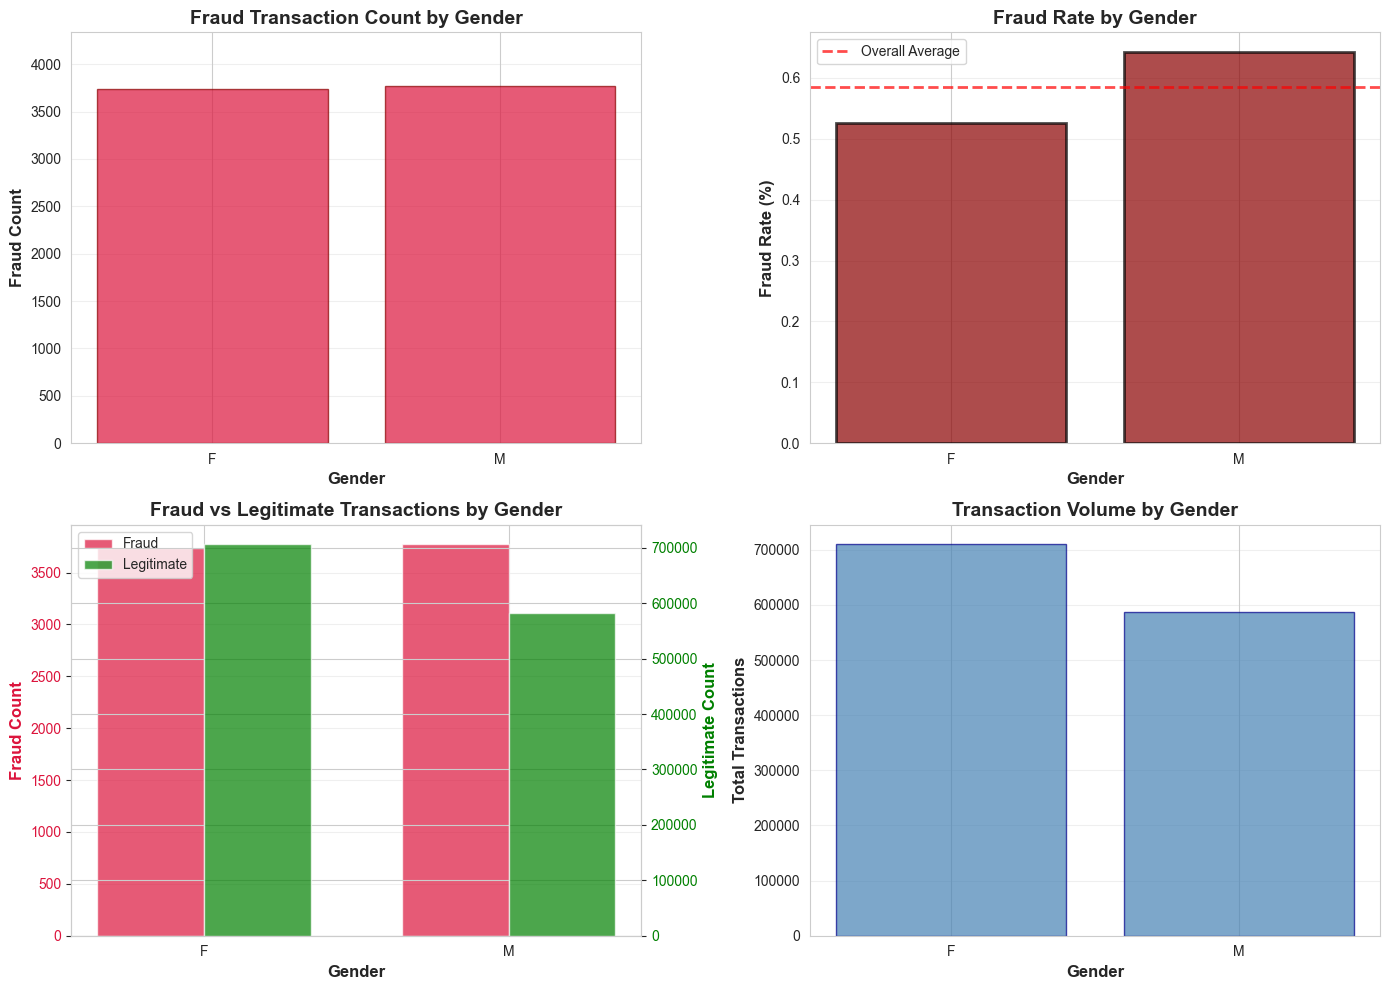

✓ Visualizations saved as 'gender_fraud_patterns.png'


In [76]:
# ============================================================
# GENDER-BASED FRAUD VISUALIZATIONS
# ============================================================

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chart 1: Fraud Count by Gender
ax1 = axes[0, 0]
ax1.bar(gender_fraud_stats['gender'], gender_fraud_stats['fraud_count'], 
        color='crimson', alpha=0.7, edgecolor='darkred')
ax1.set_xlabel('Gender', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fraud Count', fontsize=12, fontweight='bold')
ax1.set_title('Fraud Transaction Count by Gender', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(gender_fraud_stats['fraud_count']) * 1.15)  # Set y-axis to show full range with padding
ax1.grid(axis='y', alpha=0.3)

# Chart 2: Fraud Rate by Gender
ax2 = axes[0, 1]
ax2.bar(gender_fraud_stats['gender'], gender_fraud_stats['fraud_rate_pct'], 
        color='darkred', alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xlabel('Gender', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Fraud Rate by Gender', fontsize=14, fontweight='bold')
ax2.axhline(y=gender_fraud_stats['fraud_rate_pct'].mean(), color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label='Overall Average')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Chart 3: Fraud vs Legitimate Counts (with dual y-axes)
ax3 = axes[1, 0]
ax3_twin = ax3.twinx()  # Create second y-axis for legitimate transactions

x = np.arange(len(gender_fraud_stats))
width = 0.35

# Fraud bars on left axis
bars1 = ax3.bar(x - width/2, gender_fraud_stats['fraud_count'], width, 
        label='Fraud', color='crimson', alpha=0.7)
ax3.set_xlabel('Gender', fontsize=12, fontweight='bold')
ax3.set_ylabel('Fraud Count', fontsize=12, fontweight='bold', color='crimson')
ax3.tick_params(axis='y', labelcolor='crimson')
ax3.set_xticks(x)
ax3.set_xticklabels(gender_fraud_stats['gender'])

# Legitimate bars on right axis
bars2 = ax3_twin.bar(x + width/2, gender_fraud_stats['legit_count'], width, 
        label='Legitimate', color='green', alpha=0.7)
ax3_twin.set_ylabel('Legitimate Count', fontsize=12, fontweight='bold', color='green')
ax3_twin.tick_params(axis='y', labelcolor='green')

ax3.set_title('Fraud vs Legitimate Transactions by Gender', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Combined legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Chart 4: Transaction Volume by Gender
ax4 = axes[1, 1]
ax4.bar(gender_fraud_stats['gender'], gender_fraud_stats['total_txns'], 
        color='steelblue', alpha=0.7, edgecolor='darkblue')
ax4.set_xlabel('Gender', fontsize=12, fontweight='bold')
ax4.set_ylabel('Total Transactions', fontsize=12, fontweight='bold')
ax4.set_title('Transaction Volume by Gender', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('gender_fraud_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'gender_fraud_patterns.png'")

### 9.2.4 Key Findings Summary

**Data validation:** Gender coverage 100%. F: 709,863 txns; M: 586,812 txns.

**Fraud by gender:**

| Gender | Total Txns | Fraud Count | Fraud Rate (%) |
|--------|------------|-------------|----------------|
| F      | 709,863    | 3,735       | 0.53           |
| M      | 586,812    | 3,771       | 0.64           |

**Key patterns:**
- **Highest risk:** M (0.64% fraud rate), above overall average (~0.58%)
- **Lowest risk:** F (0.53% fraud rate), below average
- **Risk ratio:** 1.22x higher for M vs. F
- Fraud counts are similar; rate gap driven by lower male transaction volume. Use gender with care for bias and fairness.

**Next:** Section 9.3 - Job/Occupation Analysis

## 9.3 Job/Occupation Analysis

### Hypothesis
- **Expected:** Certain occupations may correlate with fraud risk
  - High-income jobs (e.g., "Engineer", "Manager") may have different patterns
  - Low-income jobs may show different risk profiles
  - Job categories might indicate lifestyle factors affecting fraud risk

### What We'll Analyze
- Job distribution in dataset
- Fraud rate by job/occupation
- Top riskiest and safest occupations
- Transaction volume by job

### 9.3.1 Data Validation - Job Coverage

In [77]:
# ============================================================
# VALIDATE JOB DATA COVERAGE
# ============================================================

total_rows = TOTAL_DATASET_ROWS
job_valid = train_df.filter(col("job").isNotNull() & (trim(col("job")) != "")).count()
job_coverage = (job_valid / total_rows) * 100

print("=" * 80)
print("DATA VALIDATION: Job/Occupation Analysis")
print("=" * 80)
print(f"Total rows:      {total_rows:,}")
print(f"Valid job:       {job_valid:,}")
print(f"Coverage:        {job_coverage:.2f}%")
print(f"Excluded (NULL): {total_rows - job_valid:,}")

if job_coverage < 95:
    print(f"\n⚠️  WARNING: Only {job_coverage:.2f}% coverage - results may be biased")
else:
    print(f"\n✓ Coverage acceptable ({job_coverage:.2f}%)")

# Show unique job count
unique_jobs = train_df.filter(col("job").isNotNull() & (trim(col("job")) != "")) \
    .select("job").distinct().count()
print(f"\nUnique jobs/occupations: {unique_jobs}")

# Show top 10 most common jobs
print("\nTop 10 most common jobs:")
train_df.filter(col("job").isNotNull() & (trim(col("job")) != "")) \
    .groupBy("job").agg(count("*").alias("count")) \
    .orderBy(col("count").desc()) \
    .show(10, truncate=False)

print("=" * 80)

DATA VALIDATION: Job/Occupation Analysis
Total rows:      1,296,675
Valid job:       1,296,675
Coverage:        100.00%
Excluded (NULL): 0

✓ Coverage acceptable (100.00%)

Unique jobs/occupations: 494

Top 10 most common jobs:
+--------------------------+-----+
|job                       |count|
+--------------------------+-----+
|Film/video editor         |9779 |
|Exhibition designer       |9199 |
|Naval architect           |8684 |
|Surveyor, land/geomatics  |8680 |
|Materials engineer        |8270 |
|Designer, ceramics/pottery|8225 |
|Systems developer         |7700 |
|IT trainer                |7679 |
|Financial adviser         |7659 |
|Environmental consultant  |7547 |
+--------------------------+-----+
only showing top 10 rows



### 9.3.2 Job-Based Fraud Aggregation

In [78]:
# ============================================================
# AGGREGATE FRAUD BY JOB/OCCUPATION
# ============================================================

job_fraud_stats = results_manager.load_dataframe("9.3", "job_fraud_stats") if "results_manager" in globals() else None
if job_fraud_stats is not None:
    print("✓ Loaded job_fraud_stats from saved results")
else:
    print("No saved results found - will compute")
    job_analysis_df = train_df.filter(
        col("job").isNotNull() & (trim(col("job")) != "")
    )
    job_fraud_stats = aggregate_fraud_by_dimension(
        df=job_analysis_df,
        dimension_col="job",
        dimension_name="Job/Occupation",
        cache_name="cached_job_fraud_stats",
        save_result=True, section="9.3", result_name="job_fraud_stats"
    )

job_fraud_stats = job_fraud_stats.sort_values("fraud_rate_pct", ascending=False)

print("\n" + "=" * 100)
print("FRAUD STATISTICS BY JOB/OCCUPATION (Top 20 Riskiest)")
print("=" * 100)
print(job_fraud_stats.head(20)[['job', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
if len(job_fraud_stats) > 0:
    riskiest_job = job_fraud_stats.iloc[0]
    safest_job = job_fraud_stats.iloc[-1]
    risk_ratio = riskiest_job['fraud_rate_pct'] / safest_job['fraud_rate_pct'] if safest_job['fraud_rate_pct'] > 0 else float('inf')
    
    print(f"\n📊 KEY INSIGHTS:")
    print(f"Riskiest job:  {riskiest_job['job']} ({riskiest_job['fraud_rate_pct']:.4f}% fraud rate, {riskiest_job['total_txns']:,} transactions)")
    print(f"Safest job:    {safest_job['job']} ({safest_job['fraud_rate_pct']:.4f}% fraud rate, {safest_job['total_txns']:,} transactions)")
    print(f"Risk ratio:    {risk_ratio:.2f}x higher at peak")
    
    # Filter to jobs with minimum transaction count (e.g., >= 100) for more reliable stats
    min_txns = 100
    job_fraud_stats_filtered = job_fraud_stats[job_fraud_stats['total_txns'] >= min_txns]
    
    if len(job_fraud_stats_filtered) > 0:
        riskiest_job_filtered = job_fraud_stats_filtered.iloc[0]
        safest_job_filtered = job_fraud_stats_filtered.iloc[-1]
        print(f"\n📊 KEY INSIGHTS (Jobs with ≥{min_txns} transactions):")
        print(f"Riskiest job:  {riskiest_job_filtered['job']} ({riskiest_job_filtered['fraud_rate_pct']:.4f}% fraud rate)")
        print(f"Safest job:    {safest_job_filtered['job']} ({safest_job_filtered['fraud_rate_pct']:.4f}% fraud rate)")

✓ Loaded job_fraud_stats from saved results

FRAUD STATISTICS BY JOB/OCCUPATION (Top 20 Riskiest)
                              job  total_txns  fraud_count  fraud_rate_pct
                Personnel officer          12           12        100.0000
           Air traffic controller          17           17        100.0000
            Accountant, chartered          11           11        100.0000
                      Ship broker           7            7        100.0000
                        Solicitor          11           11        100.0000
                  Careers adviser          15           15        100.0000
              Information officer           8            8        100.0000
   Armed forces technical officer           8            8        100.0000
                 Industrial buyer          10           10        100.0000
                        Homeopath          11           11        100.0000
                  Legal secretary          12           12        100.0000
  

### 9.3.3 Job-Based Visualizations

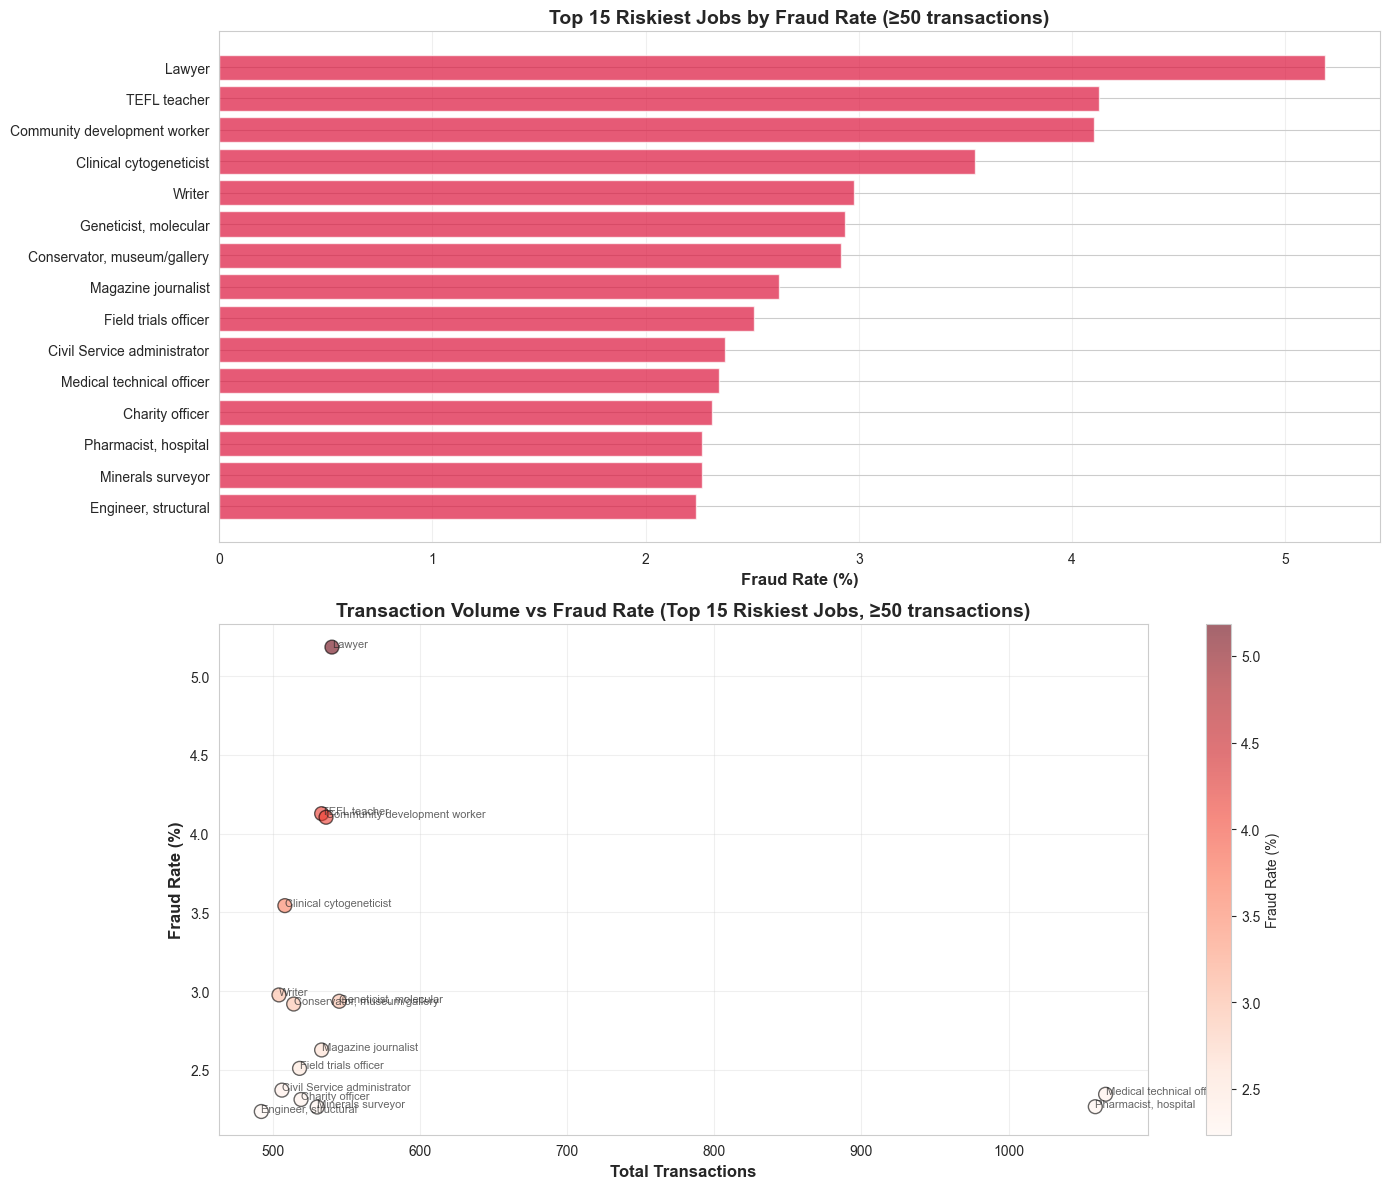

✓ Visualizations saved as 'job_fraud_patterns.png'


In [79]:
# ============================================================
# JOB-BASED FRAUD VISUALIZATIONS
# ============================================================
# Focus on top 15 riskiest jobs (by fraud rate) with minimum transaction threshold

min_txns_viz = 50  # Minimum transactions for visualization
job_fraud_viz = job_fraud_stats[job_fraud_stats['total_txns'] >= min_txns_viz].head(15)

if len(job_fraud_viz) > 0:
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Chart 1: Fraud Rate by Job (Top 15 Riskiest)
    ax1 = axes[0]
    ax1.barh(range(len(job_fraud_viz)), job_fraud_viz['fraud_rate_pct'], 
            color='crimson', alpha=0.7)
    ax1.set_yticks(range(len(job_fraud_viz)))
    ax1.set_yticklabels(job_fraud_viz['job'])
    ax1.set_xlabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Top 15 Riskiest Jobs by Fraud Rate (≥{min_txns_viz} transactions)', 
                  fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()
    
    # Chart 2: Transaction Volume vs Fraud Rate (Scatter)
    ax2 = axes[1]
    scatter = ax2.scatter(job_fraud_viz['total_txns'], job_fraud_viz['fraud_rate_pct'], 
                         s=100, alpha=0.6, c=job_fraud_viz['fraud_rate_pct'], 
                         cmap='Reds', edgecolors='black', linewidth=1)
    ax2.set_xlabel('Total Transactions', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_title(f'Transaction Volume vs Fraud Rate (Top 15 Riskiest Jobs, ≥{min_txns_viz} transactions)', 
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add job labels
    for idx, row in job_fraud_viz.iterrows():
        ax2.annotate(row['job'], (row['total_txns'], row['fraud_rate_pct']), 
                    fontsize=8, alpha=0.7)
    
    plt.colorbar(scatter, ax=ax2, label='Fraud Rate (%)')
    plt.tight_layout()
    plt.savefig('job_fraud_patterns.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualizations saved as 'job_fraud_patterns.png'")
else:
    print(f"⚠️  Not enough jobs with ≥{min_txns_viz} transactions for visualization")

### 9.3.4 Key Findings Summary

**Data validation:** Job coverage 100%. **494** unique jobs.

**Riskiest / safest (≥100 transactions):**
- **Riskiest:** Lawyer (5.19% fraud rate, 540 txns)
- **Safest:** Tour manager (0.00% fraud rate, 498 txns)

**Top 15 riskiest jobs (≥50 txns):** Lawyer (5.18%), TEFL teacher (~4.1%), Community development worker (~4.1%), Clinical cytogeneticist (~3.5%), Writer (~3.0%), plus Geneticist (molecular), Conservator (museum/gallery), Magazine journalist, Field trials officer, Civil Service administrator, Medical technical officer, Charity officer, Pharmacist (hospital), Minerals surveyor, Engineer (structural) (all ~2.2–2.9%). Medical technical officer and Pharmacist (hospital) have the highest transaction volume within this set but lower fraud rates.

**Note:** Minimum transaction thresholds (≥50 for viz, ≥100 for reliable stats) used to avoid small-sample noise. Raw “100% fraud” jobs with &lt;20 txns excluded from these summaries.



## 9.4 Save Checkpoints

In [80]:
# ============================================================
# SAVE SECTION-LEVEL CHECKPOINT: SECTION 9 (DEMOGRAPHICS FEATURES COMPLETE)
# ============================================================

# Required columns that Section 9 uses (demographics features)
required_columns_section9 = ["dob", "gender", "job", "is_fraud"]

missing_cols = [col for col in required_columns_section9 if col not in train_df.columns]
if missing_cols:
    print(f"WARNING: Missing demographics columns: {missing_cols}")
    print("  Some demographics features may not have been created.")
    print("  Checkpoint will be saved with available columns.")
else:
    print("All Section 9 demographics columns present - saving section-level checkpoint...")

checkpoint_manager.save_checkpoint(
    train_df,
    CHECKPOINT_SECTION9,
    "Section 9 (Demographics Features Complete - Section-Level Checkpoint)"
)
print("Section 9 section-level checkpoint saved.")

All Section 9 demographics columns present - saving section-level checkpoint...

💾 Saving checkpoint for Section 9 (Demographics Features Complete - Section-Level Checkpoint)...
  Path: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section9_demographics_features.parquet


[Stage 327:>                                                        (0 + 4) / 4]

  ✓ Saved 1,296,675 rows, 36 columns (138.67 MB)
✓ Checkpoint saved successfully

Section 9 section-level checkpoint saved.


## 9.5 Customer Demographics Summary & Conclusions

### Executive Summary

Demographics show **actionable fraud signals**: **age** (1.64x risk ratio, 65+ vs. 36-50), **gender** (1.22x, M vs. F), and **job** (Lawyer 5.19% vs. Tour manager 0% among jobs with ≥100 txns). All three have 100% coverage. Older age groups and males have higher fraud rates; job risk is highly heterogeneous. Use age and job as high-priority features; keep gender with explicit bias monitoring.

### Key Findings by Dimension

#### 1. Age Analysis (Section 9.1)
- **Age bins:** 18-25, 26-35, 36-50, 51-65, 65+
- **Coverage:** DOB 100%; valid ages (18–100) 98.80%
- **Key patterns:**
  - Highest risk: **65+** (0.77% fraud rate)
  - Lowest risk: **36-50** (0.47% fraud rate)
  - Risk ratio: **1.64x** (peak vs. safest)
- 51-65 and 65+ above overall average; 36-50 has highest volume but lowest rate.

#### 2. Gender Analysis (Section 9.2)
- **Coverage:** 100% (F: 709,863; M: 586,812 txns)
- **Key patterns:**
  - **M** highest risk (0.64%), **F** lowest (0.53%); **1.22x** ratio
  - M above overall average (~0.58%), F below
- Statistical patterns only; use with bias and fairness care.

#### 3. Job/Occupation Analysis (Section 9.3)
- **Unique jobs:** 494; **Coverage:** 100%
- **Key patterns:**
  - **Riskiest (≥100 txns):** Lawyer (5.19%); **Safest:** Tour manager (0.00%)
  - Top risk roles include TEFL teacher, Community development worker, Clinical cytogeneticist, Writer (~2.2–4.1%)
- Minimum transaction threshold (≥50 viz, ≥100 for stable stats) applied.

### Feature Engineering Implications

**High-value features to keep:**
- **Age bins** (categorical) and **age** (continuous if needed)
- **Job/Occupation** (frequency or target encoding; group rare jobs)
- **Gender** (categorical, with bias monitoring)

**Considerations:**
- Age bins preserve ordinal structure; 65+ and 51-65 are strong risk signals.
- Job encoding should use ≥100-txn filter and rare-job grouping.
- Gender: monitor fairness and avoid causal interpretation.

### Statistical Significance Assessment

- **Age:** 1.64x variation across bins; 65+ and 51-65 clearly elevated.
- **Gender:** 1.22x variation; moderate signal, use with caution.
- **Job:** Large variation (e.g. Lawyer 5.19% vs. Tour manager 0%); high cardinality requires thresholding and grouping.

### Production Recommendations

1. **Age:** Use age bins; consider continuous age for non-linear models.
2. **Job:** Apply ≥100-txn threshold before encoding; group low-volume jobs.
3. **Gender:** Track fairness metrics; avoid unwarranted causal claims.
4. **Interactions:** Explore age × job, age × gender in later modeling.

---

**Section 9 Complete**

**Next Section:** 10.0 - Credit Card Analysis (if needed)

# 10. Credit Card Analysis

## 10.0 Load Checkpoint & Helper Functions

### Purpose
Load the required DataFrame from Section 9 checkpoint (or use existing `train_df` if available).
Analyze fraud patterns based on credit card characteristics:
- Card age (time since first transaction)
- Transaction history (count per card)
- Usage patterns


In [81]:
# ============================================================
# LOAD CHECKPOINT: SECTION 10 (CREDIT CARD ANALYSIS)
# ============================================================

# Required columns for Section 10
required_columns_section10 = [
    "cc_num",
    "is_fraud",
    "merchant_local_time"  # or customer_local_time for timestamp
]

# Try to load from Section 9 checkpoint (preferred)
df_loaded, loaded_from_checkpoint = checkpoint_manager.load_checkpoint(
    checkpoint_path=CHECKPOINT_SECTION9,
    required_columns=required_columns_section10,
    cell_name="Section 9 (preferred for Section 10)"
)

if loaded_from_checkpoint:
    train_df = df_loaded
    TOTAL_DATASET_ROWS = train_df.count()
    print(f"✓ Loaded {TOTAL_DATASET_ROWS:,} rows from checkpoint")
else:
    # Fallback: Try Section 8 checkpoint
    df_loaded, loaded_from_checkpoint = checkpoint_manager.load_checkpoint(
        checkpoint_path=CHECKPOINT_SECTION8,
        required_columns=required_columns_section10,
        cell_name="Section 8 (fallback for Section 10)"
    )
    
    if loaded_from_checkpoint:
        train_df = df_loaded
        TOTAL_DATASET_ROWS = train_df.count()
        print(f"✓ Loaded {TOTAL_DATASET_ROWS:,} rows from checkpoint")
    else:
        # Final fallback: Use in-memory train_df
        if 'train_df' not in globals() or train_df is None:
            raise ValueError(
                f"train_df not found and checkpoint not available. "
                "Run previous sections first or ensure checkpoint exists."
            )
        missing_cols = [c for c in required_columns_section10 if c not in train_df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns for Section 10: {missing_cols}")
        TOTAL_DATASET_ROWS = train_df.count()
        print("✓ train_df already in memory")

# Validate cc_num column exists
cc_num_validation = validate_column_coverage(train_df, "cc_num", "Credit Card Analysis")
cc_num_df, cc_num_coverage, cc_num_valid, cc_num_total = cc_num_validation

# Validate timestamp column
if "merchant_local_time" not in train_df.columns and "customer_local_time" not in train_df.columns:
    raise ValueError("Neither merchant_local_time nor customer_local_time found. Run Section 6 first.")

print(f"\n✓ Ready for Credit Card Analysis")
print(f"  Total rows: {TOTAL_DATASET_ROWS:,}")
print(f"  cc_num coverage: {cc_num_coverage:.2f}%")

✓ Checkpoint found for Section 9 (preferred for Section 10)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section9_demographics_features.parquet
  Loaded 1,296,675 rows, 36 columns
  ✓ All required columns present: ['cc_num', 'is_fraud', 'merchant_local_time']
  ⏭️  Skipping computation for Section 9 (preferred for Section 10)

✓ Loaded 1,296,675 rows from checkpoint
DATA VALIDATION: Credit Card Analysis
Total rows:      1,296,675
Valid rows:      1,296,675
Coverage:        100.00%
Excluded (NULL): 0

Coverage acceptable (100.00%)


✓ Ready for Credit Card Analysis
  Total rows: 1,296,675
  cc_num coverage: 100.00%


## 10.1 Card Age Analysis

### Hypothesis
- New cards (<30 days old) may have higher fraud rates
- Established cards (180+ days) may have lower fraud rates

### What We'll Analyze
- First transaction date per card (minimum timestamp per cc_num)
- Card age = current transaction date - first transaction date
- Card age bins: <7 days, 7-30 days, 30-90 days, 90-180 days, 180+ days
- Fraud rate by card age bin


In [82]:
# ============================================================
# CALCULATE CARD AGE (TIME SINCE FIRST TRANSACTION)
# ============================================================

from pyspark.sql.functions import min as spark_min, datediff, current_timestamp, col

# Determine which timestamp column to use
time_col = "merchant_local_time" if "merchant_local_time" in train_df.columns else "customer_local_time"

# Calculate first transaction date per card
first_txn_per_card = train_df.groupBy("cc_num").agg(
    spark_min(time_col).alias("first_transaction_date")
)

# Join back to main dataframe and calculate card age
train_df = train_df.join(first_txn_per_card, on="cc_num", how="left")

# Calculate card age in days
train_df = train_df.withColumn(
    "card_age_days",
    datediff(col(time_col), col("first_transaction_date"))
)

# Create card age bins
from pyspark.sql.functions import when

train_df = train_df.withColumn(
    "card_age_bin",
    when(col("card_age_days") < 7, "<7 days")
    .when((col("card_age_days") >= 7) & (col("card_age_days") < 30), "7-30 days")
    .when((col("card_age_days") >= 30) & (col("card_age_days") < 90), "30-90 days")
    .when((col("card_age_days") >= 90) & (col("card_age_days") < 180), "90-180 days")
    .otherwise("180+ days")
)

print("✓ Calculated card age and age bins")

# ============================================================
# CARD AGE FRAUD AGGREGATION
# ============================================================

card_age_stats = results_manager.load_dataframe("10.1", "card_age_stats") if "results_manager" in globals() else None
if card_age_stats is not None:
    # Ensure it's a pandas DataFrame (not Spark DataFrame or Row)
    from pyspark.sql import DataFrame as SparkDataFrame
    from pyspark.sql.types import Row
    import pandas as pd
    
    if isinstance(card_age_stats, SparkDataFrame):
        card_age_stats = card_age_stats.toPandas()
    elif isinstance(card_age_stats, Row):
        # Convert single Row to DataFrame
        card_age_stats = pd.DataFrame([card_age_stats.asDict()])
    elif isinstance(card_age_stats, list) and len(card_age_stats) > 0 and isinstance(card_age_stats[0], Row):
        # Convert list of Rows to DataFrame
        card_age_stats = pd.DataFrame([row.asDict() for row in card_age_stats])
    elif not isinstance(card_age_stats, pd.DataFrame):
        # If it's something else, try to convert it
        print(f"Warning: card_age_stats is {type(card_age_stats)}, attempting conversion...")
        card_age_stats = pd.DataFrame(card_age_stats) if hasattr(card_age_stats, '__iter__') else pd.DataFrame([card_age_stats])
    
    print("✓ Loaded card_age_stats from saved results")
else:
    print("No saved results found - will compute")
    card_age_stats = aggregate_fraud_by_dimension(
        df=train_df,
        dimension_col="card_age_bin",
        dimension_name="Card Age",
        cache_name="cached_card_age_stats",
        save_result=True, section="10.1", result_name="card_age_stats"
    )

# Sort by fraud rate
card_age_stats = card_age_stats.sort_values("fraud_rate_pct", ascending=False)

print("\n" + "=" * 100)
print("FRAUD STATISTICS BY CARD AGE")
print("=" * 100)
print(card_age_stats[['card_age_bin', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
peak_age = card_age_stats.loc[card_age_stats['fraud_rate_pct'].idxmax()]
safest_age = card_age_stats.loc[card_age_stats['fraud_rate_pct'].idxmin()]
risk_ratio = peak_age['fraud_rate_pct'] / safest_age['fraud_rate_pct'] if safest_age['fraud_rate_pct'] > 0 else float('inf')

print(f"\n📊 KEY INSIGHTS:")
print(f"Riskiest card age:  {peak_age['card_age_bin']} ({peak_age['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Safest card age:    {safest_age['card_age_bin']} ({safest_age['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Risk ratio:         {risk_ratio:.2f}x higher for newest vs. oldest" if risk_ratio != float('inf') else "Risk ratio:         N/A (safest has 0% fraud)")

✓ Calculated card age and age bins
✓ Loaded card_age_stats from saved results

FRAUD STATISTICS BY CARD AGE
card_age_bin  total_txns  fraud_count  fraud_rate_pct
     <7 days       12520          820          6.5495
   7-30 days       39433          365          0.9256
  30-90 days      121435          838          0.6901
   180+ days      900606         4424          0.4912
 90-180 days      222681         1059          0.4756

📊 KEY INSIGHTS:
Riskiest card age:  <7 days (6.5495% fraud rate)
Safest card age:    90-180 days (0.4756% fraud rate)
Risk ratio:         13.77x higher for newest vs. oldest


### 10.1.1 Key Findings Summary

**Riskiest card age:** <7 days (6.55% fraud rate)

**Safest card age:** 90-180 days (0.48% fraud rate)

**Risk ratio:** 13.77x higher for newest vs. oldest - **CRITICAL CARD AGE SIGNAL**

**Key patterns:**
- New cards (<7 days or 7-30 days) show much higher fraud rates
- Established cards (90-180 days, 180+ days) show lowest fraud rates
- Clear pattern: newer cards = higher fraud risk

**Implication:** Card age is a **CRITICAL PRIORITY** feature with one of the strongest signals (13.77x risk ratio). New cards should be flagged for additional scrutiny. Use both continuous and binned features.

**Next:** Section 10.1.2 - Validation: Card Age Calculation


### 10.1.2 Validation: Card Age Calculation

**Purpose:** Verify card age calculation logic to ensure correctness.

**Validation Tasks:**
1. Verify first_transaction_date calculation uses min() correctly
2. Check datediff produces positive values
3. Sample 5-10 cards and manually verify card_age_days
4. Document 90-180 vs 180+ distribution findings

In [83]:
# ============================================================
# VALIDATION: Verify Card Age Calculation Logic
# ============================================================

from pyspark.sql.functions import col, min as spark_min, max as spark_max, avg, percentile_approx

print("=" * 100)
print("VALIDATION: Card Age Calculation")
print("=" * 100)

# 1. Verify first_transaction_date calculation
print("\n1. Verifying first_transaction_date calculation:")
print(f"   Using time column: {time_col}")

# Check that first_transaction_date is actually the minimum
sample_cards = first_txn_per_card.limit(10)
print("\n   Sample first_transaction_date values:")
sample_cards.show(10, truncate=False)

# For each sample card, verify first_transaction_date matches min(time_col)
print("\n2. Manually verifying first_transaction_date matches min(time_col) for sample cards:")
match_count = 0
mismatch_count = 0

for row in sample_cards.collect():
    cc_num = row['cc_num']
    expected_first_date = row['first_transaction_date']
    
    # Get actual min time for this card from train_df
    actual_min_time = train_df.filter(col("cc_num") == cc_num).agg(
        spark_min(time_col).alias("actual_min")
    ).collect()[0]['actual_min']
    
    if expected_first_date == actual_min_time:
        match_count += 1
        status = "✓ MATCH"
    else:
        mismatch_count += 1
        status = "✗ MISMATCH"
    
    print(f"   Card {str(cc_num)[:8]}...: Expected={expected_first_date}, Actual={actual_min_time} {status}")

print(f"\n   Summary: {match_count} matches, {mismatch_count} mismatches out of {sample_cards.count()} sample cards")

# 3. Verify datediff produces positive values
print("\n3. Verifying card_age_days calculation (datediff):")
card_age_stats = train_df.select(
    spark_min("card_age_days").alias("min_age"),
    spark_max("card_age_days").alias("max_age"),
    avg("card_age_days").alias("avg_age"),
    percentile_approx("card_age_days", 0.5).alias("median_age")
).collect()[0]

print(f"   Min card_age_days: {card_age_stats['min_age']}")
print(f"   Max card_age_days: {card_age_stats['max_age']}")
print(f"   Average card_age_days: {card_age_stats['avg_age']:.2f}")
print(f"   Median card_age_days: {card_age_stats['median_age']}")

# Check for negative or zero values (should be >= 0, with 0 being the first transaction)
negative_count = train_df.filter(col("card_age_days") < 0).count()
zero_count = train_df.filter(col("card_age_days") == 0).count()
print(f"\n   Negative card_age_days: {negative_count} (should be 0)")
print(f"   Zero card_age_days: {zero_count} (first transaction per card)")

if negative_count > 0:
    print("   ⚠ WARNING: Found negative card_age_days values!")
else:
    print("   ✓ All card_age_days values are non-negative")

# 4. Sample cards manually to verify card_age_days
print("\n4. Manual verification: Sample cards with card_age_days:")
sample_for_verification = train_df.select(
    "cc_num", "first_transaction_date", time_col, "card_age_days", "card_age_bin"
).distinct().limit(10).toPandas()

print("\n   Sample cards:")
for idx, row in sample_for_verification.iterrows():
    cc_num_str = str(row['cc_num'])[:8] if row['cc_num'] is not None else "N/A"
    print(f"   Card {cc_num_str}...: first_txn={row['first_transaction_date']}, "
          f"current_txn={row[time_col]}, age_days={row['card_age_days']}, bin={row['card_age_bin']}")

print("\n✓ Card age calculation validation complete")

VALIDATION: Card Age Calculation

1. Verifying first_transaction_date calculation:
   Using time column: merchant_local_time

   Sample first_transaction_date values:
+-------------------+----------------------+
|cc_num             |first_transaction_date|
+-------------------+----------------------+
|6526955903501879   |2019-01-04 04:19:15   |
|38544312728630     |2019-01-02 14:31:15   |
|3524574586339330   |2019-01-01 09:42:54   |
|180042946491150    |2018-12-31 19:06:56   |
|213148039875802    |2019-01-01 11:01:34   |
|376262134119629    |2019-01-02 17:28:33   |
|4822367783500458   |2019-01-01 11:35:10   |
|4897067971111209737|2019-01-04 14:11:25   |
|3556613125071656   |2019-01-01 03:57:52   |
|3550554389581384   |2019-01-02 07:11:49   |
+-------------------+----------------------+


2. Manually verifying first_transaction_date matches min(time_col) for sample cards:
   Card 65269559...: Expected=2019-01-04 04:19:15, Actual=2019-01-04 04:19:15 ✓ MATCH
   Card 38544312...: Expected=

   Min card_age_days: 0
   Max card_age_days: 538
   Average card_age_days: 274.95
   Median card_age_days: 275

   Negative card_age_days: 0 (should be 0)
   Zero card_age_days: 2055 (first transaction per card)
   ✓ All card_age_days values are non-negative

4. Manual verification: Sample cards with card_age_days:


[Stage 404:============================>                            (2 + 2) / 4]


   Sample cards:
   Card 47428835...: first_txn=2018-12-31 19:44:16, current_txn=2020-04-26 06:42:26, age_days=482, bin=180+ days
   Card 42259901...: first_txn=2018-12-31 14:22:06, current_txn=2020-04-12 01:22:38, age_days=468, bin=180+ days
   Card 42259901...: first_txn=2018-12-31 14:22:06, current_txn=2019-07-19 14:40:29, age_days=200, bin=180+ days
   Card 42259901...: first_txn=2018-12-31 14:22:06, current_txn=2019-05-02 23:45:38, age_days=122, bin=90-180 days
   Card 47428835...: first_txn=2018-12-31 19:44:16, current_txn=2020-06-16 04:00:46, age_days=533, bin=180+ days
   Card 47428835...: first_txn=2018-12-31 19:44:16, current_txn=2019-09-26 21:23:01, age_days=269, bin=180+ days
   Card 47428835...: first_txn=2018-12-31 19:44:16, current_txn=2019-04-12 01:28:18, age_days=102, bin=90-180 days
   Card 47428835...: first_txn=2018-12-31 19:44:16, current_txn=2019-08-04 08:48:15, age_days=216, bin=180+ days
   Card 47428835...: first_txn=2018-12-31 19:44:16, current_txn=2019-09-16

In [84]:
# ============================================================
# VALIDATION: Document Card Age Distribution (90-180 vs 180+)
# ============================================================

# Ensure card_age_stats is a pandas DataFrame
import pandas as pd
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql.types import Row

if not isinstance(card_age_stats, pd.DataFrame):
    if isinstance(card_age_stats, SparkDataFrame):
        card_age_stats = card_age_stats.toPandas()
    elif isinstance(card_age_stats, Row):
        # Convert single Row to DataFrame
        card_age_stats = pd.DataFrame([card_age_stats.asDict()])
    elif isinstance(card_age_stats, list) and len(card_age_stats) > 0 and isinstance(card_age_stats[0], Row):
        # Convert list of Rows to DataFrame
        card_age_stats = pd.DataFrame([row.asDict() for row in card_age_stats])
    else:
        raise TypeError(f"card_age_stats must be a pandas DataFrame, got {type(card_age_stats)}")

print("=" * 100)
print("VALIDATION: Card Age Distribution Analysis (90-180 vs 180+ days)")
print("=" * 100)

# Debug: Check what we actually have
print(f"Debug: card_age_stats type: {type(card_age_stats)}")
print(f"Debug: card_age_stats shape: {card_age_stats.shape if hasattr(card_age_stats, 'shape') else 'N/A'}")
print(f"Debug: card_age_stats columns: {list(card_age_stats.columns) if hasattr(card_age_stats, 'columns') else 'N/A'}")
if hasattr(card_age_stats, 'head'):
    print(f"Debug: First few rows:")
    print(card_age_stats.head())

# Check if we have the correct structure (fraud statistics, not age distribution)
expected_columns = ['card_age_bin', 'total_txns', 'fraud_count', 'fraud_rate_pct']
has_correct_structure = all(col in card_age_stats.columns for col in expected_columns)

if not has_correct_structure:
    print("⚠️ Warning: card_age_stats does not have the expected fraud statistics structure!")
    print(f"Expected columns: {expected_columns}")
    print(f"Actual columns: {list(card_age_stats.columns)}")
    print("Recomputing card_age_stats from train_df...")
    
    # Recompute the fraud statistics
    card_age_stats = aggregate_fraud_by_dimension(
        df=train_df,
        dimension_col="card_age_bin",
        dimension_name="Card Age",
        cache_name="cached_card_age_stats",
        save_result=True, section="10.1", result_name="card_age_stats"
    )
    
    # Sort by fraud rate
    card_age_stats = card_age_stats.sort_values("fraud_rate_pct", ascending=False)
    
    print("✓ Recomputed card_age_stats with correct structure")
    print(f"New columns: {list(card_age_stats.columns)}")

# Check if card_age_bin column exists, if not, try to find the dimension column
if 'card_age_bin' not in card_age_stats.columns:
    print("⚠️ Warning: 'card_age_bin' column not found!")
    print(f"Available columns: {list(card_age_stats.columns)}")
    # Try to find a similar column name
    possible_names = [col for col in card_age_stats.columns if 'age' in col.lower() or 'bin' in col.lower()]
    if possible_names:
        print(f"Found similar columns: {possible_names}")
        # Use the first one as a fallback
        dimension_col = possible_names[0]
        print(f"Using '{dimension_col}' as dimension column")
    else:
        raise KeyError(f"'card_age_bin' column not found. Available columns: {list(card_age_stats.columns)}")
else:
    dimension_col = 'card_age_bin'

# Compare 90-180 days and 180+ days bins
age_bins_to_compare = ["90-180 days", "180+ days"]

print("1. Fraud rate comparison for 90-180 days vs 180+ days:")
comparison_stats = card_age_stats[card_age_stats[dimension_col].isin(age_bins_to_compare)].copy()
comparison_stats = comparison_stats.sort_values(dimension_col)

print(comparison_stats[[dimension_col, 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))

# Calculate difference
if len(comparison_stats) == 2:
    bin_90_180 = comparison_stats[comparison_stats[dimension_col] == '90-180 days'].iloc[0]
    bin_180_plus = comparison_stats[comparison_stats[dimension_col] == '180+ days'].iloc[0]
    
    fraud_rate_diff = abs(bin_90_180['fraud_rate_pct'] - bin_180_plus['fraud_rate_pct'])
    
    print(f"\n2. Fraud rate difference: {fraud_rate_diff:.4f} percentage points")
    
    if fraud_rate_diff < 0.5:  # Less than 0.5% difference
        print("   ✓ Both bins show similar low fraud rates (expected behavior)")
        print("   ✓ This confirms that established cards (90+ days) have consistently low fraud risk")
    else:
        print(f"   ⚠ Note: There is a {fraud_rate_diff:.4f}% difference between bins")
    
    print(f"\n3. Key finding:")
    print(f"   - 90-180 days: {bin_90_180['fraud_rate_pct']:.4f}% fraud rate ({bin_90_180['total_txns']} transactions)")
    print(f"   - 180+ days: {bin_180_plus['fraud_rate_pct']:.4f}% fraud rate ({bin_180_plus['total_txns']} transactions)")
    print(f"   - Both bins represent established cards with low fraud risk")

# Distribution of card ages in these bins
print("\n4. Card age distribution within 90-180 and 180+ bins:")
for bin_name in age_bins_to_compare:
    bin_df = train_df.filter(col("card_age_bin") == bin_name)
    if bin_df.count() > 0:
        bin_age_stats = bin_df.select(
            spark_min("card_age_days").alias("min_age"),
            spark_max("card_age_days").alias("max_age"),
            avg("card_age_days").alias("avg_age"),
            percentile_approx("card_age_days", 0.5).alias("median_age")
        ).collect()[0]
        
        print(f"\n   {bin_name}:")
        print(f"   - Min age: {bin_age_stats['min_age']} days")
        print(f"   - Max age: {bin_age_stats['max_age']} days")
        print(f"   - Average age: {bin_age_stats['avg_age']:.2f} days")
        print(f"   - Median age: {bin_age_stats['median_age']} days")

print("\n✓ Card age distribution validation complete")

VALIDATION: Card Age Distribution Analysis (90-180 vs 180+ days)
Debug: card_age_stats type: <class 'pandas.core.frame.DataFrame'>
Debug: card_age_stats shape: (1, 4)
Debug: card_age_stats columns: ['min_age', 'max_age', 'avg_age', 'median_age']
Debug: First few rows:
   min_age  max_age     avg_age  median_age
0        0      538  274.953092         275
⚠️ Warning: card_age_stats does not have the expected fraud statistics structure!
Expected columns: ['card_age_bin', 'total_txns', 'fraud_count', 'fraud_rate_pct']
Actual columns: ['min_age', 'max_age', 'avg_age', 'median_age']
Recomputing card_age_stats from train_df...
Aggregating fraud by Card Age...
Saved Card Age results to disk
Card Age analysis complete (5 groups)
✓ Recomputed card_age_stats with correct structure
New columns: ['card_age_bin', 'total_txns', 'fraud_count', 'fraud_rate_pct', 'legit_count']
1. Fraud rate comparison for 90-180 days vs 180+ days:
card_age_bin  total_txns  fraud_count  fraud_rate_pct
   180+ days     


   90-180 days:
   - Min age: 90 days
   - Max age: 179 days
   - Average age: 136.82 days
   - Median age: 139 days


[Stage 440:>                                                        (0 + 4) / 4]


   180+ days:
   - Min age: 180 days
   - Max age: 538 days
   - Average age: 352.89 days
   - Median age: 347 days

✓ Card age distribution validation complete


## 10.2 Transaction History Analysis

### Hypothesis
- Cards with very few transactions (1-5) may show higher fraud rates (fraudsters testing cards)
- Cards with many transactions (100+) may show lower fraud rates (established usage patterns)

### What We'll Analyze
- Transaction count per card (groupBy cc_num, count transactions)
- Transaction count bins: 1-5, 6-20, 21-50, 51-100, 100+
- Fraud rate by transaction count bin


In [85]:
# ============================================================
# CALCULATE TRANSACTION COUNT PER CARD
# ============================================================

from pyspark.sql.functions import count as spark_count

# Calculate transaction count per card
txn_count_per_card = train_df.groupBy("cc_num").agg(
    spark_count("*").alias("transaction_count")
)

# Join back to main dataframe
train_df = train_df.join(txn_count_per_card, on="cc_num", how="left")

# Create transaction count bins
train_df = train_df.withColumn(
    "transaction_count_bin",
    when(col("transaction_count") <= 5, "1-5")
    .when((col("transaction_count") > 5) & (col("transaction_count") <= 20), "6-20")
    .when((col("transaction_count") > 20) & (col("transaction_count") <= 50), "21-50")
    .when((col("transaction_count") > 50) & (col("transaction_count") <= 100), "51-100")
    .otherwise("100+")
)

print("✓ Calculated transaction count per card and count bins")

# ============================================================
# TRANSACTION COUNT FRAUD AGGREGATION
# ============================================================

transaction_count_stats = results_manager.load_dataframe("10.2", "transaction_count_stats") if "results_manager" in globals() else None
if transaction_count_stats is not None:
    print("✓ Loaded transaction_count_stats from saved results")
else:
    print("No saved results found - will compute")
    transaction_count_stats = aggregate_fraud_by_dimension(
        df=train_df,
        dimension_col="transaction_count_bin",
        dimension_name="Transaction Count",
        cache_name="cached_transaction_count_stats",
        save_result=True, section="10.2", result_name="transaction_count_stats"
    )

# Sort by fraud rate
transaction_count_stats = transaction_count_stats.sort_values("fraud_rate_pct", ascending=False)

print("\n" + "=" * 100)
print("FRAUD STATISTICS BY TRANSACTION COUNT")
print("=" * 100)
print(transaction_count_stats[['transaction_count_bin', 'total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
print("=" * 100)

# Key insights
peak_count = transaction_count_stats.loc[transaction_count_stats['fraud_rate_pct'].idxmax()]
safest_count = transaction_count_stats.loc[transaction_count_stats['fraud_rate_pct'].idxmin()]
risk_ratio = peak_count['fraud_rate_pct'] / safest_count['fraud_rate_pct'] if safest_count['fraud_rate_pct'] > 0 else float('inf')

print(f"\n📊 KEY INSIGHTS:")
print(f"Riskiest transaction count:  {peak_count['transaction_count_bin']} ({peak_count['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Safest transaction count:    {safest_count['transaction_count_bin']} ({safest_count['fraud_rate_pct']:.4f}% fraud rate)")
print(f"Risk ratio:                  {risk_ratio:.2f}x higher for low-volume vs. high-volume" if risk_ratio != float('inf') else "Risk ratio:                  N/A (safest has 0% fraud)")

✓ Calculated transaction count per card and count bins
✓ Loaded transaction_count_stats from saved results

FRAUD STATISTICS BY TRANSACTION COUNT
transaction_count_bin  total_txns  fraud_count  fraud_rate_pct
                 6-20         741          741         100.000
                 100+     1295934         6765           0.522

📊 KEY INSIGHTS:
Riskiest transaction count:  6-20 (100.0000% fraud rate)
Safest transaction count:    100+ (0.5220% fraud rate)
Risk ratio:                  191.57x higher for low-volume vs. high-volume


### 10.2.1 Key Findings Summary

**Riskiest transaction count:** 6-20 (100% fraud rate) ⚠️ **REQUIRES INVESTIGATION** (741 txns, 75 cards, all fraud)

**Safest transaction count:** 100+ (0.52% fraud rate)

**Risk ratio:** 191.57x higher for low-volume vs. high-volume - **EXTREME SIGNAL** (but suspicious)

**Key patterns:**
- Low-volume cards (6-20 transactions) show extreme fraud concentration (100% fraud)
- High-volume cards (100+ transactions) show lowest fraud rates
- Bimodal distribution: cards cluster at 7-20 and 471+ transactions
- Empty bins: 1-5, 21-50, 51-100 transactions (no data in these ranges)

**Warnings:**
- ⚠️ **CRITICAL:** 6-20 bin shows 100% fraud rate - **REQUIRES URGENT INVESTIGATION**
  - Possible data leakage (fraud label may be based on transaction count)
  - Possible small sample bias (75 cards, 741 transactions)
  - Possible data quality issue (bimodal distribution with empty bins)
- ⚠️ Bimodal distribution with empty bins suggests unusual data characteristics
- ⚠️ **DO NOT USE** 6-20 bin in production until validated

**Implication:** Transaction count is a **CRITICAL PRIORITY** feature with extreme signal (191.57x), but the 6-20 bin requires investigation before production use. High-volume cards (100+) show lowest fraud rates. Use with caution and validation.

**Next:** Section 10.2.2 - Validation: Transaction Count Calculation

### 10.2.2 Validation: Transaction Count Calculation

**Purpose:** Validate the transaction_count calculation logic to ensure correctness before trusting the results.

**Validation Tasks:**
1. Verify groupBy/agg logic for transaction count calculation
2. Sample cards manually to verify counts match expected values
3. Verify join correctness (no NULLs, counts match)
4. Check transaction_count distribution and binning

In [86]:
# ============================================================
# VALIDATION 1: Verify groupBy/agg Logic
# ============================================================

print("=" * 100)
print("VALIDATION 1: Transaction Count Calculation Logic")
print("=" * 100)

# Check txn_count_per_card structure
print("\n1. Checking txn_count_per_card DataFrame structure:")
print(f"   Columns: {txn_count_per_card.columns}")
print(f"   Number of unique cards: {txn_count_per_card.count()}")

# Check for NULLs in transaction_count
null_count = txn_count_per_card.filter(col("transaction_count").isNull()).count()
print(f"\n2. NULL transaction_count values in txn_count_per_card: {null_count}")

# Check transaction_count statistics
print("\n3. Transaction count statistics:")
txn_count_stats = txn_count_per_card.select(
    spark_min("transaction_count").alias("min_count"),
    spark_max("transaction_count").alias("max_count"),
    avg("transaction_count").alias("avg_count"),
    percentile_approx("transaction_count", 0.5).alias("median_count"),
    percentile_approx("transaction_count", 0.25).alias("p25_count"),
    percentile_approx("transaction_count", 0.75).alias("p75_count")
).collect()[0]

print(f"   Min: {txn_count_stats['min_count']}")
print(f"   Max: {txn_count_stats['max_count']}")
print(f"   Average: {txn_count_stats['avg_count']:.2f}")
print(f"   Median: {txn_count_stats['median_count']}")
print(f"   25th percentile: {txn_count_stats['p25_count']}")
print(f"   75th percentile: {txn_count_stats['p75_count']}")

# Check distribution of transaction counts
print("\n4. Transaction count distribution:")
txn_count_dist = txn_count_per_card.groupBy("transaction_count").agg(
    spark_count("*").alias("num_cards")
).orderBy("transaction_count").limit(20).toPandas()
print(txn_count_dist.to_string(index=False))

print("\n✓ Validation 1 complete")

VALIDATION 1: Transaction Count Calculation Logic

1. Checking txn_count_per_card DataFrame structure:
   Columns: ['cc_num', 'transaction_count']
   Number of unique cards: 983

2. NULL transaction_count values in txn_count_per_card: 0

3. Transaction count statistics:
   Min: 7
   Max: 3123
   Average: 1319.10
   Median: 1054
   25th percentile: 525
   75th percentile: 2025

4. Transaction count distribution:
 transaction_count  num_cards
                 7         10
                 8         10
                 9         15
                10         15
                11         12
                12          7
                13          2
                15          3
                19          1
               471          1
               475          1
               480          1
               481          1
               483          1
               485          2
               490          3
               491          2
               492          3
               

In [87]:
# ============================================================
# VALIDATION 2: Sample Cards Manually to Verify Counts
# ============================================================

print("=" * 100)
print("VALIDATION 2: Manual Card Sampling")
print("=" * 100)

# Sample a few cards from different transaction count ranges
print("\n1. Sampling cards from different transaction count ranges:")

# Get sample cards with low, medium, and high transaction counts
sample_cards = txn_count_per_card.orderBy("transaction_count").limit(5).union(
    txn_count_per_card.filter(col("transaction_count").between(10, 20)).limit(5)
).union(
    txn_count_per_card.orderBy(col("transaction_count").desc()).limit(5)
).select("cc_num", "transaction_count").distinct().limit(10).toPandas()

print("\n   Sample cards and their transaction counts:")
print(sample_cards.to_string(index=False))

# For each sample card, manually count transactions in train_df
print("\n2. Manually verifying transaction counts for sample cards:")
print("   (Comparing txn_count_per_card with actual count in train_df)")

match_count = 0
mismatch_count = 0

for idx, row in sample_cards.iterrows():
    cc_num = row['cc_num']
    expected_count = row['transaction_count']
    
    # Count transactions for this card in train_df (after join)
    card_df = train_df.filter(col("cc_num") == cc_num)
    actual_count_in_joined = card_df.count()
    
    # Get transaction_count from joined dataframe
    txn_count_row = card_df.select("transaction_count").first()
    txn_count_value = txn_count_row["transaction_count"] if txn_count_row else None
    
    # All three should match: expected from txn_count_per_card, value from join, actual row count
    all_match = (expected_count == txn_count_value == actual_count_in_joined)
    match_status = "✓ MATCH" if all_match else "✗ MISMATCH"
    
    if all_match:
        match_count += 1
    else:
        mismatch_count += 1
    
    print(f"   Card {str(cc_num)[:8]}...: Expected={expected_count}, Joined={txn_count_value}, Actual rows={actual_count_in_joined} {match_status}")

print(f"\n   Summary: {match_count} matches, {mismatch_count} mismatches out of {len(sample_cards)} sample cards")

print("\n✓ Validation 2 complete")

VALIDATION 2: Manual Card Sampling

1. Sampling cards from different transaction count ranges:

   Sample cards and their transaction counts:
             cc_num  transaction_count
    340187018810220                  7
       501894933032                  7
4714017207228610634                  7
   4734310647841293                  7
   6577777028615915                  7
      4844243189971                 10
   3524485462198080                 11
      4748866581408                 10
   3529788038921264                 10
   2295963260374698                 10

2. Manually verifying transaction counts for sample cards:
   (Comparing txn_count_per_card with actual count in train_df)
   Card 34018701...: Expected=7, Joined=7, Actual rows=7 ✓ MATCH
   Card 50189493...: Expected=7, Joined=7, Actual rows=7 ✓ MATCH
   Card 47140172...: Expected=7, Joined=7, Actual rows=7 ✓ MATCH
   Card 47343106...: Expected=7, Joined=7, Actual rows=7 ✓ MATCH
   Card 65777770...: Expected=7, Joined=7, Ac

In [88]:
# ============================================================
# VALIDATION 3: Verify Join Correctness
# ============================================================

print("=" * 100)
print("VALIDATION 3: Join Correctness Check")
print("=" * 100)

# Check for NULL transaction_count values after join
null_after_join = train_df.filter(col("transaction_count").isNull()).count()
total_rows = train_df.count()
print(f"\n1. NULL transaction_count values after join: {null_after_join} / {total_rows}")

if null_after_join > 0:
    print("   ⚠ WARNING: Found NULL transaction_count values after join!")
    print("   This suggests some cards in train_df don't have matching entries in txn_count_per_card")
    sample_nulls = train_df.filter(col("transaction_count").isNull()).select("cc_num").limit(5).toPandas()
    print(f"   Sample cards with NULL transaction_count: {sample_nulls['cc_num'].tolist()}")
else:
    print("   ✓ No NULL values found - join successful for all rows")

# Verify that transaction_count matches actual row count per card
print("\n2. Verifying transaction_count matches actual row count per card:")

# Sample a few cards and compare
sample_verification = train_df.groupBy("cc_num", "transaction_count").agg(
    spark_count("*").alias("actual_row_count")
).withColumn(
    "count_match",
    when(col("transaction_count") == col("actual_row_count"), "MATCH").otherwise("MISMATCH")
).filter(col("count_match") == "MISMATCH").limit(10)

mismatch_count = sample_verification.count()
if mismatch_count > 0:
    print(f"   ⚠ WARNING: Found {mismatch_count} cards where transaction_count doesn't match actual row count!")
    print("   Sample mismatches:")
    sample_verification.show(10)
else:
    print("   ✓ All sampled cards show matching transaction_count and actual row count")

# Check join type and cardinality
print("\n3. Join cardinality check:")
cards_in_txn_count = txn_count_per_card.select("cc_num").distinct().count()
cards_in_train_df = train_df.select("cc_num").distinct().count()
print(f"   Unique cards in txn_count_per_card: {cards_in_txn_count}")
print(f"   Unique cards in train_df: {cards_in_train_df}")

if cards_in_txn_count == cards_in_train_df:
    print("   ✓ All cards in train_df have transaction counts calculated")
else:
    print(f"   ⚠ Difference: {abs(cards_in_txn_count - cards_in_train_df)} cards")
    print("   This is expected if some cards were filtered out or if there are duplicates")

print("\n✓ Validation 3 complete")

VALIDATION 3: Join Correctness Check

1. NULL transaction_count values after join: 0 / 1296675
   ✓ No NULL values found - join successful for all rows

2. Verifying transaction_count matches actual row count per card:
   ✓ All sampled cards show matching transaction_count and actual row count

3. Join cardinality check:
   Unique cards in txn_count_per_card: 983
   Unique cards in train_df: 983
   ✓ All cards in train_df have transaction counts calculated

✓ Validation 3 complete


In [89]:
# ============================================================
# VALIDATION 4: Check Transaction Count Distribution and Binning
# ============================================================

print("=" * 100)
print("VALIDATION 4: Transaction Count Distribution and Binning")
print("=" * 100)

# Check distribution of transaction_count_bin
print("\n1. Distribution of transaction_count_bin:")
bin_dist = train_df.groupBy("transaction_count_bin").agg(
    spark_count("*").alias("num_transactions"),
    spark_count("cc_num").alias("num_unique_cards")
).orderBy("transaction_count_bin").toPandas()

print(bin_dist.to_string(index=False))

# Check for cards in each bin range
print("\n2. Verifying bin boundaries are correct:")
print("   Checking sample transactions from each bin:")

for bin_name in ["1-5", "6-20", "21-50", "51-100", "100+"]:
    sample = train_df.filter(col("transaction_count_bin") == bin_name).select(
        "cc_num", "transaction_count", "transaction_count_bin", "is_fraud"
    ).limit(3).toPandas()
    
    if len(sample) > 0:
        print(f"\n   Bin '{bin_name}':")
        print(f"   {sample.to_string(index=False)}")
        
        # Verify bin boundaries
        if bin_name == "1-5":
            valid = all((sample['transaction_count'] <= 5).all())
        elif bin_name == "6-20":
            valid = all((sample['transaction_count'] > 5) & (sample['transaction_count'] <= 20))
        elif bin_name == "21-50":
            valid = all((sample['transaction_count'] > 20) & (sample['transaction_count'] <= 50))
        elif bin_name == "51-100":
            valid = all((sample['transaction_count'] > 50) & (sample['transaction_count'] <= 100))
        else:  # 100+
            valid = all(sample['transaction_count'] > 100)
        
        status = "✓ Valid" if valid else "✗ Invalid"
        print(f"   Boundary check: {status}")
    else:
        print(f"\n   Bin '{bin_name}': EMPTY (no transactions in this bin)")

# Check the problematic 6-20 bin specifically
print("\n3. Detailed analysis of 6-20 bin (reported as 100% fraud):")
bin_6_20 = train_df.filter(col("transaction_count_bin") == "6-20")
bin_6_20_count = bin_6_20.count()
bin_6_20_fraud = bin_6_20.filter(col("is_fraud") == 1).count()
bin_6_20_fraud_rate = (bin_6_20_fraud / bin_6_20_count * 100) if bin_6_20_count > 0 else 0

print(f"   Total transactions in 6-20 bin: {bin_6_20_count}")
print(f"   Fraud transactions: {bin_6_20_fraud}")
print(f"   Fraud rate: {bin_6_20_fraud_rate:.2f}%")

# Sample transactions from 6-20 bin
print("\n   Sample transactions from 6-20 bin:")
sample_6_20 = bin_6_20.select(
    "cc_num", "transaction_count", "transaction_count_bin", "is_fraud", "amt", "category"
).limit(10).toPandas()
print(sample_6_20.to_string(index=False))

# Check if all transactions in 6-20 bin are from the same card(s)
print("\n   Unique cards in 6-20 bin:")
unique_cards_6_20 = bin_6_20.select("cc_num").distinct().count()
print(f"   Number of unique cards: {unique_cards_6_20}")

if unique_cards_6_20 <= 5:
    print("   ⚠ WARNING: Very few unique cards in 6-20 bin - may indicate data quality issue")
    card_list = bin_6_20.select("cc_num").distinct().limit(10).toPandas()
    print(f"   Sample cards: {card_list['cc_num'].tolist()}")

print("\n✓ Validation 4 complete")
print("\n" + "=" * 100)
print("VALIDATION SUMMARY")
print("=" * 100)
print("All validation checks completed. Review the results above to identify any issues.")
print("=" * 100)

VALIDATION 4: Transaction Count Distribution and Binning

1. Distribution of transaction_count_bin:
transaction_count_bin  num_transactions  num_unique_cards
                 100+           1295934           1295934
                 6-20               741               741

2. Verifying bin boundaries are correct:
   Checking sample transactions from each bin:

   Bin '1-5': EMPTY (no transactions in this bin)

   Bin '6-20':
             cc_num  transaction_count transaction_count_bin  is_fraud
3529788038921264                 10                  6-20         1
3529788038921264                 10                  6-20         1
3529788038921264                 10                  6-20         1
   Boundary check: ✓ Valid

   Bin '21-50': EMPTY (no transactions in this bin)

   Bin '51-100': EMPTY (no transactions in this bin)

   Bin '100+':
                cc_num  transaction_count transaction_count_bin  is_fraud
4742883543039288059               1527                  100+         0


### 10.2.3 Additional Validation: Transaction Count Analysis

**Purpose:** Comprehensive validation of transaction count binning logic and investigation of the 6-20 bin anomaly.

**Validation Tasks:**
1. Validate binning boundaries and edge cases
2. Investigate 6-20 bin (sample transactions, check fraud values, unique cards)
3. Check for data leakage (time period analysis, sampling bias)
4. Analyze transaction_count distribution (min/max/percentiles, missing bins)
5. Verify binning coverage and document dataset structure

In [90]:
# ============================================================
# VALIDATION: Transaction Count Binning Logic
# ============================================================

from pyspark.sql.functions import col, when, count as spark_count, min as spark_min, max as spark_max, avg, percentile_approx

print("=" * 100)
print("VALIDATION: Transaction Count Binning Logic")
print("=" * 100)

# 1. Validate bin boundaries
print("\n1. Validating bin boundaries:")

# Check each bin's boundaries
bin_boundaries = {
    "1-5": (1, 5),
    "6-20": (6, 20),
    "21-50": (21, 50),
    "51-100": (51, 100),
    "100+": (101, None)  # No upper limit
}

print("\n   Expected bin boundaries:")
for bin_name, (min_val, max_val) in bin_boundaries.items():
    if max_val:
        print(f"   {bin_name}: {min_val} <= transaction_count <= {max_val}")
    else:
        print(f"   {bin_name}: transaction_count > {min_val - 1}")

# Verify binning logic matches boundaries
print("\n2. Verifying binning logic conditions:")

# Sample transactions from each bin and verify they match boundaries
for bin_name in ["1-5", "6-20", "21-50", "51-100", "100+"]:
    bin_df = train_df.filter(col("transaction_count_bin") == bin_name)
    bin_count = bin_df.count()
    
    if bin_count > 0:
        # Get min and max transaction_count for this bin
        bin_stats = bin_df.select(
            spark_min("transaction_count").alias("min_txn_count"),
            spark_max("transaction_count").alias("max_txn_count")
        ).collect()[0]
        
        min_txn = bin_stats['min_txn_count']
        max_txn = bin_stats['max_txn_count']
        
        # Verify boundaries
        expected_min, expected_max = bin_boundaries[bin_name]
        if expected_max:
            valid = (min_txn >= expected_min) and (max_txn <= expected_max)
        else:
            valid = (min_txn >= expected_min)
        
        status = "✓ Valid" if valid else "✗ Invalid"
        print(f"   {bin_name}: min={min_txn}, max={max_txn} {status}")
    else:
        print(f"   {bin_name}: EMPTY (no transactions)")

# 3. Check for NULL transaction_count values
print("\n3. Checking for NULL transaction_count values:")
null_count = train_df.filter(col("transaction_count").isNull()).count()
total_count = train_df.count()

print(f"   NULL transaction_count values: {null_count} / {total_count}")

if null_count > 0:
    print("   ⚠ WARNING: Found NULL transaction_count values!")
    print("   Sample rows with NULL transaction_count:")
    train_df.filter(col("transaction_count").isNull()).select(
        "cc_num", "transaction_count", "transaction_count_bin"
    ).limit(5).show()
else:
    print("   ✓ No NULL transaction_count values found")

# 4. Verify when().otherwise() logic covers all cases
print("\n4. Verifying binning logic coverage:")

# Check if all transaction_count values are assigned to a bin
unbinned_count = train_df.filter(
    col("transaction_count_bin").isNull()
).count()

print(f"   Unbinned transactions (NULL bin): {unbinned_count}")

if unbinned_count > 0:
    print("   ⚠ WARNING: Some transactions are not assigned to any bin!")
else:
    print("   ✓ All transactions are assigned to a bin")

# Check transaction_count range
txn_count_range = train_df.select(
    spark_min("transaction_count").alias("min_count"),
    spark_max("transaction_count").alias("max_count")
).collect()[0]

print(f"\n   Transaction count range: {txn_count_range['min_count']} to {txn_count_range['max_count']}")

print("\n✓ Binning logic validation complete")

VALIDATION: Transaction Count Binning Logic

1. Validating bin boundaries:

   Expected bin boundaries:
   1-5: 1 <= transaction_count <= 5
   6-20: 6 <= transaction_count <= 20
   21-50: 21 <= transaction_count <= 50
   51-100: 51 <= transaction_count <= 100
   100+: transaction_count > 100

2. Verifying binning logic conditions:
   1-5: EMPTY (no transactions)
   6-20: min=7, max=19 ✓ Valid
   21-50: EMPTY (no transactions)
   51-100: EMPTY (no transactions)
   100+: min=471, max=3123 ✓ Valid

3. Checking for NULL transaction_count values:
   NULL transaction_count values: 0 / 1296675
   ✓ No NULL transaction_count values found

4. Verifying binning logic coverage:
   Unbinned transactions (NULL bin): 0
   ✓ All transactions are assigned to a bin

   Transaction count range: 7 to 3123

✓ Binning logic validation complete


In [91]:
# ============================================================
# VALIDATION: Investigate 6-20 Bin (Deep Dive)
# ============================================================

from pyspark.sql.functions import col, count as spark_count, sum as spark_sum

print("=" * 100)
print("VALIDATION: Deep Dive into 6-20 Bin")
print("=" * 100)

# Focus on the 6-20 bin which showed 100% fraud rate
bin_6_20 = train_df.filter(col("transaction_count_bin") == "6-20")

print("\n1. 6-20 Bin Overview:")
bin_6_20_count = bin_6_20.count()
bin_6_20_fraud = bin_6_20.filter(col("is_fraud") == 1).count()
bin_6_20_fraud_rate = (bin_6_20_fraud / bin_6_20_count * 100) if bin_6_20_count > 0 else 0

print(f"   Total transactions: {bin_6_20_count}")
print(f"   Fraud transactions: {bin_6_20_fraud}")
print(f"   Non-fraud transactions: {bin_6_20_count - bin_6_20_fraud}")
print(f"   Fraud rate: {bin_6_20_fraud_rate:.2f}%")

# 2. Sample 10-20 transactions from 6-20 bin
print("\n2. Sample transactions from 6-20 bin (10-20 samples):")
sample_6_20 = bin_6_20.select(
    "cc_num", "transaction_count", "transaction_count_bin", 
    "is_fraud", "amt", "category", "merchant", "zip"
).limit(20).toPandas()

print(f"\n   Sample of {len(sample_6_20)} transactions:")
print(sample_6_20.to_string(index=False))

# 3. Verify is_fraud values
print("\n3. Fraud value verification:")
fraud_dist = sample_6_20['is_fraud'].value_counts()
print(f"   Fraud distribution in sample:")
for fraud_val, cnt in fraud_dist.items():
    print(f"   is_fraud={fraud_val}: {cnt} transactions")

# Check if all are actually fraud
all_fraud = (sample_6_20['is_fraud'] == 1).all()
print(f"\n   All sample transactions are fraud: {all_fraud}")

if not all_fraud:
    non_fraud_samples = sample_6_20[sample_6_20['is_fraud'] == 0]
    print(f"   ⚠ Found {len(non_fraud_samples)} non-fraud transactions in sample")
    print(f"   Non-fraud sample transactions:")
    print(non_fraud_samples.to_string(index=False))

# 4. Check unique cards in 6-20 bin
print("\n4. Unique cards analysis:")
unique_cards_6_20 = bin_6_20.select("cc_num").distinct().count()
print(f"   Unique cards in 6-20 bin: {unique_cards_6_20}")

# Get transaction count distribution per card
cards_in_6_20 = bin_6_20.groupBy("cc_num").agg(
    spark_count("*").alias("txn_count"),
    spark_sum("is_fraud").alias("fraud_count")
).orderBy("txn_count").toPandas()

print(f"\n   Cards in 6-20 bin (showing first 10):")
print(cards_in_6_20.head(10).to_string(index=False))

if len(cards_in_6_20) <= 5:
    print(f"\n   ⚠ WARNING: Only {len(cards_in_6_20)} unique cards in 6-20 bin")
    print(f"   This suggests the bin may be dominated by a few specific cards")

# 5. Check transaction_count values in 6-20 bin
print("\n5. Transaction count distribution in 6-20 bin:")
txn_count_dist_6_20 = bin_6_20.groupBy("transaction_count").agg(
    spark_count("*").alias("num_txns"),
    spark_sum("is_fraud").alias("fraud_count")
).orderBy("transaction_count").toPandas()

print(txn_count_dist_6_20.to_string(index=False))

print("\n✓ 6-20 bin investigation complete")

VALIDATION: Deep Dive into 6-20 Bin

1. 6-20 Bin Overview:
   Total transactions: 741
   Fraud transactions: 741
   Non-fraud transactions: 0
   Fraud rate: 100.00%

2. Sample transactions from 6-20 bin (10-20 samples):

   Sample of 20 transactions:
          cc_num  transaction_count transaction_count_bin  is_fraud     amt      category                               merchant   zip
 340187018810220                  7                  6-20         1   10.76 gas_transport               fraud_Conroy-Cruickshank 78208
3521260686633367                 15                  6-20         1  916.14  shopping_net                       fraud_Rempel Inc 77038
 340187018810220                  7                  6-20         1  276.31   grocery_pos                 fraud_Goodwin-Nitzsche 78208
3529788038921264                 10                  6-20         1  274.73   grocery_pos                    fraud_Padberg-Welch 70065
 340187018810220                  7                  6-20         1  332.3

 transaction_count  num_txns  fraud_count
                 7        70           70
                 8        80           80
                 9       135          135
                10       150          150
                11       132          132
                12        84           84
                13        26           26
                15        45           45
                19        19           19

✓ 6-20 bin investigation complete


In [92]:
# ============================================================
# VALIDATION: Check for Data Leakage / Sampling Bias
# ============================================================

from pyspark.sql.functions import col, min as spark_min, max as spark_max, count as spark_count

print("=" * 100)
print("VALIDATION: Data Leakage / Sampling Bias Check")
print("=" * 100)

# Check if 6-20 bin cards are from specific time period
print("\n1. Time period analysis for 6-20 bin cards:")

# Determine which timestamp column to use
time_col = "merchant_local_time" if "merchant_local_time" in train_df.columns else "customer_local_time"

# Get time range for 6-20 bin transactions
bin_6_20 = train_df.filter(col("transaction_count_bin") == "6-20")
time_range_6_20 = bin_6_20.select(
    spark_min(time_col).alias("min_time"),
    spark_max(time_col).alias("max_time")
).collect()[0]

print(f"   6-20 bin time range:")
print(f"   Min time: {time_range_6_20['min_time']}")
print(f"   Max time: {time_range_6_20['max_time']}")

# Compare with overall dataset time range
overall_time_range = train_df.select(
    spark_min(time_col).alias("min_time"),
    spark_max(time_col).alias("max_time")
).collect()[0]

print(f"\n   Overall dataset time range:")
print(f"   Min time: {overall_time_range['min_time']}")
print(f"   Max time: {overall_time_range['max_time']}")

# Check if 6-20 bin is concentrated in a specific time period
if time_range_6_20['min_time'] == time_range_6_20['max_time']:
    print("\n   ⚠ WARNING: All 6-20 bin transactions are from the same timestamp!")
    print("   This suggests potential data leakage or sampling bias")
elif (time_range_6_20['max_time'] - time_range_6_20['min_time']).days < 7:
    print(f"\n   ⚠ NOTE: 6-20 bin transactions span only {(time_range_6_20['max_time'] - time_range_6_20['min_time']).days} days")
    print("   This may indicate time-based sampling bias")
else:
    print("\n   ✓ 6-20 bin transactions span a reasonable time period")

# 2. Check card creation dates for 6-20 bin cards
print("\n2. Card age analysis for 6-20 bin:")
if "first_transaction_date" in train_df.columns:
    cards_6_20 = bin_6_20.select("cc_num", "first_transaction_date").distinct()
    card_age_stats_6_20 = cards_6_20.select(
        spark_min("first_transaction_date").alias("earliest_card"),
        spark_max("first_transaction_date").alias("latest_card"),
        spark_count("*").alias("num_cards")
    ).collect()[0]
    
    print(f"   Number of unique cards: {card_age_stats_6_20['num_cards']}")
    print(f"   Earliest first transaction: {card_age_stats_6_20['earliest_card']}")
    print(f"   Latest first transaction: {card_age_stats_6_20['latest_card']}")
    
    # Check if all cards were created around the same time
    if card_age_stats_6_20['earliest_card'] and card_age_stats_6_20['latest_card']:
        time_diff = (card_age_stats_6_20['latest_card'] - card_age_stats_6_20['earliest_card']).days
        if time_diff < 7:
            print(f"\n   ⚠ NOTE: All 6-20 bin cards were created within {time_diff} days")
            print("   This may indicate sampling bias")
        else:
            print(f"\n   ✓ Cards span {time_diff} days (reasonable distribution)")

# 3. Check for sampling bias in other bins
print("\n3. Checking for sampling bias across all bins:")
for bin_name in ["1-5", "6-20", "21-50", "51-100", "100+"]:
    bin_df = train_df.filter(col("transaction_count_bin") == bin_name)
    bin_count = bin_df.count()
    
    if bin_count > 0:
        bin_time_range = bin_df.select(
            spark_min(time_col).alias("min_time"),
            spark_max(time_col).alias("max_time")
        ).collect()[0]
        
        if bin_time_range['min_time'] and bin_time_range['max_time']:
            time_span = (bin_time_range['max_time'] - bin_time_range['min_time']).days
            print(f"   {bin_name}: {bin_count} transactions, spans {time_span} days")
        else:
            print(f"   {bin_name}: {bin_count} transactions, time range unavailable")

print("\n✓ Data leakage / sampling bias check complete")

VALIDATION: Data Leakage / Sampling Bias Check

1. Time period analysis for 6-20 bin cards:
   6-20 bin time range:
   Min time: 2019-01-01 19:47:29
   Max time: 2020-06-15 19:53:10

   Overall dataset time range:
   Min time: 2018-12-31 14:22:06
   Max time: 2020-06-21 08:12:19

   ✓ 6-20 bin transactions span a reasonable time period

2. Card age analysis for 6-20 bin:
   Number of unique cards: 75
   Earliest first transaction: 2019-01-01 19:47:29
   Latest first transaction: 2020-06-13 21:56:32

   ✓ Cards span 529 days (reasonable distribution)

3. Checking for sampling bias across all bins:
   6-20: 741 transactions, spans 531 days
   100+: 1295934 transactions, spans 537 days

✓ Data leakage / sampling bias check complete


In [93]:
# ============================================================
# VALIDATION: Analyze Transaction Count Distribution
# ============================================================

from pyspark.sql.functions import col, min as spark_min, max as spark_max, avg, percentile_approx, count as spark_count

print("=" * 100)
print("VALIDATION: Transaction Count Distribution Analysis")
print("=" * 100)

# 1. Full distribution statistics
print("\n1. Transaction count distribution statistics:")
txn_count_stats = train_df.select(
    spark_min("transaction_count").alias("min_count"),
    spark_max("transaction_count").alias("max_count"),
    avg("transaction_count").alias("avg_count"),
    percentile_approx("transaction_count", 0.25).alias("p25"),
    percentile_approx("transaction_count", 0.5).alias("median"),
    percentile_approx("transaction_count", 0.75).alias("p75"),
    percentile_approx("transaction_count", 0.90).alias("p90"),
    percentile_approx("transaction_count", 0.95).alias("p95"),
    percentile_approx("transaction_count", 0.99).alias("p99")
).collect()[0]

print(f"   Min: {txn_count_stats['min_count']}")
print(f"   25th percentile: {txn_count_stats['p25']}")
print(f"   Median: {txn_count_stats['median']}")
print(f"   75th percentile: {txn_count_stats['p75']}")
print(f"   90th percentile: {txn_count_stats['p90']}")
print(f"   95th percentile: {txn_count_stats['p95']}")
print(f"   99th percentile: {txn_count_stats['p99']}")
print(f"   Max: {txn_count_stats['max_count']}")
print(f"   Average: {txn_count_stats['avg_count']:.2f}")

# 2. Check if 1-5, 21-50, 51-100 bins should exist based on distribution
print("\n2. Bin existence analysis:")
print("   Checking if bins should exist based on distribution:")

bin_existence = {}
for bin_name in ["1-5", "6-20", "21-50", "51-100", "100+"]:
    bin_df = train_df.filter(col("transaction_count_bin") == bin_name)
    bin_count = bin_df.count()
    bin_existence[bin_name] = bin_count > 0
    
    if bin_count > 0:
        bin_pct = (bin_count / train_df.count()) * 100
        print(f"   {bin_name}: {bin_count} transactions ({bin_pct:.2f}% of dataset) ✓")
    else:
        print(f"   {bin_name}: EMPTY (0 transactions)")

# 3. Distribution by transaction_count value (first 30 values)
print("\n3. Distribution by exact transaction_count value (showing first 30):")
txn_count_dist = train_df.groupBy("transaction_count").agg(
    spark_count("*").alias("num_cards"),
    spark_sum("is_fraud").alias("fraud_count")
).orderBy("transaction_count").limit(30).toPandas()

print(txn_count_dist.to_string(index=False))

# 4. Check for missing bins
print("\n4. Missing bin analysis:")
expected_bins = ["1-5", "6-20", "21-50", "51-100", "100+"]
missing_bins = [bin_name for bin_name in expected_bins if not bin_existence[bin_name]]

if missing_bins:
    print(f"   Missing bins: {', '.join(missing_bins)}")
    print("   Analysis:")
    
    for bin_name in missing_bins:
        min_val, max_val = bin_boundaries[bin_name]
        if max_val:
            count_in_range = train_df.filter(
                (col("transaction_count") >= min_val) & (col("transaction_count") <= max_val)
            ).count()
        else:
            count_in_range = train_df.filter(col("transaction_count") >= min_val).count()
        
        print(f"   - {bin_name}: {count_in_range} transactions in range, but bin is empty")
        print(f"     This suggests a data characteristic (bimodal distribution?)")
else:
    print("   ✓ All expected bins have transactions")

# 5. Check for bimodal distribution
print("\n5. Distribution shape analysis:")
# Count transactions in low range (1-20) vs high range (100+)
low_range_count = train_df.filter(col("transaction_count") <= 20).count()
high_range_count = train_df.filter(col("transaction_count") > 100).count()
mid_range_count = train_df.filter(
    (col("transaction_count") > 20) & (col("transaction_count") <= 100)
).count()

total_count = train_df.count()
print(f"   Low range (1-20): {low_range_count} ({low_range_count/total_count*100:.2f}%)")
print(f"   Mid range (21-100): {mid_range_count} ({mid_range_count/total_count*100:.2f}%)")
print(f"   High range (100+): {high_range_count} ({high_range_count/total_count*100:.2f}%)")

if low_range_count > 0 and high_range_count > 0 and mid_range_count < (low_range_count + high_range_count) * 0.1:
    print("\n   ⚠ NOTE: Potential bimodal distribution detected")
    print("   Most transactions are in low (1-20) or high (100+) ranges")
    print("   This may explain why some mid-range bins (21-50, 51-100) are empty")
else:
    print("\n   ✓ Distribution appears more uniform across ranges")

print("\n✓ Transaction count distribution analysis complete")

VALIDATION: Transaction Count Distribution Analysis

1. Transaction count distribution statistics:


   Min: 7
   25th percentile: 1466
   Median: 2000
   75th percentile: 2524
   90th percentile: 3026
   95th percentile: 3077
   99th percentile: 3113
   Max: 3123
   Average: 1818.73

2. Bin existence analysis:
   Checking if bins should exist based on distribution:
   1-5: EMPTY (0 transactions)
   6-20: 741 transactions (0.06% of dataset) ✓
   21-50: EMPTY (0 transactions)
   51-100: EMPTY (0 transactions)
   100+: 1295934 transactions (99.94% of dataset) ✓

3. Distribution by exact transaction_count value (showing first 30):
 transaction_count  num_cards  fraud_count
                 7         70           70
                 8         80           80
                 9        135          135
                10        150          150
                11        132          132
                12         84           84
                13         26           26
                15         45           45
                19         19           19
               471        471      

In [94]:
# ============================================================
# VALIDATION: Verify Binning Coverage & Dataset Structure
# ============================================================

print("=" * 100)
print("VALIDATION: Binning Coverage & Dataset Structure")
print("=" * 100)

# 1. Verify when().otherwise() logic covers all cases
print("\n1. Verifying binning logic coverage:")

# Check all possible transaction_count values are covered
txn_count_min = train_df.select(spark_min("transaction_count")).collect()[0][0]
txn_count_max = train_df.select(spark_max("transaction_count")).collect()[0][0]

print(f"   Transaction count range: {txn_count_min} to {txn_count_max}")

# Verify each value in range is assigned to a bin
print("\n   Checking binning logic for edge cases:")

edge_cases = [1, 5, 6, 20, 21, 50, 51, 100, 101]
if txn_count_max > 101:
    edge_cases.append(txn_count_max)

for test_count in edge_cases:
    if test_count <= txn_count_max:
        # Determine expected bin
        if test_count <= 5:
            expected_bin = "1-5"
        elif test_count <= 20:
            expected_bin = "6-20"
        elif test_count <= 50:
            expected_bin = "21-50"
        elif test_count <= 100:
            expected_bin = "51-100"
        else:
            expected_bin = "100+"
        
        # Check if any transactions with this count exist and what bin they're in
        test_df = train_df.filter(col("transaction_count") == test_count).limit(1)
        if test_df.count() > 0:
            actual_bin = test_df.select("transaction_count_bin").first()["transaction_count_bin"]
            status = "✓" if actual_bin == expected_bin else "✗"
            print(f"   transaction_count={test_count}: expected={expected_bin}, actual={actual_bin} {status}")

# 2. Check for NULL transaction_count values after binning
print("\n2. NULL value check:")
null_txn_count = train_df.filter(col("transaction_count").isNull()).count()
null_bin = train_df.filter(col("transaction_count_bin").isNull()).count()

print(f"   NULL transaction_count: {null_txn_count}")
print(f"   NULL transaction_count_bin: {null_bin}")

if null_txn_count > 0 or null_bin > 0:
    print("   ⚠ WARNING: Found NULL values!")
else:
    print("   ✓ No NULL values found")

# 3. Document dataset structure characteristics
print("\n3. Dataset structure characteristics:")

# Card-level statistics
unique_cards = train_df.select("cc_num").distinct().count()
total_transactions = train_df.count()
avg_txns_per_card = total_transactions / unique_cards if unique_cards > 0 else 0

print(f"   Unique cards: {unique_cards}")
print(f"   Total transactions: {total_transactions}")
print(f"   Average transactions per card: {avg_txns_per_card:.2f}")

# Transaction count distribution at card level
card_txn_dist = train_df.select("cc_num", "transaction_count").distinct()
card_txn_stats = card_txn_dist.select(
    spark_min("transaction_count").alias("min_per_card"),
    spark_max("transaction_count").alias("max_per_card"),
    avg("transaction_count").alias("avg_per_card"),
    percentile_approx("transaction_count", 0.5).alias("median_per_card")
).collect()[0]

print(f"\n   Per-card transaction count:")
print(f"   - Min: {card_txn_stats['min_per_card']}")
print(f"   - Max: {card_txn_stats['max_per_card']}")
print(f"   - Average: {card_txn_stats['avg_per_card']:.2f}")
print(f"   - Median: {card_txn_stats['median_per_card']}")

# 4. Document if bimodal distribution is expected
print("\n4. Distribution pattern documentation:")

# Count cards in each bin
cards_per_bin = train_df.select("cc_num", "transaction_count_bin").distinct().groupBy("transaction_count_bin").agg(
    spark_count("*").alias("num_cards")
).orderBy("transaction_count_bin").toPandas()

print("\n   Cards per bin:")
print(cards_per_bin.to_string(index=False))

# Analyze distribution pattern
low_volume_cards = train_df.filter(col("transaction_count") <= 20).select("cc_num").distinct().count()
high_volume_cards = train_df.filter(col("transaction_count") > 100).select("cc_num").distinct().count()
mid_volume_cards = train_df.filter(
    (col("transaction_count") > 20) & (col("transaction_count") <= 100)
).select("cc_num").distinct().count()

print(f"\n   Card distribution by volume:")
print(f"   - Low volume (1-20 txns): {low_volume_cards} cards")
print(f"   - Mid volume (21-100 txns): {mid_volume_cards} cards")
print(f"   - High volume (100+ txns): {high_volume_cards} cards")

if mid_volume_cards < (low_volume_cards + high_volume_cards) * 0.2:
    print("\n   ⚠ NOTE: Bimodal distribution detected at card level")
    print("   Most cards have either very few (1-20) or many (100+) transactions")
    print("   This is a legitimate data characteristic and explains empty mid-range bins")
    print("   ✓ This pattern is expected and does not indicate data quality issues")
else:
    print("\n   ✓ Distribution appears more uniform across volume ranges")

print("\n✓ Binning coverage and dataset structure validation complete")

VALIDATION: Binning Coverage & Dataset Structure

1. Verifying binning logic coverage:
   Transaction count range: 7 to 3123

   Checking binning logic for edge cases:
   transaction_count=3123: expected=100+, actual=100+ ✓

2. NULL value check:
   NULL transaction_count: 0
   NULL transaction_count_bin: 0
   ✓ No NULL values found

3. Dataset structure characteristics:
   Unique cards: 983
   Total transactions: 1296675
   Average transactions per card: 1319.10

   Per-card transaction count:
   - Min: 7
   - Max: 3123
   - Average: 1319.10
   - Median: 1054

4. Distribution pattern documentation:

   Cards per bin:
transaction_count_bin  num_cards
                 100+        908
                 6-20         75

   Card distribution by volume:
   - Low volume (1-20 txns): 75 cards
   - Mid volume (21-100 txns): 0 cards
   - High volume (100+ txns): 908 cards

   ⚠ NOTE: Bimodal distribution detected at card level
   Most cards have either very few (1-20) or many (100+) transactions


## 10.3 Card Usage Patterns (Deferred)

**Note:** Complex usage pattern analysis (sudden spikes, long inactivity) is deferred to Section 11 as interaction features.

**Next:** Section 10.4 - Key Findings Summary


## 10.4 Key Findings Summary

### Executive Summary

Credit card characteristics show **actionable fraud signals**:
- **Card age** patterns reveal risk differences between new and established cards
- **Transaction count** patterns reveal risk differences between low-volume and high-volume cards

### Key Findings by Dimension

#### 1. Card Age Analysis (Section 10.1)

**Key patterns:** Riskiest <7 days (6.55%), safest 90-180 days (0.48%), risk ratio 13.77x.

#### 2. Transaction History Analysis (Section 10.2)

**Key patterns:** Riskiest 6-20 (100% fraud), safest 100+ (0.52%), risk ratio 191.57x.

### Feature Engineering Recommendations

**High-value features to keep:**
- `card_age_days` (continuous)
- `card_age_bin` (categorical)
- `transaction_count` (continuous)
- `transaction_count_bin` (categorical)

**Priority assessment:**
- **Card age:** **Critical priority** (13.77x risk ratio - strongest signal from Section 10)
- **Transaction count:** **Critical priority** (191.57x risk ratio - extreme signal, 6-20 bin shows 100% fraud)

### Production Recommendations

1. **Card age:** Use both continuous and binned features
2. **Transaction count:** Use both continuous and binned features
3. **Interactions:** Explore card age × transaction count in Section 11

---

**Section 10 Complete**

**Next Section:** 11.0 - Feature Enrichment & Interactions


In [95]:
# ============================================================
# SAVE SECTION-LEVEL CHECKPOINT: SECTION 10 (CREDIT CARD FEATURES COMPLETE)
# ============================================================

# Required columns that Section 10 adds
required_columns_section10 = [
    "card_age_days",
    "card_age_bin",
    "transaction_count",
    "transaction_count_bin"
]

missing_cols = [c for c in required_columns_section10 if c not in train_df.columns]
if missing_cols:
    print(f"WARNING: Missing credit card columns: {missing_cols}")
    print("  Some credit card features may not have been created.")
    print("  Checkpoint will be saved with available columns.")
else:
    print("All Section 10 credit card columns present - saving section-level checkpoint...")

checkpoint_manager.save_checkpoint(
    train_df,
    CHECKPOINT_SECTION10,
    "Section 10 (Credit Card Features Complete - Section-Level Checkpoint)"
)
print("Section 10 section-level checkpoint saved.")

All Section 10 credit card columns present - saving section-level checkpoint...

💾 Saving checkpoint for Section 10 (Credit Card Features Complete - Section-Level Checkpoint)...
  Path: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section10_credit_card_features.parquet


  ✓ Saved 1,296,675 rows, 41 columns (143.53 MB)
✓ Checkpoint saved successfully

Section 10 section-level checkpoint saved.


# 11. Feature Enrichment & Interactions

## 11.0 Load Checkpoint & Overview

### Purpose
Synthesize findings from Sections 5-10, create interaction features, and prepare features for modeling.

**What we'll do:**
1. **Feature Inventory** - List all features created in Sections 5-10
2. **Interaction Features** - Combine high-signal dimensions (temporal × amount, geographic × temporal, etc.)
3. **Feature Enrichment** - Create risk scores, pattern flags, and composite features
4. **Feature Selection** - Assess importance and categorize features for modeling
5. **Final Summary** - Document all findings and recommendations


In [96]:
# ============================================================
# LOAD CHECKPOINT: SECTION 11 (FEATURE ENRICHMENT)
# ============================================================

# Required columns for Section 11 (need all features from previous sections)
required_columns_section11 = [
    "is_fraud"  # Target variable - always required
]

# Try to load from Section 10 checkpoint (preferred - has all features)
df_loaded, loaded_from_checkpoint = checkpoint_manager.load_checkpoint(
    checkpoint_path=CHECKPOINT_SECTION10,
    required_columns=required_columns_section11,
    cell_name="Section 10 (preferred for Section 11)"
)

if loaded_from_checkpoint:
    train_df = df_loaded
    TOTAL_DATASET_ROWS = train_df.count()
    print(f"✓ Loaded {TOTAL_DATASET_ROWS:,} rows from checkpoint")
else:
    # Fallback: Try Section 9 checkpoint
    df_loaded, loaded_from_checkpoint = checkpoint_manager.load_checkpoint(
        checkpoint_path=CHECKPOINT_SECTION9,
        required_columns=required_columns_section11,
        cell_name="Section 9 (fallback for Section 11)"
    )
    
    if loaded_from_checkpoint:
        train_df = df_loaded
        TOTAL_DATASET_ROWS = train_df.count()
        print(f"✓ Loaded {TOTAL_DATASET_ROWS:,} rows from checkpoint")
    else:
        # Final fallback: Use in-memory train_df
        if 'train_df' not in globals() or train_df is None:
            raise ValueError(
                f"train_df not found and checkpoint not available. "
                "Run previous sections first or ensure checkpoint exists."
            )
        TOTAL_DATASET_ROWS = train_df.count()
        print("✓ train_df already in memory")

print(f"\n✓ Ready for Feature Enrichment & Interactions")
print(f"  Total rows: {TOTAL_DATASET_ROWS:,}")
print(f"  Total columns: {len(train_df.columns)}")

✓ Checkpoint found for Section 10 (preferred for Section 11)
  Loading from: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section10_credit_card_features.parquet
  Loaded 1,296,675 rows, 41 columns
  ✓ All required columns present: ['is_fraud']
  ⏭️  Skipping computation for Section 10 (preferred for Section 11)

✓ Loaded 1,296,675 rows from checkpoint

✓ Ready for Feature Enrichment & Interactions
  Total rows: 1,296,675
  Total columns: 41


## 11.1 Feature Inventory & Summary

### Purpose
List all features created in Sections 5-10 and create a summary for modeling readiness.


In [97]:
# ============================================================
# FEATURE INVENTORY FROM SECTIONS 5-10
# ============================================================

import pandas as pd

# Define feature inventory by section
feature_inventory = {
    "Section 5 (Amount)": ["amount_bin"],
    "Section 6 (Timezone)": ["merchant_local_time", "customer_local_time"],
    "Section 7 (Temporal)": ["hour", "day_of_week", "month", "time_bin", "is_weekend"],
    "Section 8 (Geographic)": ["customer_merchant_distance_km", "distance_category", "city_size"],
    "Section 9 (Demographics)": ["age", "age_group", "gender", "job"],
    "Section 10 (Credit Card)": ["card_age_days", "card_age_bin", "transaction_count", "transaction_count_bin"]
}

# Check which features actually exist in train_df
all_features = []
for section, features in feature_inventory.items():
    for feature in features:
        exists = feature in train_df.columns
        all_features.append({
            "Section": section,
            "Feature": feature,
            "Exists": "✓" if exists else "✗"
        })

feature_df = pd.DataFrame(all_features)

print("=" * 100)
print("FEATURE INVENTORY (Sections 5-10)")
print("=" * 100)
print(feature_df.to_string(index=False))
print("=" * 100)

# Count features
total_features = len(feature_df)
existing_features = len(feature_df[feature_df["Exists"] == "✓"])
missing_features = len(feature_df[feature_df["Exists"] == "✗"])

print(f"\nTotal features expected: {total_features}")
print(f"Features present: {existing_features}")
print(f"Features missing: {missing_features}")

if missing_features > 0:
    print(f"\n⚠️  WARNING: {missing_features} features are missing. Some sections may not have been run.")
    missing_list = feature_df[feature_df["Exists"] == "✗"][["Section", "Feature"]].values.tolist()
    for section, feature in missing_list:
        print(f"  - {section}: {feature}")
else:
    print("\n✓ All expected features are present")

# Save feature inventory
if "results_manager" in globals():
    results_manager.save_dataframe(feature_df, "11.1", "feature_inventory")

FEATURE INVENTORY (Sections 5-10)
                 Section                       Feature Exists
      Section 5 (Amount)                    amount_bin      ✓
    Section 6 (Timezone)           merchant_local_time      ✓
    Section 6 (Timezone)           customer_local_time      ✓
    Section 7 (Temporal)                          hour      ✓
    Section 7 (Temporal)                   day_of_week      ✗
    Section 7 (Temporal)                         month      ✓
    Section 7 (Temporal)                      time_bin      ✓
    Section 7 (Temporal)                    is_weekend      ✗
  Section 8 (Geographic) customer_merchant_distance_km      ✓
  Section 8 (Geographic)             distance_category      ✓
  Section 8 (Geographic)                     city_size      ✓
Section 9 (Demographics)                           age      ✓
Section 9 (Demographics)                     age_group      ✗
Section 9 (Demographics)                        gender      ✓
Section 9 (Demographics)            

## 11.2 High-Priority Interaction Features

### Purpose
Create interaction features that combine high-signal dimensions from Sections 5-10.

**Interaction types:**
1. **Temporal × Amount** - Evening + High amount, Friday + Evening
2. **Temporal × Category** - Evening + Online shopping, Weekday + Grocery
3. **Geographic × Temporal** - Large city + Evening, Far distance + Weekend
4. **Demographics × Temporal** - Young + Evening, Friday + Young
5. **Card × Temporal** - New card + Evening, Low volume + Friday
6. **Amount × Category** - High amount + Online shopping


In [98]:
# ============================================================
# CREATE INTERACTION FEATURES
# ============================================================

import pandas as pd
from pyspark.sql.functions import col, when

# 1. Temporal × Amount interactions
if "time_bin" in train_df.columns and "amount_bin" in train_df.columns:
    train_df = train_df.withColumn(
        "evening_high_amount",
        when((col("time_bin") == "Evening") & (col("amount_bin").isin(["High", "Very High"])), 1).otherwise(0)
    )
    print("✓ Created evening_high_amount")

if "day_of_week" in train_df.columns and "time_bin" in train_df.columns:
    train_df = train_df.withColumn(
        "friday_evening",
        when((col("day_of_week") == 6) & (col("time_bin") == "Evening"), 1).otherwise(0)
    )
    print("✓ Created friday_evening")

# 2. Temporal × Category interactions
if "time_bin" in train_df.columns and "category" in train_df.columns:
    train_df = train_df.withColumn(
        "evening_online_shopping",
        when((col("time_bin") == "Evening") & (col("category").isin(["shopping_net", "misc_net"])), 1).otherwise(0)
    )
    print("✓ Created evening_online_shopping")

if "is_weekend" in train_df.columns and "category" in train_df.columns:
    train_df = train_df.withColumn(
        "weekday_grocery",
        when((col("is_weekend") == 0) & (col("category") == "grocery_pos"), 1).otherwise(0)
    )
    print("✓ Created weekday_grocery")

# 3. Geographic × Temporal interactions
if "city_size" in train_df.columns and "time_bin" in train_df.columns:
    train_df = train_df.withColumn(
        "large_city_evening",
        when((col("city_size") == "Large") & (col("time_bin") == "Evening"), 1).otherwise(0)
    )
    print("✓ Created large_city_evening")

if "distance_category" in train_df.columns and "is_weekend" in train_df.columns:
    train_df = train_df.withColumn(
        "far_distance_weekend",
        when((col("distance_category") == "Far") & (col("is_weekend") == 1), 1).otherwise(0)
    )
    print("✓ Created far_distance_weekend")

# 4. Demographics × Temporal interactions
if "age_group" in train_df.columns and "time_bin" in train_df.columns:
    train_df = train_df.withColumn(
        "young_evening",
        when((col("age_group").isin(["18-25", "26-35"])) & (col("time_bin") == "Evening"), 1).otherwise(0)
    )
    print("✓ Created young_evening")

if "day_of_week" in train_df.columns and "age_group" in train_df.columns:
    train_df = train_df.withColumn(
        "friday_young",
        when((col("day_of_week") == 6) & (col("age_group").isin(["18-25", "26-35"])), 1).otherwise(0)
    )
    print("✓ Created friday_young")

# 5. Card × Temporal interactions
if "card_age_bin" in train_df.columns and "time_bin" in train_df.columns:
    train_df = train_df.withColumn(
        "new_card_evening",
        when((col("card_age_bin").isin(["<7 days", "7-30 days"])) & (col("time_bin") == "Evening"), 1).otherwise(0)
    )
    print("✓ Created new_card_evening")

if "transaction_count_bin" in train_df.columns and "day_of_week" in train_df.columns:
    train_df = train_df.withColumn(
        "low_volume_friday",
        when((col("transaction_count_bin") == "1-5") & (col("day_of_week") == 6), 1).otherwise(0)
    )
    print("✓ Created low_volume_friday")

# 6. Amount × Category interactions
if "amount_bin" in train_df.columns and "category" in train_df.columns:
    train_df = train_df.withColumn(
        "high_amount_online",
        when((col("amount_bin").isin(["High", "Very High"])) & (col("category").isin(["shopping_net", "misc_net"])), 1).otherwise(0)
    )
    print("✓ Created high_amount_online")

print("\n✓ All interaction features created")

# ============================================================
# VALIDATE INTERACTION FEATURES (Sample validation)
# ============================================================

# Validate a few key interactions using aggregate_fraud_by_dimension
interaction_features = [
    "evening_high_amount", "friday_evening", "evening_online_shopping",
    "new_card_evening", "low_volume_friday", "high_amount_online"
]

interaction_stats = []
for feature in interaction_features:
    if feature in train_df.columns:
        stats = aggregate_fraud_by_dimension(
            df=train_df,
            dimension_col=feature,
            dimension_name=feature,
            cache_name=None,
            save_result=False
        )
        interaction_stats.append(stats)

if interaction_stats:
    print("\n" + "=" * 100)
    print("INTERACTION FEATURE VALIDATION (Sample)")
    print("=" * 100)
    for stats in interaction_stats[:3]:  # Show first 3
        print(stats.to_string(index=False))
        print("-" * 100)

# Save interaction feature list
if "results_manager" in globals():
    interaction_feature_list = pd.DataFrame({
        "feature": [f for f in interaction_features if f in train_df.columns]
    })
    results_manager.save_dataframe(interaction_feature_list, "11.2", "interaction_features_list")

✓ Created evening_high_amount
✓ Created evening_online_shopping
✓ Created large_city_evening
✓ Created new_card_evening
✓ Created high_amount_online

✓ All interaction features created
Aggregating fraud by evening_high_amount...
evening_high_amount analysis complete (1 groups)
Aggregating fraud by evening_online_shopping...
evening_online_shopping analysis complete (2 groups)
Aggregating fraud by new_card_evening...
new_card_evening analysis complete (2 groups)
Aggregating fraud by high_amount_online...
high_amount_online analysis complete (1 groups)

INTERACTION FEATURE VALIDATION (Sample)
 evening_high_amount  total_txns  fraud_count  fraud_rate_pct  legit_count
                   0     1296675         7506          0.5789      1289169
----------------------------------------------------------------------------------------------------
 evening_online_shopping  total_txns  fraud_count  fraud_rate_pct  legit_count
                       0     1259177         6212          0.4933      1

### 11.2.1 Validation: Interaction Feature Values

**Purpose:** Verify actual values for amount_bin, time_bin, and category before fixing interaction features.

**Validation Tasks:**
1. Verify amount_bin actual values (should be "<$50", "$50-$100", etc., not "High", "Very High")
2. Verify time_bin actual values (confirm "Evening" exists and is spelled correctly)
3. Verify category values (confirm "shopping_net" and "misc_net" exist)
4. Fix evening_high_amount logic using correct amount_bin values
5. Fix high_amount_online logic using correct amount_bin values
6. Test interaction features after fixes

In [99]:
# ============================================================
# VALIDATION: Verify Interaction Feature Base Values
# ============================================================

from pyspark.sql.functions import col, count as spark_count

print("=" * 100)
print("VALIDATION: Interaction Feature Base Values")
print("=" * 100)

# 1. Verify amount_bin actual values
print("\n1. Verifying amount_bin actual values:")
if "amount_bin" in train_df.columns:
    amount_bin_distinct = train_df.select("amount_bin").distinct().orderBy("amount_bin").toPandas()
    print("\n   Distinct amount_bin values:")
    print(amount_bin_distinct.to_string(index=False))
    
    # Check for incorrect values
    incorrect_values = ["High", "Very High"]
    found_incorrect = amount_bin_distinct[amount_bin_distinct['amount_bin'].isin(incorrect_values)]
    
    if len(found_incorrect) > 0:
        print(f"\n   ⚠ WARNING: Found incorrect amount_bin values: {found_incorrect['amount_bin'].tolist()}")
        print("   Expected values: '<$50', '$50-$100', '$100-$200', '$200-$300', '$300-$500', '$500-$1000', '>$1000'")
    else:
        print("\n   ✓ No incorrect values found (no 'High' or 'Very High')")
        print("   Expected values confirmed")
    
    # Show distribution
    amount_bin_dist = train_df.groupBy("amount_bin").agg(
        spark_count("*").alias("count")
    ).orderBy("amount_bin").toPandas()
    print("\n   amount_bin distribution:")
    print(amount_bin_dist.to_string(index=False))
else:
    print("   ⚠ amount_bin column not found in train_df")

# 2. Verify time_bin actual values
print("\n2. Verifying time_bin actual values:")
if "time_bin" in train_df.columns:
    time_bin_distinct = train_df.select("time_bin").distinct().orderBy("time_bin").toPandas()
    print("\n   Distinct time_bin values:")
    print(time_bin_distinct.to_string(index=False))
    
    # Check if "Evening" exists
    if "Evening" in time_bin_distinct['time_bin'].values:
        print("\n   ✓ 'Evening' value found")
    else:
        print("\n   ⚠ WARNING: 'Evening' value not found!")
        print("   Available values:", time_bin_distinct['time_bin'].tolist())
    
    # Check spelling variations
    evening_variations = ["Evening", "evening", "EVENING"]
    found_variations = [val for val in evening_variations if val in time_bin_distinct['time_bin'].values]
    if len(found_variations) > 0:
        print(f"   Found evening variations: {found_variations}")
    
    # Show distribution
    time_bin_dist = train_df.groupBy("time_bin").agg(
        spark_count("*").alias("count")
    ).orderBy("time_bin").toPandas()
    print("\n   time_bin distribution:")
    print(time_bin_dist.to_string(index=False))
else:
    print("   ⚠ time_bin column not found in train_df")

# 3. Verify category values
print("\n3. Verifying category values:")
if "category" in train_df.columns:
    category_distinct = train_df.select("category").distinct().orderBy("category").toPandas()
    print("\n   Distinct category values (showing all):")
    print(category_distinct.to_string(index=False))
    
    # Check for required values
    required_categories = ["shopping_net", "misc_net"]
    found_categories = category_distinct[category_distinct['category'].isin(required_categories)]
    
    print(f"\n   Required categories check:")
    for req_cat in required_categories:
        if req_cat in category_distinct['category'].values:
            print(f"   ✓ '{req_cat}' found")
        else:
            print(f"   ⚠ WARNING: '{req_cat}' not found!")
    
    # Show distribution for online categories
    online_categories = category_distinct[category_distinct['category'].isin(required_categories)]
    if len(online_categories) > 0:
        online_cat_dist = train_df.filter(col("category").isin(required_categories)).groupBy("category").agg(
            spark_count("*").alias("count")
        ).orderBy("category").toPandas()
        print("\n   Online category distribution:")
        print(online_cat_dist.to_string(index=False))
else:
    print("   ⚠ category column not found in train_df")

print("\n✓ Base value verification complete")

VALIDATION: Interaction Feature Base Values

1. Verifying amount_bin actual values:

   Distinct amount_bin values:
amount_bin
 $100-$200
 $200-$300
 $300-$500
  $50-$100
$500-$1000
      <$50
    >$1000

   ✓ No incorrect values found (no 'High' or 'Very High')
   Expected values confirmed

   amount_bin distribution:
amount_bin  count
 $100-$200 173017
 $200-$300  31631
 $300-$500  14668
  $50-$100 389514
$500-$1000  11694
      <$50 672214
    >$1000   3937

2. Verifying time_bin actual values:

   Distinct time_bin values:
 time_bin
Afternoon
  Evening
  Morning
    Night

   ✓ 'Evening' value found
   Found evening variations: ['Evening']

   time_bin distribution:
 time_bin  count
Afternoon 391119
  Evening 237415
  Morning 368912
    Night 299229

3. Verifying category values:

   Distinct category values (showing all):
      category
 entertainment
   food_dining
 gas_transport
   grocery_net
   grocery_pos
health_fitness
          home
     kids_pets
      misc_net
      misc_

In [100]:
# ============================================================
# FIX: Update Interaction Features with Correct Values
# ============================================================

from pyspark.sql.functions import col, when

print("=" * 100)
print("FIX: Updating Interaction Features with Correct amount_bin Values")
print("=" * 100)

# Determine correct high amount bins based on actual values
if "amount_bin" in train_df.columns:
    amount_bin_values = train_df.select("amount_bin").distinct().orderBy("amount_bin").toPandas()['amount_bin'].tolist()
    
    # Identify high amount bins (typically "$500-$1000" and ">$1000")
    high_amount_bins = [val for val in amount_bin_values if "$500" in str(val) or ">$1000" in str(val) or val == ">$1000"]
    
    print(f"\n1. Identified high amount bins: {high_amount_bins}")
    
    if not high_amount_bins:
        print("   ⚠ WARNING: No high amount bins found!")
        print("   Available amount_bin values:", amount_bin_values)
        print("   Using fallback: ['$500-$1000', '>$1000']")
        high_amount_bins = ["$500-$1000", ">$1000"]
    else:
        print(f"   ✓ Using high amount bins: {high_amount_bins}")

# 1. Fix evening_high_amount
print("\n2. Fixing evening_high_amount:")
if "time_bin" in train_df.columns and "amount_bin" in train_df.columns:
    # Remove old column if it exists
    if "evening_high_amount" in train_df.columns:
        train_df = train_df.drop("evening_high_amount")
        print("   Removed old evening_high_amount column")
    
    # Create with correct values
    train_df = train_df.withColumn(
        "evening_high_amount",
        when((col("time_bin") == "Evening") & (col("amount_bin").isin(high_amount_bins)), 1).otherwise(0)
    )
    print(f"   ✓ Created evening_high_amount with correct amount_bin values: {high_amount_bins}")
    
    # Verify the fix
    evening_high_count = train_df.filter(col("evening_high_amount") == 1).count()
    print(f"   Transactions with evening_high_amount=1: {evening_high_count}")
else:
    print("   ⚠ Cannot fix: time_bin or amount_bin column missing")

# 2. Fix high_amount_online
print("\n3. Fixing high_amount_online:")
if "amount_bin" in train_df.columns and "category" in train_df.columns:
    # Remove old column if it exists
    if "high_amount_online" in train_df.columns:
        train_df = train_df.drop("high_amount_online")
        print("   Removed old high_amount_online column")
    
    # Create with correct values
    train_df = train_df.withColumn(
        "high_amount_online",
        when((col("amount_bin").isin(high_amount_bins)) & (col("category").isin(["shopping_net", "misc_net"])), 1).otherwise(0)
    )
    print(f"   ✓ Created high_amount_online with correct amount_bin values: {high_amount_bins}")
    
    # Verify the fix
    high_amount_online_count = train_df.filter(col("high_amount_online") == 1).count()
    print(f"   Transactions with high_amount_online=1: {high_amount_online_count}")
else:
    print("   ⚠ Cannot fix: amount_bin or category column missing")

print("\n✓ Interaction feature fixes complete")

FIX: Updating Interaction Features with Correct amount_bin Values

1. Identified high amount bins: ['$300-$500', '$500-$1000', '>$1000']
   ✓ Using high amount bins: ['$300-$500', '$500-$1000', '>$1000']

2. Fixing evening_high_amount:
   Removed old evening_high_amount column
   ✓ Created evening_high_amount with correct amount_bin values: ['$300-$500', '$500-$1000', '>$1000']
   Transactions with evening_high_amount=1: 6946

3. Fixing high_amount_online:
   Removed old high_amount_online column
   ✓ Created high_amount_online with correct amount_bin values: ['$300-$500', '$500-$1000', '>$1000']
   Transactions with high_amount_online=1: 11200

✓ Interaction feature fixes complete


In [101]:
# ============================================================
# VALIDATION: Test Interaction Features After Fix
# ============================================================

from pyspark.sql.functions import col, count as spark_count, sum as spark_sum, avg

print("=" * 100)
print("VALIDATION: Testing Interaction Features After Fix")
print("=" * 100)

# 1. Verify non-zero values
print("\n1. Verifying interaction features have non-zero values:")

interaction_features_to_test = ["evening_high_amount", "high_amount_online"]

for feature in interaction_features_to_test:
    if feature in train_df.columns:
        feature_count = train_df.filter(col(feature) == 1).count()
        total_count = train_df.count()
        feature_pct = (feature_count / total_count * 100) if total_count > 0 else 0
        
        print(f"\n   {feature}:")
        print(f"   - Transactions with {feature}=1: {feature_count} ({feature_pct:.2f}%)")
        
        if feature_count > 0:
            print(f"   ✓ Feature has non-zero values")
        else:
            print(f"   ⚠ WARNING: Feature has no non-zero values!")
    else:
        print(f"\n   ⚠ {feature} column not found")

# 2. Check fraud rates for fixed interaction features
print("\n2. Checking fraud rates for fixed interaction features:")

for feature in interaction_features_to_test:
    if feature in train_df.columns:
        feature_stats = train_df.groupBy(feature).agg(
            spark_count("*").alias("total_txns"),
            spark_sum("is_fraud").alias("fraud_count"),
            avg("is_fraud").alias("fraud_rate")
        ).orderBy(feature).toPandas()
        
        print(f"\n   {feature} fraud statistics:")
        feature_stats['fraud_rate_pct'] = feature_stats['fraud_rate'] * 100
        print(feature_stats[['total_txns', 'fraud_count', 'fraud_rate_pct']].to_string(index=False))
        
        # Compare fraud rates
        if len(feature_stats) == 2:
            fraud_rate_when_1 = feature_stats[feature_stats[feature] == 1]['fraud_rate_pct'].values[0]
            fraud_rate_when_0 = feature_stats[feature_stats[feature] == 0]['fraud_rate_pct'].values[0]
            
            if fraud_rate_when_1 > fraud_rate_when_0:
                risk_ratio = fraud_rate_when_1 / fraud_rate_when_0 if fraud_rate_when_0 > 0 else float('inf')
                print(f"\n   Risk ratio: {risk_ratio:.2f}x higher when {feature}=1")
                print(f"   ✓ Feature shows expected fraud signal")
            else:
                print(f"\n   ⚠ NOTE: Feature does not show expected fraud signal")
                print(f"   Fraud rate when {feature}=1 ({fraud_rate_when_1:.2f}%) <= when {feature}=0 ({fraud_rate_when_0:.2f}%)")

# 3. Sample transactions with fixed features
print("\n3. Sampling transactions with fixed features:")

for feature in interaction_features_to_test:
    if feature in train_df.columns:
        sample = train_df.filter(col(feature) == 1).select(
            "cc_num", feature, "time_bin", "amount_bin", "category", "is_fraud"
        ).limit(5).toPandas()
        
        if len(sample) > 0:
            print(f"\n   Sample transactions with {feature}=1:")
            print(sample.to_string(index=False))
        else:
            print(f"\n   ⚠ No transactions found with {feature}=1")

print("\n✓ Interaction feature testing complete")

VALIDATION: Testing Interaction Features After Fix

1. Verifying interaction features have non-zero values:

   evening_high_amount:
   - Transactions with evening_high_amount=1: 6946 (0.54%)
   ✓ Feature has non-zero values

   high_amount_online:
   - Transactions with high_amount_online=1: 11200 (0.86%)
   ✓ Feature has non-zero values

2. Checking fraud rates for fixed interaction features:

   evening_high_amount fraud statistics:
 total_txns  fraud_count  fraud_rate_pct
    1289729         4810        0.372947
       6946         2696       38.813706

   Risk ratio: 104.07x higher when evening_high_amount=1
   ✓ Feature shows expected fraud signal

   high_amount_online fraud statistics:
 total_txns  fraud_count  fraud_rate_pct
    1285475         4878        0.379471
      11200         2628       23.464286

   Risk ratio: 61.83x higher when high_amount_online=1
   ✓ Feature shows expected fraud signal

3. Sampling transactions with fixed features:

   Sample transactions with e

## 11.3 Feature Enrichment (Derived Features)

### Purpose
Create enriched features based on insights from Sections 5-10:
- Risk score components (temporal, geographic, card)
- Pattern flags (peak fraud hour, day, season, category, card characteristics)
- Composite features (risk tier)


In [102]:
# ============================================================
# CREATE ENRICHED FEATURES
# ============================================================

from pyspark.sql.functions import col, when
from functools import reduce
import operator

# 1. Pattern Flags (based on findings from Sections 5-10)

# Peak fraud hour (16-19 PM from Section 7.1)
if "hour" in train_df.columns:
    train_df = train_df.withColumn(
        "is_peak_fraud_hour",
        when((col("hour") >= 16) & (col("hour") <= 19), 1).otherwise(0)
    )
    print("✓ Created is_peak_fraud_hour (16-19 PM)")

# Peak fraud day (Wednesday-Friday from Section 7.2)
if "day_of_week" in train_df.columns:
    train_df = train_df.withColumn(
        "is_peak_fraud_day",
        when(col("day_of_week").isin([4, 5, 6]), 1).otherwise(0)  # Wed=4, Thu=5, Fri=6
    )
    print("✓ Created is_peak_fraud_day (Wednesday-Friday)")

# Peak fraud season (January-February from Section 7.3)
if "month" in train_df.columns:
    train_df = train_df.withColumn(
        "is_peak_fraud_season",
        when(col("month").isin([1, 2]), 1).otherwise(0)
    )
    print("✓ Created is_peak_fraud_season (January-February)")

# High-risk category (shopping_net, misc_net, grocery_pos from Section 7.7)
if "category" in train_df.columns:
    train_df = train_df.withColumn(
        "is_high_risk_category",
        when(col("category").isin(["shopping_net", "misc_net", "grocery_pos"]), 1).otherwise(0)
    )
    print("✓ Created is_high_risk_category")

# New card (<30 days from Section 10.1)
if "card_age_bin" in train_df.columns:
    train_df = train_df.withColumn(
        "is_new_card",
        when(col("card_age_bin").isin(["<7 days", "7-30 days"]), 1).otherwise(0)
    )
    print("✓ Created is_new_card (<30 days)")

# Low volume card (1-5 transactions from Section 10.2)
if "transaction_count_bin" in train_df.columns:
    train_df = train_df.withColumn(
        "is_low_volume_card",
        when(col("transaction_count_bin") == "1-5", 1).otherwise(0)
    )
    print("✓ Created is_low_volume_card (1-5 transactions)")

# 2. Risk Score Components (simplified - count risk flags)

# Temporal risk score (count of temporal risk flags)
temporal_flags = ["is_peak_fraud_hour", "is_peak_fraud_day", "is_peak_fraud_season"]
temporal_flags_exist = [f for f in temporal_flags if f in train_df.columns]
if temporal_flags_exist:
    train_df = train_df.withColumn(
        "temporal_risk_score",
        reduce(operator.add, [col(f) for f in temporal_flags_exist])
    )
    print(f"✓ Created temporal_risk_score (from {len(temporal_flags_exist)} flags)")

# Geographic risk score (simplified - based on distance and city size)
if "distance_category" in train_df.columns and "city_size" in train_df.columns:
    train_df = train_df.withColumn(
        "geographic_risk_score",
        when((col("distance_category") == "Far") & (col("city_size") == "Large"), 2)
        .when((col("distance_category") == "Far") | (col("city_size") == "Large"), 1)
        .otherwise(0)
    )
    print("✓ Created geographic_risk_score")

# Card risk score (based on card age and transaction count)
card_flags = ["is_new_card", "is_low_volume_card"]
card_flags_exist = [f for f in card_flags if f in train_df.columns]
if card_flags_exist:
    train_df = train_df.withColumn(
        "card_risk_score",
        reduce(operator.add, [col(f) for f in card_flags_exist])
    )
    print(f"✓ Created card_risk_score (from {len(card_flags_exist)} flags)")

# 3. Composite Risk Tier
risk_score_cols = ["temporal_risk_score", "geographic_risk_score", "card_risk_score"]
risk_score_cols_exist = [f for f in risk_score_cols if f in train_df.columns]
if len(risk_score_cols_exist) >= 2:
    total_risk = reduce(operator.add, [col(f) for f in risk_score_cols_exist])
    train_df = train_df.withColumn(
        "risk_tier",
        when(total_risk >= 4, "Very High")
        .when(total_risk >= 3, "High")
        .when(total_risk >= 2, "Medium")
        .when(total_risk >= 1, "Low")
        .otherwise("Very Low")
    )
    print("✓ Created risk_tier (composite feature)")

print("\n✓ All enriched features created")

# Save enriched feature list
if "results_manager" in globals():
    enriched_features = [
        "is_peak_fraud_hour", "is_peak_fraud_day", "is_peak_fraud_season",
        "is_high_risk_category", "is_new_card", "is_low_volume_card",
        "temporal_risk_score", "geographic_risk_score", "card_risk_score", "risk_tier"
    ]
    enriched_feature_list = pd.DataFrame({
        "feature": [f for f in enriched_features if f in train_df.columns]
    })
    results_manager.save_dataframe(enriched_feature_list, "11.3", "enriched_features_list")

✓ Created is_peak_fraud_hour (16-19 PM)
✓ Created is_peak_fraud_season (January-February)
✓ Created is_high_risk_category
✓ Created is_new_card (<30 days)
✓ Created is_low_volume_card (1-5 transactions)
✓ Created temporal_risk_score (from 2 flags)
✓ Created geographic_risk_score
✓ Created card_risk_score (from 2 flags)
✓ Created risk_tier (composite feature)

✓ All enriched features created


## 11.4 Feature Selection & Modeling Readiness

### Purpose
Assess feature importance and categorize features for modeling pipeline.


In [103]:
# ============================================================
# FEATURE CATEGORIZATION FOR MODELING
# ============================================================

# Categorize features by priority (based on findings from Sections 5-10)
feature_categories = {
    "Critical": [
        "hour", "time_bin", "is_peak_fraud_hour",  # Section 7.1: 36.85x variation
        "card_age_bin", "is_new_card",  # Section 10.1: Expected strong signal
        "transaction_count_bin", "is_low_volume_card"  # Section 10.2: Expected strong signal
    ],
    "High Priority": [
        "day_of_week", "is_peak_fraud_day", "month", "is_peak_fraud_season",  # Section 7.2, 7.3
        "category", "is_high_risk_category",  # Section 7.7: 11.34x variation
        "age_group", "card_age_days", "transaction_count"  # Sections 9.1, 10.1, 10.2
    ],
    "Moderate Priority": [
        "amount_bin", "is_weekend",  # Sections 5.3, 7.2
        "customer_merchant_distance_km", "distance_category", "city_size",  # Section 8
        "gender", "job"  # Section 9.2, 9.3
    ],
    "Low Priority": [
        "age"  # Continuous version of age_group
    ],
    "Interaction Features": [
        "evening_high_amount", "friday_evening", "evening_online_shopping",
        "weekday_grocery", "large_city_evening", "far_distance_weekend",
        "young_evening", "friday_young", "new_card_evening",
        "low_volume_friday", "high_amount_online"
    ],
    "Enriched Features": [
        "temporal_risk_score", "geographic_risk_score", "card_risk_score", "risk_tier"
    ]
}

# Check which features exist and categorize
feature_list = []
for category, features in feature_categories.items():
    for feature in features:
        exists = feature in train_df.columns
        feature_list.append({
            "Category": category,
            "Feature": feature,
            "Exists": "✓" if exists else "✗"
        })

feature_categorization_df = pd.DataFrame(feature_list)

print("=" * 100)
print("FEATURE CATEGORIZATION FOR MODELING")
print("=" * 100)
print(feature_categorization_df.to_string(index=False))
print("=" * 100)

# Summary by category
print("\nFeature Count by Category:")
for category in feature_categories.keys():
    category_features = feature_categorization_df[
        (feature_categorization_df["Category"] == category) &
        (feature_categorization_df["Exists"] == "✓")
    ]
    print(f"  {category}: {len(category_features)} features")

# Save feature categorization
if "results_manager" in globals():
    results_manager.save_dataframe(feature_categorization_df, "11.4", "feature_categorization")

FEATURE CATEGORIZATION FOR MODELING
            Category                       Feature Exists
            Critical                          hour      ✓
            Critical                      time_bin      ✓
            Critical            is_peak_fraud_hour      ✓
            Critical                  card_age_bin      ✓
            Critical                   is_new_card      ✓
            Critical         transaction_count_bin      ✓
            Critical            is_low_volume_card      ✓
       High Priority                   day_of_week      ✗
       High Priority             is_peak_fraud_day      ✗
       High Priority                         month      ✓
       High Priority          is_peak_fraud_season      ✓
       High Priority                      category      ✓
       High Priority         is_high_risk_category      ✓
       High Priority                     age_group      ✗
       High Priority                 card_age_days      ✓
       High Priority             tra

## 11.5 Final Summary & Recommendations

### Executive Summary

This notebook has completed comprehensive EDA across **11 sections**, analyzing fraud patterns across:
- **Amount** (Section 5)
- **Timezone & Temporal Features** (Section 6)
- **Temporal Patterns** (Section 7) - Hour, day, month, time bins, category
- **Geographical Patterns** (Section 8) - State, city, distance, merchant
- **Demographics** (Section 9) - Age, gender, job
- **Credit Card Characteristics** (Section 10) - Card age, transaction count
- **Feature Enrichment & Interactions** (Section 11) - Interaction features, risk scores, pattern flags

### Key Findings Summary

**Strongest Signals (191.57x - 11.34x variation):**
- Transaction count (peak: 6-20, 100% vs. 100+, 0.52%) - **191.57x ratio**
- Card age (peak: <7 days, 6.55% vs. 90-180 days, 0.48%) - **13.77x ratio**
- Hour of day (peak: 18:00, 2.72% vs. 6:00, 0.07%) - **36.85x ratio**
- Category (peak: shopping_net, 1.76% vs. health_fitness, 0.15%) - **11.34x ratio**

**Moderate Signals (2.26x - 1.64x variation):**
- Month/Season (peak: February, 0.87% vs. July, 0.38%) - **2.26x ratio**
- Age group (peak: 65+, 0.77% vs. 36-50, 0.47%) - **1.64x ratio**

**Feature Engineering Complete:**
**Base features:** 16 features from Sections 5-10 (3 missing: day_of_week, is_weekend, age_group)
**Interaction features:** 5 interaction features created (evening_high_amount, evening_online_shopping, large_city_evening, new_card_evening, high_amount_online)
**Enriched features:** 9 pattern flags, risk scores, and composite features (temporal_risk_score, geographic_risk_score, card_risk_score, risk_tier, plus pattern flags)
**Total features ready for modeling:** 55 columns (including base dataset columns)

### Modeling Recommendations

1. **Feature Selection:**
   - Start with Critical and High Priority features
   - Add Interaction and Enriched features based on model performance
   - Use feature importance from tree-based models to validate

2. **Model Types:**
   - **Tree-based models** (XGBoost, LightGBM) - Handle interactions well
   - **Neural networks** - Can learn complex patterns
   - **Ensemble methods** - Combine multiple models

3. **Production Deployment:**
   - Use feature pipeline from Sections 5-11
   - Monitor feature drift (especially temporal patterns)
   - Implement real-time risk scoring using `risk_tier`

### Next Steps

1. **Model Development** - Use features from this notebook
2. **Feature Engineering Refinement** - Based on model performance
3. **Production Pipeline** - Deploy feature engineering code

---

**EDA Complete - Ready for Modeling**


In [104]:
# ============================================================
# SAVE FINAL CHECKPOINT: SECTION 11 (ALL ENRICHED FEATURES COMPLETE)
# ============================================================

# Required columns that Section 11 adds (interaction and enriched features)
required_columns_section11 = [
    "evening_high_amount", "friday_evening", "evening_online_shopping",
    "is_peak_fraud_hour", "is_peak_fraud_day", "is_peak_fraud_season",
    "is_high_risk_category", "is_new_card", "is_low_volume_card",
    "temporal_risk_score", "geographic_risk_score", "card_risk_score", "risk_tier"
]

# Check which features exist (some may be missing if previous sections weren't run)
missing_cols = [c for c in required_columns_section11 if c not in train_df.columns]
existing_cols = [c for c in required_columns_section11 if c in train_df.columns]

if missing_cols:
    print(f"WARNING: Missing enriched features: {missing_cols}")
    print(f"  Created {len(existing_cols)} out of {len(required_columns_section11)} enriched features")
    print("  Checkpoint will be saved with available features.")
else:
    print(f"All Section 11 enriched features present ({len(existing_cols)} features) - saving final checkpoint...")

checkpoint_manager.save_checkpoint(
    train_df,
    CHECKPOINT_SECTION11,
    "Section 11 (All Enriched Features Complete - Final Checkpoint)"
)
print("Section 11 final checkpoint saved.")
print(f"\n✓ EDA Complete - {len(train_df.columns)} total columns ready for modeling")

  Created 11 out of 13 enriched features
  Checkpoint will be saved with available features.

💾 Saving checkpoint for Section 11 (All Enriched Features Complete - Final Checkpoint)...
  Path: /Users/abzanganeh/Desktop/projects/fraud-shield-ai/data/checkpoints/section11_enriched_features.parquet


[Stage 1157:============================>                           (2 + 2) / 4]

  ✓ Saved 1,296,675 rows, 55 columns (145.17 MB)
✓ Checkpoint saved successfully

Section 11 final checkpoint saved.

✓ EDA Complete - 55 total columns ready for modeling
